# Setting GPU

In [4]:
import os

# PROJECT_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis"
# os.environ['PATH'] = "/sbin:/bin:/usr/bin:/usr/local/bin:/snap/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin"
# os.environ['PATH'] = PROJECT_FOLDER+"/miniconda3/bin:" + os.environ['PATH'] 
os.environ['PATH'] 

'/data/students_home/amoscatelli/.local/bin:/data/students_home/amoscatelli/Desktop/actionAnalysis/miniconda3/bin:/data/students_home/amoscatelli/Desktop/actionAnalysis/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/local/cuda/bin:/snap/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin'

In [5]:
import os
# with tf.device("/GPU:0"):
# os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [6]:
import tensorflow as tf
tf.test.is_built_with_cuda()

True

In [7]:
from keras import backend as K
import tensorflow as tf
# import os
# with tf.device("/GPU:0"):
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [8]:
import tensorflow as tf
from tensorflow.python.client import device_lib
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3219142944593515573, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7804982861245295434
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 12055809229
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 6305903278039718295
 physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:81:00.0, compute capability: 5.2", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18219775643459917067
 physical_device_desc: "device: XLA_GPU device"]

In [9]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

# Setting for training

In [10]:
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

In [11]:
import keras
keras.__version__

'2.3.1'

## Load Dataset and count zero's

In [12]:
import numpy as np
import pickle
def getData(datasetName):
    with open(datasetName,'rb') as file_in:
#         features, labels, setups, cameras, performers, replications = pickle.load(file_in)
        train_set, val_set, test_set = pickle.load(file_in)
    
    #### stats ################################
    labels = ["train_set", "val_set", "test_set"]
    for i,dataset in enumerate([train_set, val_set, test_set]):
        totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
        print("{} shape: {}".format(labels[i], dataset[0].shape))
        print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))
        
    return train_set, val_set, test_set

def getZeroStatsForDataset(X):
    totalsize = sum([len(x)*len(x[0])*2 for x in X])
    non_zero_elements = sum([np.count_nonzero(x) for x in X])
    zero_elements = totalsize - non_zero_elements
    return totalsize, zero_elements

## Data preprocessing functions

In [13]:
# it removes the zeros from the dataset features taking for each video the closest non-zero value 
def removeZerosFromDataset(X):
    print("removing zeros from dataset")
    for i,video in enumerate(X):
        if sum([np.count_nonzero(frame==0) for frame in video])>0:
#             print("removing zeros from video", i)
            removeZerosFromVideo(video)
    return X
    
# return the closest non zero point for the passed point
def getClosestNonZeroCoordinate(frameIdx, point, features):
    for hop in range(1,len(features)):
        previousIdx = max(0, frameIdx-hop)
        nextIdx = min(len(features)-1, frameIdx+hop)
        if all(features[previousIdx][point] != 0):
            return features[previousIdx][point]
        if all(features[nextIdx][point] != 0):
            return features[nextIdx][point]
    return [0.0,0.0] #in case that point is never found in the video
        
# it removes the zeros from the video features taking the closest non-zero values for each point
def removeZerosFromVideo(videoFeatures):
    # retrieving the index of the points which contain 0 values for each frame 
    zeroPoints = [list(set(np.where(frame == 0.)[0])) for frame in videoFeatures] 
    
    # concatenating the previous result with the frame index (discarding correct frames)
    zeroPointsCoordinates = [(i,p) for i,p in enumerate(zeroPoints) if len(p)>0]
    
    oldVideo = np.copy(videoFeatures)
    notFoundPoints = set()
    for frameIdx, pointCoordinates in zeroPointsCoordinates:
        for pointIdx in pointCoordinates:
            if pointIdx in notFoundPoints:
                videoFeatures[frameIdx][pointIdx] = [0.0,0.0]
            else:
                videoFeatures[frameIdx][pointIdx] = getClosestNonZeroCoordinate(frameIdx, pointIdx,oldVideo)
            
            if np.count_nonzero(videoFeatures[frameIdx][pointIdx]) == 0:
                notFoundPoints.add(pointIdx)

In [14]:
from sklearn.preprocessing import LabelBinarizer
def one_hot_encoding(labels):
    encoder = LabelBinarizer()
    label_strings = [str(i) for i in labels]
    oneHotLabels = encoder.fit_transform(label_strings)
    print('classes order:', encoder.classes_) 
    return oneHotLabels, encoder.classes_
    
from keras.preprocessing.sequence import pad_sequences

def paddingTrainValTest(X_train, X_val, X_test, maxLength=None):
    if maxLength is None:
         maxLength = max([len(s) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    
    # 17 if there is always only 1 person, 34 if there are videos with 2 people
    maxVideoHeigth = max([len(s[0]) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    
    for dataset in [X_train, X_val, X_test]:
        for i in range(len(dataset)):
            if dataset[i].shape[1] < maxVideoHeigth:
                videoShape = dataset[i].shape
                missingPart = (videoShape[0], maxVideoHeigth-videoShape[1], videoShape[2])
#                 dataset[i] = np.concatenate((dataset[i],np.zeros(dataset[i].shape)),axis=1)
                dataset[i] = np.concatenate((dataset[i], np.zeros(missingPart)), axis=1)
    
    
    X_train = pad_sequences(X_train, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    X_val = pad_sequences(X_val, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    X_test = pad_sequences(X_test, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    
    ### stats ######################################
    labels = ["train set", "val set", "test set"]
    for i, dataset in enumerate([X_train, X_val, X_test]):
        totalsize, zero_elements =  getZeroStatsForDataset(dataset)
        print("{} shape: {}".format(labels[i], dataset.shape))
        print("{} zero elements (after padding): {} ({:.2f}%)".format(labels[i],zero_elements,zero_elements*100/totalsize))
    
    return X_train, X_val, X_test

In [15]:
# def normaliseBeforePadding(X_train, X_val, X_test):
#     print("!!!! That's not correct. It normalize the datasets all in one. You should normalize each video indipendently.")
#     trainAndVal = np.concatenate((X_train, X_val), axis=0)
#     print("normalising train, val and test values BEFORE padding")
#     trainMean = np.vstack(trainAndVal).mean() # the mean and std must be calculated only on the training data
#     trainStd = np.vstack(trainAndVal).std()
#     normalized_X_train = np.array([(x - trainMean)/trainStd for x in X_train])
#     normalized_X_val = np.array([(x - trainMean)/trainStd for x in X_val])
#     normalized_X_test = np.array([(x - trainMean)/trainStd for x in X_test])

#     return normalized_X_train, normalized_X_val, normalized_X_test

In [16]:
def normalizeVideosXYInpid(dataset):
    print("normalising EACH VIDEO, considering x and y INDIPENDENTLY")

    for i in range(len(dataset)):
        xAndYVideoMean = np.mean(np.vstack(dataset[i]),axis=0)
        xAndYVideoStd = np.std(np.vstack(dataset[i]),axis=0)
        dataset[i] = (dataset[i]-xAndYVideoMean)/xAndYVideoStd

    return dataset

In [17]:
def normalizeVideos(dataset):
    print("normalising EACH VIDEO, considering x and y TOGETHER")
    for i in range(len(dataset)):
        videoMean = np.mean(np.vstack(dataset[i]))
        videoStd = np.std(np.vstack(dataset[i]))
        dataset[i] = (dataset[i]-videoMean)/videoStd

    return dataset

In [18]:
# Posenet predicts:
# 1 - nose             18
# 2 - leftEye          19
# 3 - rightEye         20
# 4 - leftEar          21
# 5 - rightEar         22

# 6 - leftShoulder     23
# 7 - rightShoulder    24
# 8 - leftElbow        25
# 9 - rightElbow       26
# 10 - leftWrist       27
# 11 - rightWrist      28

# 12 - leftHip         29
# 13 - rightHip        30
# 14 - leftKnee        31
# 15 - rightKnee       32
# 16 - leftAnkle       33
# 17 - rightAnkle      34

In [19]:
def relativeToVideoCenter(X):
    print("Adapting the data to the CENTER of each VIDEO")
    for i,frames in enumerate(X):
        # calculating the center of the whole video
        videoMean = np.mean([np.mean(features,axis=0) for features in frames], axis = 0) 
        X[i] = [frame-videoMean for frame in frames]

    return X

def relativeToPersonVideoCenter(X):
    print("Adapting the data to the video PERSON CENTER of each VIDEO")
    for i,frames in enumerate(X):
        # calculating the center of the frames points relative to the whole video
        videoMean = np.mean([np.mean(features[:17],axis=0) for features in frames], axis = 0) 

        if len(frames[0]) == 34:
            videoMean2 = np.mean([np.mean(features[17:],axis=0) for features in frames], axis = 0) 
            videoMean = np.vstack((videoMean, videoMean2)) 
            videoMean = np.repeat(videoMean, [17, 17], axis=0)
        
        X[i] = [frame-videoMean for frame in frames]

    return X

In [20]:
def relativeToFrameCenter(X):
    print("Adapting the data to the CENTER of each FRAME")
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame,axis=0)
            X[i_video][i_frame] = frame - frame_mean

    return X

def relativeToPersonFrameCenter(X):
    print("Adapting the data to the PERSON CENTER of each FRAME")
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame[:17],axis=0)
            if len(frame) == 34:
                frame_mean2 = np.mean(frame[17:],axis=0)
                frame_mean = np.vstack((frame_mean, frame_mean2)) 
                frame_mean = np.repeat(frame_mean, [17, 17], axis=0)
            X[i_video][i_frame] = frame - frame_mean

    return X

In [21]:
def relativeTo5BaricentersNTURGBofVideo(X):
    print("Adapting the data to the 5 body baricenters of each video as in NTU-RGB-60")
    for i_video,frames in enumerate(X): 
        troncoPoints = [0,1,2,3,4,5,6,11,12]
        rightArmPoints = [8,10]
        leftArmPoints = [7,9]
        rightLegPoints = [14,16]
        leftLegPoints = [13,15] 
        videoCenterFrame = np.zeros(frames[0].shape)
        for person_offset in range(0,len(X[0][0]),17):
            troncoPoints = [i+person_offset for i in troncoPoints]
            rightArmPoints += [i+person_offset for i in rightArmPoints]
            leftArmPoints += [i+person_offset for i in leftArmPoints]
            rightLegPoints += [i+person_offset for i in rightLegPoints]
            leftLegPoints += [i+person_offset for i in leftLegPoints]
            troncoCenter = np.mean(np.mean(np.array(frames)[:,troncoPoints], axis=1),axis=0)
            rightArmCenter = np.mean(np.mean(np.array(frames)[:,rightArmPoints], axis=1),axis=0)
            leftArmCenter = np.mean(np.mean(np.array(frames)[:,leftArmPoints], axis=1),axis=0)
            rightLegCenter = np.mean(np.mean(np.array(frames)[:,rightLegPoints], axis=1),axis=0)
            leftLegCenter = np.mean(np.mean(np.array(frames)[:,leftLegPoints], axis=1),axis=0)

#             videoCenterFrame = np.array(frames[0],dtype=np.float)
            videoCenterFrame[troncoPoints] = troncoCenter 
            videoCenterFrame[rightArmPoints] = rightArmCenter 
            videoCenterFrame[leftArmPoints] = leftArmCenter 
            videoCenterFrame[rightLegPoints] = rightLegCenter 
            videoCenterFrame[leftLegPoints] = leftLegCenter 

        X[i_video] = frames - videoCenterFrame
    return X

def relativeTo5BaricentersNTURGBofVideoAbs(X):
    return abs(relativeTo5BaricentersNTURGBofVideo(X))

In [22]:
# # model_name = "keypoint_rcnn_X_101_32x8d_FPN_3x"
# model_name = "PoseNet-101"
# datasetName = DATASET_FOLDER+model_name+"-CROSS_SUBJECT_TEST-dataset.pickle"

# train_set, val_set, test_set = getData(datasetName)

# train_set[0] = removeZerosFromDataset(train_set[0])
# val_set[0] = removeZerosFromDataset(val_set[0])
# test_set[0] = removeZerosFromDataset(test_set[0])

# labels = ["train_set", "val_set", "test_set"]
# for i,dataset in enumerate([train_set, val_set, test_set]):
#     totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
#     print("{} shape: {}".format(labels[i], dataset[0].shape))
#     print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))

    
# X_to_test = train_set[0][0]
# X_to_test = X_to_test[:2]
# X_to_test = np.expand_dims(X_to_test, axis=0)
# print("X_to_test shape", X_to_test.shape)

In [23]:
# def relativeTo3BaricentersOfFrame(X):
#     assert False, "Va testato"
#     print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame")
#     for i_video, video in enumerate(X):
#         for i_frame, frame in enumerate(video):
#             X[i_video][i_frame][:5] = frame[:5] - np.mean(frame[:5], axis=0)
#             X[i_video][i_frame][5:11] = frame[5:11] - np.mean(frame[5:11], axis=0)
#             X[i_video][i_frame][11:17] = frame[11:17] - np.mean(frame[11:17], axis=0)
#             if len(frame) == 34:
#                 X[i_video][i_frame][17:22] = frame[17:22] - np.mean(frame[17:22], axis=0)
#                 X[i_video][i_frame][22:28] = frame[22:28] - np.mean(frame[22:28], axis=0)
#                 X[i_video][i_frame][28:34] = frame[28:34] - np.mean(frame[28:34], axis=0)
#     return X

In [24]:
def relativeTo3BaricentersOfVideo(X):
    print("Adapting the data to the 3 BARICENTERS of each VIDEO")
    
    for i_video,frames in enumerate(X):        
        videoUpperMeanP1 = np.mean([np.mean(features[:5], axis=0) for features in frames], axis = 0) 
        videoMiddleMeanP1 = np.mean([np.mean(features[5:11], axis=0) for features in frames], axis = 0) 
        videoBottomMeanP1 = np.mean([np.mean(features[11:17], axis=0) for features in frames], axis = 0) 
        if len(frames[0]) == 34:
            videoUpperMeanP2 = np.mean([np.mean(features[17:22], axis=0) for features in frames], axis = 0) 
            videoMiddleMeanP2 = np.mean([np.mean(features[22:28], axis=0) for features in frames], axis = 0) 
            videoBottomMeanP2 = np.mean([np.mean(features[28:34], axis=0) for features in frames], axis = 0) 
        
        for i_frame, frame in enumerate(frames):
            X[i_video][i_frame][:5] = frame[:5] - videoUpperMeanP1
            X[i_video][i_frame][5:11] = frame[5:11] - videoMiddleMeanP1
            X[i_video][i_frame][11:17] = frame[11:17] - videoBottomMeanP1
            if len(frame) == 34:
                X[i_video][i_frame][17:22] = frame[17:22] - videoUpperMeanP2
                X[i_video][i_frame][22:28] = frame[22:28] - videoMiddleMeanP2
                X[i_video][i_frame][28:34] = frame[28:34] - videoBottomMeanP2
                
    return X

def relativeTo3BaricentersOfVideoAbs(X):
    return abs(relativeTo3BaricentersOfVideo(X))

In [25]:
def relativeTo17BaricentersOfVideo(X):
    print("Adapting the data as the difference to the center of EACH KEYPOINT in the VIDEO")   
    for i_video,frames in enumerate(X): 
        video_mean_by_points = np.mean(X[i_video],axis=0)
        X[i_video] = X[i_video] - video_mean_by_points
    return X

def relativeTo17BaricentersOfVideoAbs(X):
    return abs(relativeTo17BaricentersOfVideo(X))

In [26]:
# def relativeToNextFrameOLD(X):
#     print("Adapting the data to the next frame")
#     newX = []
#     for frames in X:
#         motions = []
#         for i in range(len(frames)-1):
#             motions.append(np.array(frames[i+1])-np.array(frames[i]))
#         newX.append(motions)
#     return np.array(newX)

In [27]:
# builder function which return a function to calculate the difference each N frames
def relativeToNextFrameBuilder(step):
    step = step
    
    # it smooths the dataset following the Savitzky-Golay algorithm
    def relativeToNextFrame(X):
        print("Adapting the data to the next",step,"frame")
        newX = []
        for frames in X:
            # repeat the last frame of the video as much as the number of steps
            frames = np.concatenate((frames,np.repeat(np.expand_dims(frames[-1],axis=0),step,axis=0)))
            motions = np.array([frames[i+step]-frames[i] for i in range(len(frames)-step-1)])
            newX.append(motions)
        return np.array(newX)
    
    if step>1:
        relativeToNextFrame.__name__ = "relativeToNextFrame_"+str(step)
    return relativeToNextFrame
  

In [28]:
def cumulativeDifferences(X):
        print("Adapting the data as the CUMULATIVE DIFFERENCES of consecutive frames")
        newX = []
        for frames in X:
            motions = frames - frames[0]
            newX.append(motions)
        return np.array(newX)

In [29]:
import math
def euclDistance(point1,point2):
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def relativeToPointDistances(X):
    print("Adapting the data to the DISTANCES between points of each person in each FRAME")
    newX = []
    for videoIdx,video in enumerate(X):
        if videoIdx % 100 == 0:
            print("{}/{} video done".format(videoIdx,len(X)))
        
        videoDistances = np.zeros((len(video),len(video[0]),17))
        
        for fIdx, frame in enumerate(video):
            distances = [[euclDistance(frame[i],frame[j]) for j in range(17)] for i in range(17)]
            if len(frame) == 34:
                distancesP2 = [[euclDistance(frame[i],frame[j]) for j in range(17,34)] for i in range(17,34)]
                distances = np.concatenate((distances,distancesP2),axis = 0)
            videoDistances[fIdx] = distances
        
        newX.append(videoDistances)
    return np.array(newX)

In [30]:
# #ARTIFICIAL 
# # X_to_test = np.arange(2*2*17*2).reshape((2,2,17,2)) # 1 person
# X_to_test = np.arange(2*3*34*2).reshape((2,3,34,2)) # 2 people
# # X_to_test = X_to_test*0.3
# X_to_test
# # print(type(X_to_test[0][0][0][0]))

In [31]:
def preprocessData(train_set, val_set, test_set, preprocess_functions = None):
    X_train, X_val, X_test = train_set[0], val_set[0], test_set[0]
    # one hot encoding
    y_train, encoding_train = one_hot_encoding(train_set[1])
    y_val, encoding_val = one_hot_encoding(val_set[1])
    y_test, encoding_test = one_hot_encoding(test_set[1])
    
    assert all(encoding_train == encoding_val)
    assert all(encoding_val == encoding_test)

    # preprocess
    if preprocess_functions is not None:
        for preprocess_function in preprocess_functions:
            X_train = preprocess_function(X_train)
            X_val = preprocess_function(X_val)
            X_test = preprocess_function(X_test)

    #padding
    X_train, X_val, X_test = paddingTrainValTest(X_train, X_val, X_test)

    
    ## reshaping after padding ###
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2] * X_train.shape[3])
    X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2] * X_val.shape[3])
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2] * X_test.shape[3])
    
#     ## reshaping without padding ###
#     for dataset in [X_train, X_val, X_test]:
#         for i in range(len(dataset)):
#             dataset[i] = dataset[i].reshape(dataset[i].shape[0], 
#                                             dataset[i].shape[1] * dataset[i].shape[2])

    encoding_train = [int(i) for i in encoding_train]

    return X_train, y_train, X_val, y_val, X_test, y_test, encoding_train

In [32]:
import scipy
from scipy import signal

# builder function which returs a Savitzky-Golay smoother function with the passed arguments
def smoothingPoints(window, order):
    movingWindow = window
    polynomialOrder = order
    
    # it smooths the dataset following the Savitzky-Golay algorithm
    def smooth(X):
        for vidIdx, video in enumerate(X):
            if vidIdx % 500 == 0:
                print("smooting video {}/{}".format(vidIdx,len(X)))
            for p in range(len(X[0][0])): # X[0][0] == 17 or 34 -> the number of points
                x, y = zip(*[(f[p][0], f[p][1]) for f in video])
                
                #     Savitzky-Golay
                smooth_x = signal.savgol_filter(x, movingWindow, polynomialOrder)
                smooth_y = signal.savgol_filter(y, movingWindow, polynomialOrder)
                
                # placing the smoothed series
                for i,frame in enumerate(video):
                    frame[p] = [smooth_x[i], smooth_y[i]]
        return X
    
    smooth.__name__ = "smooth_"+str(window)+"_"+str(order)
        
    return smooth

# Setting data

In [36]:
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# folder_where_save1 += "Cross_view/"        #BEST: det-4L-cud_lstm-3BAR-norm-drop-0,15-reg-0
# folder_where_save2 += "Cross_subject/"     #BEST: det-3L-3BAR-norm-drop-0,05-rec_drop-0,05

# folder_where_save1 = "Cross_view_tough/" 
# folder_where_save2 = "Cross_view_tough/" 

# folder_where_save1 = "Cross_subject_tough/"
# folder_where_save2 = "Cross_view_tough/"

# folder_where_save1 = "Cross_view_test/" 
# folder_where_save2 = "Cross_subject_test/"

folder_where_save1 = "Cross_view_mini/"     
folder_where_save2 = "Cross_subject_mini/"  

# folder_where_save1 = "Senesi/"
# folder_where_save2 = "Cross_subject/"

# folder_where_save1 = "Cross_view/"
# folder_where_save2 = "top-models/"


MODEL_NAME = "PoseNet-101"
# MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"

PATIENCE = 100
HIDDEN_UNITS_VALUES = [16,32,64,128]
LEARNING_RATE = 0.01 #default: 0.001

USE_LSTM = False
USE_CuDNNLSTM = not USE_LSTM

# REGULARIZER_VALUES = [1, 0.1, 0.01, 0.001, 0] 
REGULARIZER_VALUES = [0] 

DROPOUT_VALUES = [0]

# LOAD_FROM_PREVIOUS_DROPOUT = [0.05,0.1,0.15,0.2] # [] == don't load
LOAD_FROM_PREVIOUS_DROPOUT = [] # [] == don't load

LSTM_LAYERS_VALUES = [1]
PREPROCESS_FUNCTION_TO_TEST = [
#      (folder_where_save1,[])
#      ,(folder_where_save2,[])
#      ,(folder_where_save1,[normalizeVideos])
#      ,(folder_where_save2,[normalizeVideos])
#      ,(folder_where_save1,[normalizeVideosXYInpid])
#      ,(folder_where_save2,[normalizeVideosXYInpid])
#      ,(folder_where_save1,[removeZerosFromDataset,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,normalizeVideos])
#      ,(folder_where_save1,[removeZerosFromDataset,normalizeVideosXYInpid])
#      ,(folder_where_save2,[removeZerosFromDataset,normalizeVideosXYInpid])
     
    # TECNIQUES
     (folder_where_save1,[removeZerosFromDataset,relativeToFrameCenter,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeToFrameCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPersonFrameCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPersonFrameCenter,normalizeVideos])
    
     ,(folder_where_save1,[removeZerosFromDataset,relativeToVideoCenter,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeToVideoCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPersonVideoCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPersonVideoCenter,normalizeVideos])
    
     ,(folder_where_save1,[removeZerosFromDataset,relativeTo3BaricentersOfVideo,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeTo3BaricentersOfVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo3BaricentersOfVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo3BaricentersOfVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideo,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo17BaricentersOfVideo,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo17BaricentersOfVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo17BaricentersOfVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo17BaricentersOfVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(1),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(1),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(3),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(3),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(7),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(7),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(15),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(15),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,cumulativeDifferences,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,cumulativeDifferences,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPointDistances,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPointDistances,normalizeVideos])

# relativeToVideoCenter
# relativeToPersonVideoCenter
# relativeToFrameCenter
# relativeToPersonFrameCenter
# relativeTo5BaricentersNTURGBofVideo
# relativeTo5BaricentersNTURGBofVideoAbs
# relativeTo3BaricentersOfVideo
# relativeTo3BaricentersOfVideoAbs
# relativeTo17BaricentersOfVideo
# relativeTo17BaricentersOfVideoAbs
# relativeToNextFrameBuilder(1)
# relativeToNextFrameBuilder(3)
# relativeToNextFrameBuilder(7)
# relativeToNextFrameBuilder(15)
# cumulativeDifferences
# relativeToPointDistances
]

if USE_LSTM:
    REGULARIZER_VALUES = [0]

print("MODEL_NAME:", MODEL_NAME)
print("LSTM LAYERS:", LSTM_LAYERS_VALUES)
print("NORMAL LSTM" if USE_LSTM else "CuDNNLSTM")
print(HIDDEN_UNITS_VALUES, "HIDDEN UNITS per layer")
numberOfTests = len(HIDDEN_UNITS_VALUES) * len(PREPROCESS_FUNCTION_TO_TEST)*len(DROPOUT_VALUES)*len(REGULARIZER_VALUES*len(LSTM_LAYERS_VALUES))
print("\nNumber of tests:", numberOfTests)
print("PATIENCE:", PATIENCE)
print("LEARNING RATE:", LEARNING_RATE)
SAVED_MODEL_FOLDER, folder_where_save1, folder_where_save2

MODEL_NAME: PoseNet-101
LSTM LAYERS: [1]
CuDNNLSTM
[16, 32, 64, 128] HIDDEN UNITS per layer

Number of tests: 6
PATIENCE: 100
LEARNING RATE: 0.01


('/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/',
 'Cross_view_mini/',
 'Cross_subject_mini/')

## sequential trainings

In [37]:
def getSaveFileName(modelName,preprocess_functions,numberOfLSTMLayers, useCudaLSTM, hiddenUnits, regularizerValue, dropOut, recurrentDropOut):
    saveFileName = modelName+"-{}L".format(numberOfLSTMLayers+1)
    saveFileName += "-CuDNNLSTM" if useCudaLSTM else ""
    saveFileName += "-HU_"+str(hiddenUnits)
    if preprocess_functions is not None:
        for function in preprocess_functions:
            saveFileName += "-{}".format(function.__name__) 
                
    saveFileName += "-drop-"+str(dropOut)
    
    if useCudaLSTM:
        saveFileName += "-reg-"+str(regularizerValue)
    else:
        saveFileName += "-rec_drop-"+str(recurrentDropOut)
    
    return saveFileName

In [38]:
from sklearn.metrics import accuracy_score
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = None):
    if label_order is None:
        raise Exception("define label order for val test accuracy evaluation")
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred

In [ ]:
import dill
from keras import models #, layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Dense #, Concatenate 
from keras.models import load_model #, Model
from keras.optimizers import RMSprop
# from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint
# import random
from os import scandir
from os.path import exists
import shutil 


BATCH_SIZE = 64
EPOCHS = 50000 #the earlystop will stop the training
earlyStop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=PATIENCE, 
                          verbose=1, 
                          mode='max', 
                          baseline=None, 
                          restore_best_weights=True)

progressCounter = 0
for HIDDEN_UNITS in HIDDEN_UNITS_VALUES:
    for LSTM_LAYERS in LSTM_LAYERS_VALUES:
        for dropOut_idx, dropOut in enumerate(DROPOUT_VALUES):
            for regularizer_idx, regularizer in enumerate(REGULARIZER_VALUES):
                DROPOUT = dropOut
                RECURRENT_DROPOUT = dropOut
                for i, (folder_where_to_save, preprocess_functions) in enumerate(PREPROCESS_FUNCTION_TO_TEST):
                    progressCounter += 1
                    folderPathWhereToSave = SAVED_MODEL_FOLDER+folder_where_to_save

                    alreadyTrainedModel = [f for f in scandir(folderPathWhereToSave) if f.path.endswith(".h5")]

                    ### SET SAVE FILE NAME ###
                    saveFileName = getSaveFileName(modelName = MODEL_NAME,
                                                   preprocess_functions = preprocess_functions,
                                                   numberOfLSTMLayers = LSTM_LAYERS,
                                                   useCudaLSTM = USE_CuDNNLSTM,
                                                   hiddenUnits = HIDDEN_UNITS,
                                                   regularizerValue = regularizer,
                                                   dropOut = DROPOUT, 
                                                   recurrentDropOut = RECURRENT_DROPOUT)

                    print("######## {}/{} - {} - {} ########".format(progressCounter, numberOfTests, saveFileName, folder_where_to_save))

                    if saveFileName+".h5" in [m.name for m in alreadyTrainedModel]:
                        print("### already done! ####")
                        continue
                    else:
                        #to avoid that someone else will start the same fitting
                        print("touching",folderPathWhereToSave+saveFileName+".h5")
                        modelFileName = saveFileName+".h5"
                        !touch $folderPathWhereToSave$modelFileName
                        print("## To be saved in [...]{} ###".format(folderPathWhereToSave[54:]))

                    ### LOADING DATASET ###
                    if folderPathWhereToSave.endswith("Senesi/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-SENESI-dataset.pickle"
                    elif folderPathWhereToSave.endswith("top-models/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"      

                    elif folderPathWhereToSave.endswith("Cross_subject_test/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TEST-dataset.pickle"            
                    elif folderPathWhereToSave.endswith("Cross_view_test/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TEST-dataset.pickle"     

                    elif folderPathWhereToSave.endswith("Cross_subject/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"           
                    elif folderPathWhereToSave.endswith("Cross_view/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"   

                    elif folderPathWhereToSave.endswith("Cross_view_tough/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOUGH-dataset.pickle"            
                    elif folderPathWhereToSave.endswith("Cross_subject_tough/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOUGH-dataset.pickle" 

                    elif folderPathWhereToSave.endswith("Cross_view_mini/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_MINI-dataset.pickle"            
                    elif folderPathWhereToSave.endswith("Cross_subject_mini/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_MINI-dataset.pickle"    

                    elif folderPathWhereToSave.endswith("top+Senesi_Cross_view/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOP+SENESI-dataset.pickle"            
                    elif folderPathWhereToSave.endswith("top+Senesi_Cross_subject/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOP+SENESI-dataset.pickle" 

                    elif folderPathWhereToSave.endswith("-SPLIT_DIFFERENT_FROM_DETECTRON-dataset)/") and MODEL_NAME == "PoseNet-101":
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT_DIFFERENT_FROM_DETECTRON-dataset.pickle"
                    else:
                        raise Exception("result folder not correct")

                    print("#### Loading dataset: ", datasetName)
                    train_set, val_set, test_set = getData(datasetName)
        #             print("YOU'RE NOT LOADING THE DATASET")

                    ### PREPROCESS ###
                #     train_set[0] = train_set[0][:50]
                #     train_set[1] = train_set[1][:50]
                #     val_set[0] = val_set[0][:50]
                #     val_set[1] = val_set[1][:50]
                #     test_set[0] = test_set[0][:50]
                #     test_set[1] = test_set[1][:50]
                #     print("YOU'RE CUTTING THE DATASETS")

                    X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
                                                                                                   val_set, 
                                                                                                   test_set,  
                                                                                                   preprocess_functions)
                #     print("YOU'RE NOT DOING THE PREPROCESS")

                    # TO SOLVE THE DROPOUT LAYER SHAPE PROBLEM
                    missing_train = (BATCH_SIZE-(X_train.shape[0]%BATCH_SIZE))%BATCH_SIZE
                    X_train = np.concatenate((X_train,X_train[:missing_train]),axis=0)
                    y_train = np.concatenate((y_train,y_train[:missing_train]),axis=0)

                    ### DEFINING MODEL ###
                    inputDim = (X_train.shape[1], X_train.shape[2])
                    outputLen = len(y_train[0])

                    ## callbacks and checkpoints
                    minLossModelName = "{}-min_val_loss.hdf5".format(folderPathWhereToSave+saveFileName)
                    checkpointLoss = ModelCheckpoint(minLossModelName, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

                    maxAccModelName = "{}-max_val_acc.hdf5".format(folderPathWhereToSave+saveFileName)
                    checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
                    callbacks_list = [earlyStop, checkpointLoss, checkpointAcc]

                    model = models.Sequential()
                    model.add(Dropout(DROPOUT, input_shape=inputDim, noise_shape=(BATCH_SIZE, 1, inputDim[1])))

                    if USE_LSTM:
                        if LSTM_LAYERS == 1:
                            model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))
                        else:       
                            model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
                            for layerIdx in range(2, LSTM_LAYERS):
                                model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
                            model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))    

                    elif USE_CuDNNLSTM:
                        reg=l2(regularizer) if regularizer > 0 else None

                        if LSTM_LAYERS == 1:
                            model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg))
                        else:
                            model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))
                            for layerIdx in range(2, LSTM_LAYERS):
                                model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))                  
                            model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer=reg))


                    model.add(Dense(outputLen, activation='softmax'))
                    
                    rmpsprop = RMSprop(learning_rate=LEARNING_RATE, rho=0.9)
                    
                    model.compile(
#                                 optimizer='rmsprop',
                                optimizer=rmpsprop,
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])


                    ## RECOVER FROM MIN LOSS MODEL IF EXISTS
                    if exists(minLossModelName):
                        print("#### Loading weights from MIN LOSS model")
                        model.load_weights(minLossModelName)

                    ## RECOVER FROM MIN LOSS MODEL IF EXISTS
                    if exists(maxAccModelName):
                        print("#### Loading weights from MAX ACCURACY model")
                        model.load_weights(minLossModelName)
                        if exists(minLossModelName):
                            print("#### BACKUP of weights for previous MIN LOSS model")
                            shutil.copyfile(minLossModelName,"{}-min_val_loss-BACKUP.hdf5".format(folderPathWhereToSave+saveFileName))

                    ## Loading weights from previous model trained with an higher dropout rate
                    loadedFromPreviousModel = False
                    if (DROPOUT > 0 or RECURRENT_DROPOUT > 0) and LOAD_FROM_PREVIOUS_DROPOUT and USE_LSTM:
                        for prev_dropOut in LOAD_FROM_PREVIOUS_DROPOUT:
                            if prev_dropOut <= DROPOUT:
                                continue
                            previousModelName = getSaveFileName(modelName = MODEL_NAME, 
                                                                preprocess_functions = preprocess_functions, 
                                                                numberOfLSTMLayers = LSTM_LAYERS, 
                                                                useCudaLSTM = USE_CuDNNLSTM,
                                                                hiddenUnits = HIDDEN_UNITS,
                                                                regularizerValue = regularizer,
                                                                dropOut = prev_dropOut, 
                                                                recurrentDropOut = prev_dropOut)
                            if exists(folderPathWhereToSave+previousModelName+".h5"):
                                print("#### Loading weights from",previousModelName)
                                model.load_weights(folderPathWhereToSave+previousModelName+".h5")
                                loadedFromPreviousModel = True
                                break


                    ## FIT ###    
                    model_history = model.fit(X_train, y_train,
                                        epochs=EPOCHS,
                                        batch_size=BATCH_SIZE,
                                        callbacks=callbacks_list,
                                        validation_data=(X_val, y_val)
                                       )

                    ### SAVE MODEL ###
                    model.save(folderPathWhereToSave+saveFileName+".h5")

                    ### SAVE HISTORY AND PREPROCESS FUNCTIONS ###
                    env_functions = [one_hot_encoding, 
                                      euclDistance,
                                      paddingTrainValTest, 
                                      getClosestNonZeroCoordinate,
                                      removeZerosFromVideo,
                                      getZeroStatsForDataset,
                                      preprocessData,
                                     ]


                    info_to_save = {"history":model_history, 
                                     "env_fun_DILL":[dill.dumps(x) for x in env_functions],
                                     "spec_fun_DILL":[dill.dumps(x) for x in preprocess_functions]}

                    if loadedFromPreviousModel:
                        info_to_save["loaded_from"] = previousModelName

                    with open(folderPathWhereToSave+saveFileName+".pickle","wb") as handle:
                        pickle.dump(info_to_save, handle) 
                        print("## Saved in {} ###\n\n".format(folderPathWhereToSave+saveFileName+".pickle"))


                    ### EVALUATING MODEL ###      
                    val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
                    print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))

                    model_minLoss = load_model(minLossModelName)
                    val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
                    print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))

                    ### CLEANING MAX ACC CHECKPOINT 
                    !rm $maxAccModelName

                    ### SAVING RESULTS ###
                    if EPOCHS < 11:
                        print("## SKIPPING SAVING. EPOCHS < 11")
                        continue

                    if exists(folderPathWhereToSave+"summaryResults.pickle"):
                        print("Loading previous results...")
                        with open(folderPathWhereToSave+"summaryResults.pickle","rb") as handle:
                                results = pickle.load(handle)
                    else:
                        results = []

                    results.append({"val_acc": val_acc, 
                                    "test_acc": test_acc, 
                                    "model_name": saveFileName, 
                                    "y_val_true": y_val_true,
                                    "y_val_pred": y_val_pred,
                                    "y_test_true": y_test_true,
                                    "y_test_pred": y_test_pred,

                                    "val_acc_minLoss": val_acc_minLoss, 
                                    "test_acc_minLoss": test_acc_minLoss, 
                                    "y_val_pred_minLoss": y_val_pred_minLoss,
                                    "y_test_pred_minLoss": y_test_pred_minLoss
                                   })

                    print("Dumping results...")
                    with open(folderPathWhereToSave+"summaryResults.pickle","wb") as handle:
                        pickle.dump(results, handle)

print("DONE!")


######## 1/6 - PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0 - Cross_view_mini/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0.h5
## To be saved in [...]/savedModels/Cross_view_mini/ ###
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/PoseNet-101-CROSS_VIEW_MINI-dataset.pickle
train_set shape: (4044,)
train_set zero elements: 198288/16346622 (1.2%)
val_set shape: (1012,)
val_set zero elements: 64158/4066196 (1.6%)
test_set shape: (2528,)
test_set zero elements: 58888/10189664 (0.58%)
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
removing zeros from dataset
removing zeros from dataset
removing zeros from dataset

4096/4096 [==============================] - 1s 331us/step - loss: 1.2193 - accuracy: 0.4045 - val_loss: 1.1871 - val_accuracy: 0.3972

Epoch 00012: val_loss did not improve from 1.16923

Epoch 00012: val_accuracy did not improve from 0.43478
Epoch 13/50000
4096/4096 [==============================] - 1s 324us/step - loss: 1.1940 - accuracy: 0.4001 - val_loss: 1.1762 - val_accuracy: 0.3913

Epoch 00013: val_loss did not improve from 1.16923

Epoch 00013: val_accuracy did not improve from 0.43478
Epoch 14/50000
4096/4096 [==============================] - 1s 353us/step - loss: 1.1686 - accuracy: 0.4216 - val_loss: 1.1667 - val_accuracy: 0.4239

Epoch 00014: val_loss improved from 1.16923 to 1.16670, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00014: val_accuracy did not improve from 0.43478
Epoch 15/50000


Epoch 00032: val_loss did not improve from 1.05260

Epoch 00032: val_accuracy did not improve from 0.48814
Epoch 33/50000
4096/4096 [==============================] - 1s 319us/step - loss: 1.0872 - accuracy: 0.4568 - val_loss: 1.0773 - val_accuracy: 0.4615

Epoch 00033: val_loss did not improve from 1.05260

Epoch 00033: val_accuracy did not improve from 0.48814
Epoch 34/50000
4096/4096 [==============================] - 1s 325us/step - loss: 1.0710 - accuracy: 0.4597 - val_loss: 1.0990 - val_accuracy: 0.4634

Epoch 00034: val_loss did not improve from 1.05260

Epoch 00034: val_accuracy did not improve from 0.48814
Epoch 35/50000
4096/4096 [==============================] - 1s 309us/step - loss: 1.1039 - accuracy: 0.4724 - val_loss: 1.0706 - val_accuracy: 0.4753

Epoch 00035: val_loss did not improve from 1.05260

Epoch 00035: val_accuracy did not improve from 0.48814
Epoch 36/50000
4096/4096 [==============================] - 1s 310us/step - loss: 1.0613 - accuracy: 0.4727 - val_loss

4096/4096 [==============================] - 1s 302us/step - loss: 1.0103 - accuracy: 0.5022 - val_loss: 1.0360 - val_accuracy: 0.5049

Epoch 00062: val_loss did not improve from 1.02502

Epoch 00062: val_accuracy improved from 0.50395 to 0.50494, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 63/50000
4096/4096 [==============================] - 1s 289us/step - loss: 0.9976 - accuracy: 0.5098 - val_loss: 1.0474 - val_accuracy: 0.5188

Epoch 00063: val_loss did not improve from 1.02502

Epoch 00063: val_accuracy improved from 0.50494 to 0.51877, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 64/50000
4096/4096 [=====================


Epoch 00087: val_accuracy did not improve from 0.53162
Epoch 88/50000
4096/4096 [==============================] - 1s 290us/step - loss: 0.9748 - accuracy: 0.5371 - val_loss: 1.0317 - val_accuracy: 0.5040

Epoch 00088: val_loss did not improve from 1.00036

Epoch 00088: val_accuracy did not improve from 0.53162
Epoch 89/50000
4096/4096 [==============================] - 1s 280us/step - loss: 0.9834 - accuracy: 0.5322 - val_loss: 1.0053 - val_accuracy: 0.5168

Epoch 00089: val_loss did not improve from 1.00036

Epoch 00089: val_accuracy did not improve from 0.53162
Epoch 90/50000
4096/4096 [==============================] - 1s 288us/step - loss: 0.9657 - accuracy: 0.5308 - val_loss: 1.0451 - val_accuracy: 0.5040

Epoch 00090: val_loss did not improve from 1.00036

Epoch 00090: val_accuracy did not improve from 0.53162
Epoch 91/50000
4096/4096 [==============================] - 1s 298us/step - loss: 0.9743 - accuracy: 0.5315 - val_loss: 1.1007 - val_accuracy: 0.4595

Epoch 00091: val_lo

4096/4096 [==============================] - 1s 296us/step - loss: 0.9410 - accuracy: 0.5581 - val_loss: 0.9881 - val_accuracy: 0.5326

Epoch 00117: val_loss did not improve from 0.98763

Epoch 00117: val_accuracy did not improve from 0.54644
Epoch 118/50000
4096/4096 [==============================] - 1s 280us/step - loss: 0.9293 - accuracy: 0.5725 - val_loss: 1.0006 - val_accuracy: 0.5208

Epoch 00118: val_loss did not improve from 0.98763

Epoch 00118: val_accuracy did not improve from 0.54644
Epoch 119/50000
4096/4096 [==============================] - 1s 300us/step - loss: 0.9253 - accuracy: 0.5576 - val_loss: 0.9716 - val_accuracy: 0.5484

Epoch 00119: val_loss improved from 0.98763 to 0.97159, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00119: val_accuracy improved from 0.54644 to 0.54842, saving 

4096/4096 [==============================] - 1s 273us/step - loss: 0.8935 - accuracy: 0.5859 - val_loss: 0.9870 - val_accuracy: 0.5425

Epoch 00144: val_loss did not improve from 0.96458

Epoch 00144: val_accuracy did not improve from 0.55040
Epoch 145/50000
4096/4096 [==============================] - 1s 309us/step - loss: 0.8847 - accuracy: 0.5945 - val_loss: 1.0282 - val_accuracy: 0.5326

Epoch 00145: val_loss did not improve from 0.96458

Epoch 00145: val_accuracy did not improve from 0.55040
Epoch 146/50000
4096/4096 [==============================] - 1s 303us/step - loss: 0.8926 - accuracy: 0.5801 - val_loss: 0.9965 - val_accuracy: 0.5148

Epoch 00146: val_loss did not improve from 0.96458

Epoch 00146: val_accuracy did not improve from 0.55040
Epoch 147/50000
4096/4096 [==============================] - 1s 288us/step - loss: 0.8805 - accuracy: 0.5806 - val_loss: 1.0236 - val_accuracy: 0.5277

Epoch 00147: val_loss did not improve from 0.96458

Epoch 00147: val_accuracy did not i

4096/4096 [==============================] - 1s 302us/step - loss: 0.8427 - accuracy: 0.6204 - val_loss: 0.9888 - val_accuracy: 0.5494

Epoch 00172: val_loss did not improve from 0.93280

Epoch 00172: val_accuracy did not improve from 0.56818
Epoch 173/50000
4096/4096 [==============================] - 1s 308us/step - loss: 0.8329 - accuracy: 0.6211 - val_loss: 0.9882 - val_accuracy: 0.5603

Epoch 00173: val_loss did not improve from 0.93280

Epoch 00173: val_accuracy did not improve from 0.56818
Epoch 174/50000
4096/4096 [==============================] - 1s 292us/step - loss: 0.8343 - accuracy: 0.6245 - val_loss: 0.9966 - val_accuracy: 0.5455

Epoch 00174: val_loss did not improve from 0.93280

Epoch 00174: val_accuracy did not improve from 0.56818
Epoch 175/50000
4096/4096 [==============================] - 1s 301us/step - loss: 0.8394 - accuracy: 0.6277 - val_loss: 0.9811 - val_accuracy: 0.5603

Epoch 00175: val_loss did not improve from 0.93280

Epoch 00175: val_accuracy did not i

4096/4096 [==============================] - 1s 298us/step - loss: 0.8463 - accuracy: 0.6208 - val_loss: 0.9909 - val_accuracy: 0.5524

Epoch 00201: val_loss did not improve from 0.91815

Epoch 00201: val_accuracy did not improve from 0.58004
Epoch 202/50000
4096/4096 [==============================] - 1s 309us/step - loss: 0.8392 - accuracy: 0.6252 - val_loss: 1.0426 - val_accuracy: 0.5356

Epoch 00202: val_loss did not improve from 0.91815

Epoch 00202: val_accuracy did not improve from 0.58004
Epoch 203/50000
4096/4096 [==============================] - 1s 311us/step - loss: 0.8424 - accuracy: 0.6213 - val_loss: 0.9682 - val_accuracy: 0.5563

Epoch 00203: val_loss did not improve from 0.91815

Epoch 00203: val_accuracy did not improve from 0.58004
Epoch 204/50000
4096/4096 [==============================] - 1s 303us/step - loss: 0.8467 - accuracy: 0.6243 - val_loss: 0.9938 - val_accuracy: 0.5504

Epoch 00204: val_loss did not improve from 0.91815

Epoch 00204: val_accuracy did not i

4096/4096 [==============================] - 1s 288us/step - loss: 0.8746 - accuracy: 0.6216 - val_loss: 1.0008 - val_accuracy: 0.5662

Epoch 00232: val_loss did not improve from 0.91815

Epoch 00232: val_accuracy did not improve from 0.58300
Epoch 233/50000
4096/4096 [==============================] - 1s 293us/step - loss: 0.7954 - accuracy: 0.6465 - val_loss: 0.9776 - val_accuracy: 0.5563

Epoch 00233: val_loss did not improve from 0.91815

Epoch 00233: val_accuracy did not improve from 0.58300
Epoch 234/50000
4096/4096 [==============================] - 1s 297us/step - loss: 0.7920 - accuracy: 0.6431 - val_loss: 0.9798 - val_accuracy: 0.5702

Epoch 00234: val_loss did not improve from 0.91815

Epoch 00234: val_accuracy did not improve from 0.58300
Epoch 235/50000
4096/4096 [==============================] - 1s 300us/step - loss: 0.8237 - accuracy: 0.6392 - val_loss: 1.0496 - val_accuracy: 0.5623

Epoch 00235: val_loss did not improve from 0.91815

Epoch 00235: val_accuracy did not i

4096/4096 [==============================] - 1s 297us/step - loss: 0.7992 - accuracy: 0.6562 - val_loss: 1.1458 - val_accuracy: 0.5336

Epoch 00262: val_loss did not improve from 0.91815

Epoch 00262: val_accuracy did not improve from 0.59190
Epoch 263/50000
4096/4096 [==============================] - 1s 300us/step - loss: 0.7811 - accuracy: 0.6584 - val_loss: 1.0273 - val_accuracy: 0.5672

Epoch 00263: val_loss did not improve from 0.91815

Epoch 00263: val_accuracy did not improve from 0.59190
Epoch 264/50000
4096/4096 [==============================] - 1s 294us/step - loss: 0.7897 - accuracy: 0.6631 - val_loss: 0.9491 - val_accuracy: 0.5860

Epoch 00264: val_loss did not improve from 0.91815

Epoch 00264: val_accuracy did not improve from 0.59190
Epoch 265/50000
4096/4096 [==============================] - 1s 297us/step - loss: 0.7835 - accuracy: 0.6499 - val_loss: 0.9934 - val_accuracy: 0.5781

Epoch 00265: val_loss did not improve from 0.91815

Epoch 00265: val_accuracy did not i

4096/4096 [==============================] - 1s 312us/step - loss: 0.7419 - accuracy: 0.6785 - val_loss: 1.0313 - val_accuracy: 0.5583

Epoch 00294: val_loss did not improve from 0.91815

Epoch 00294: val_accuracy did not improve from 0.59190
Epoch 295/50000
4096/4096 [==============================] - 1s 316us/step - loss: 0.7383 - accuracy: 0.6799 - val_loss: 0.9941 - val_accuracy: 0.5642

Epoch 00295: val_loss did not improve from 0.91815

Epoch 00295: val_accuracy did not improve from 0.59190
Epoch 296/50000
4096/4096 [==============================] - 1s 312us/step - loss: 0.7439 - accuracy: 0.6736 - val_loss: 1.0013 - val_accuracy: 0.5771

Epoch 00296: val_loss did not improve from 0.91815

Epoch 00296: val_accuracy did not improve from 0.59190
Epoch 297/50000
4096/4096 [==============================] - 1s 299us/step - loss: 0.7562 - accuracy: 0.6702 - val_loss: 0.9898 - val_accuracy: 0.5692

Epoch 00297: val_loss did not improve from 0.91815

Epoch 00297: val_accuracy did not i

4096/4096 [==============================] - 1s 301us/step - loss: 0.7451 - accuracy: 0.6831 - val_loss: 0.9739 - val_accuracy: 0.5692

Epoch 00325: val_loss did not improve from 0.91815

Epoch 00325: val_accuracy did not improve from 0.60277
Epoch 326/50000
4096/4096 [==============================] - 1s 347us/step - loss: 0.7404 - accuracy: 0.6851 - val_loss: 1.0114 - val_accuracy: 0.5682

Epoch 00326: val_loss did not improve from 0.91815

Epoch 00326: val_accuracy did not improve from 0.60277
Epoch 327/50000
4096/4096 [==============================] - 1s 324us/step - loss: 0.7659 - accuracy: 0.6731 - val_loss: 1.0122 - val_accuracy: 0.5731

Epoch 00327: val_loss did not improve from 0.91815

Epoch 00327: val_accuracy did not improve from 0.60277
Epoch 328/50000
4096/4096 [==============================] - 1s 333us/step - loss: 0.7495 - accuracy: 0.6804 - val_loss: 1.0359 - val_accuracy: 0.5583

Epoch 00328: val_loss did not improve from 0.91815

Epoch 00328: val_accuracy did not i

4096/4096 [==============================] - 1s 295us/step - loss: 0.7649 - accuracy: 0.6797 - val_loss: 1.0789 - val_accuracy: 0.5504

Epoch 00357: val_loss did not improve from 0.91815

Epoch 00357: val_accuracy did not improve from 0.60277
Epoch 358/50000
4096/4096 [==============================] - 1s 311us/step - loss: 0.8117 - accuracy: 0.6584 - val_loss: 1.0155 - val_accuracy: 0.5662

Epoch 00358: val_loss did not improve from 0.91815

Epoch 00358: val_accuracy did not improve from 0.60277
Epoch 359/50000
4096/4096 [==============================] - 1s 299us/step - loss: 0.7518 - accuracy: 0.6802 - val_loss: 0.9867 - val_accuracy: 0.5771

Epoch 00359: val_loss did not improve from 0.91815

Epoch 00359: val_accuracy did not improve from 0.60277
Epoch 360/50000
4096/4096 [==============================] - 1s 291us/step - loss: 0.7366 - accuracy: 0.6870 - val_loss: 0.9938 - val_accuracy: 0.5573

Epoch 00360: val_loss did not improve from 0.91815

Epoch 00360: val_accuracy did not i

Epoch 389/50000
4096/4096 [==============================] - 1s 305us/step - loss: 0.7719 - accuracy: 0.6848 - val_loss: 0.9476 - val_accuracy: 0.5623

Epoch 00389: val_loss did not improve from 0.91815

Epoch 00389: val_accuracy did not improve from 0.60277
Epoch 390/50000
4096/4096 [==============================] - 1s 311us/step - loss: 0.7521 - accuracy: 0.6797 - val_loss: 0.9440 - val_accuracy: 0.5968

Epoch 00390: val_loss did not improve from 0.91815

Epoch 00390: val_accuracy did not improve from 0.60277
Epoch 391/50000
4096/4096 [==============================] - 1s 291us/step - loss: 0.7572 - accuracy: 0.6853 - val_loss: 0.9382 - val_accuracy: 0.5781

Epoch 00391: val_loss did not improve from 0.91815

Epoch 00391: val_accuracy did not improve from 0.60277
Epoch 392/50000
4096/4096 [==============================] - 1s 301us/step - loss: 0.7374 - accuracy: 0.6843 - val_loss: 0.9319 - val_accuracy: 0.5840

Epoch 00392: val_loss did not improve from 0.91815

Epoch 00392: val_ac

4352/4352 [==============================] - 1s 303us/step - loss: 1.3541 - accuracy: 0.3401 - val_loss: 1.2652 - val_accuracy: 0.3606

Epoch 00004: val_loss improved from 1.53850 to 1.26518, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00004: val_accuracy improved from 0.33364 to 0.36059, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 5/50000
4352/4352 [==============================] - 1s 298us/step - loss: 1.2588 - accuracy: 0.3513 - val_loss: 1.2492 - val_accuracy: 0.3615

Epoch 00005: val_loss improved from 1.26518 to 1.24917, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_sub

4352/4352 [==============================] - 1s 292us/step - loss: 1.0896 - accuracy: 0.4230 - val_loss: 1.1543 - val_accuracy: 0.4080

Epoch 00021: val_loss did not improve from 1.13611

Epoch 00021: val_accuracy did not improve from 0.40985
Epoch 22/50000
4352/4352 [==============================] - 1s 293us/step - loss: 1.0892 - accuracy: 0.4334 - val_loss: 1.1086 - val_accuracy: 0.4164

Epoch 00022: val_loss improved from 1.13611 to 1.10863, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00022: val_accuracy improved from 0.40985 to 0.41636, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 23/50000
4352/4352 [==============

4352/4352 [==============================] - 1s 294us/step - loss: 0.9992 - accuracy: 0.4963 - val_loss: 1.0874 - val_accuracy: 0.4545

Epoch 00041: val_loss did not improve from 1.06218

Epoch 00041: val_accuracy did not improve from 0.46840
Epoch 42/50000
4352/4352 [==============================] - 1s 300us/step - loss: 1.0071 - accuracy: 0.4913 - val_loss: 1.0677 - val_accuracy: 0.4656

Epoch 00042: val_loss did not improve from 1.06218

Epoch 00042: val_accuracy did not improve from 0.46840
Epoch 43/50000
4352/4352 [==============================] - 1s 289us/step - loss: 0.9989 - accuracy: 0.4940 - val_loss: 1.0926 - val_accuracy: 0.4684

Epoch 00043: val_loss did not improve from 1.06218

Epoch 00043: val_accuracy did not improve from 0.46840
Epoch 44/50000
4352/4352 [==============================] - 1s 310us/step - loss: 1.0068 - accuracy: 0.4830 - val_loss: 1.1071 - val_accuracy: 0.4563

Epoch 00044: val_loss did not improve from 1.06218

Epoch 00044: val_accuracy did not impr

4352/4352 [==============================] - 1s 312us/step - loss: 0.9085 - accuracy: 0.5848 - val_loss: 1.0611 - val_accuracy: 0.5307

Epoch 00063: val_loss did not improve from 1.01876

Epoch 00063: val_accuracy did not improve from 0.53903
Epoch 64/50000
4352/4352 [==============================] - 1s 310us/step - loss: 0.8978 - accuracy: 0.5903 - val_loss: 1.0701 - val_accuracy: 0.5204

Epoch 00064: val_loss did not improve from 1.01876

Epoch 00064: val_accuracy did not improve from 0.53903
Epoch 65/50000
4352/4352 [==============================] - 1s 297us/step - loss: 0.8890 - accuracy: 0.5928 - val_loss: 1.0281 - val_accuracy: 0.5372

Epoch 00065: val_loss did not improve from 1.01876

Epoch 00065: val_accuracy did not improve from 0.53903
Epoch 66/50000
4352/4352 [==============================] - 1s 315us/step - loss: 0.8912 - accuracy: 0.5919 - val_loss: 0.9971 - val_accuracy: 0.5474

Epoch 00066: val_loss improved from 1.01876 to 0.99712, saving model to /data/students_hom

4352/4352 [==============================] - 1s 304us/step - loss: 0.8137 - accuracy: 0.6438 - val_loss: 0.9514 - val_accuracy: 0.5967

Epoch 00085: val_loss did not improve from 0.93460

Epoch 00085: val_accuracy did not improve from 0.59944
Epoch 86/50000
4352/4352 [==============================] - 1s 307us/step - loss: 0.8126 - accuracy: 0.6425 - val_loss: 0.9634 - val_accuracy: 0.5874

Epoch 00086: val_loss did not improve from 0.93460

Epoch 00086: val_accuracy did not improve from 0.59944
Epoch 87/50000
4352/4352 [==============================] - 1s 305us/step - loss: 0.8071 - accuracy: 0.6427 - val_loss: 0.9389 - val_accuracy: 0.5892

Epoch 00087: val_loss did not improve from 0.93460

Epoch 00087: val_accuracy did not improve from 0.59944
Epoch 88/50000
4352/4352 [==============================] - 1s 313us/step - loss: 0.8206 - accuracy: 0.6475 - val_loss: 0.8989 - val_accuracy: 0.6199

Epoch 00088: val_loss improved from 0.93460 to 0.89886, saving model to /data/students_hom

4352/4352 [==============================] - 1s 297us/step - loss: 0.7595 - accuracy: 0.6737 - val_loss: 0.9364 - val_accuracy: 0.5976

Epoch 00112: val_loss did not improve from 0.89886

Epoch 00112: val_accuracy did not improve from 0.63290
Epoch 113/50000
4352/4352 [==============================] - 1s 294us/step - loss: 0.7568 - accuracy: 0.6799 - val_loss: 0.9469 - val_accuracy: 0.6087

Epoch 00113: val_loss did not improve from 0.89886

Epoch 00113: val_accuracy did not improve from 0.63290
Epoch 114/50000
4352/4352 [==============================] - 1s 310us/step - loss: 0.7516 - accuracy: 0.6822 - val_loss: 0.9075 - val_accuracy: 0.6283

Epoch 00114: val_loss did not improve from 0.89886

Epoch 00114: val_accuracy did not improve from 0.63290
Epoch 115/50000
4352/4352 [==============================] - 1s 303us/step - loss: 0.7520 - accuracy: 0.6790 - val_loss: 0.9231 - val_accuracy: 0.5967

Epoch 00115: val_loss did not improve from 0.89886

Epoch 00115: val_accuracy did not i

4352/4352 [==============================] - 1s 303us/step - loss: 0.7377 - accuracy: 0.6923 - val_loss: 0.8728 - val_accuracy: 0.6227

Epoch 00137: val_loss improved from 0.87938 to 0.87276, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00137: val_accuracy did not improve from 0.64498
Epoch 138/50000
4352/4352 [==============================] - 1s 302us/step - loss: 0.7566 - accuracy: 0.6845 - val_loss: 0.9364 - val_accuracy: 0.6041

Epoch 00138: val_loss did not improve from 0.87276

Epoch 00138: val_accuracy did not improve from 0.64498
Epoch 139/50000
4352/4352 [==============================] - 1s 297us/step - loss: 0.7346 - accuracy: 0.6930 - val_loss: 0.9445 - val_accuracy: 0.6199

Epoch 00139: val_loss did not improve from 0.87276

Epoch 00139: val_accuracy did not improve from 0.64498
Epoch 140

4352/4352 [==============================] - 1s 309us/step - loss: 0.7016 - accuracy: 0.7139 - val_loss: 0.9517 - val_accuracy: 0.6115

Epoch 00167: val_loss did not improve from 0.86118

Epoch 00167: val_accuracy did not improve from 0.64498
Epoch 168/50000
4352/4352 [==============================] - 1s 306us/step - loss: 0.7012 - accuracy: 0.7050 - val_loss: 0.8810 - val_accuracy: 0.6496

Epoch 00168: val_loss did not improve from 0.86118

Epoch 00168: val_accuracy improved from 0.64498 to 0.64963, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 169/50000
4352/4352 [==============================] - 1s 309us/step - loss: 0.6976 - accuracy: 0.7080 - val_loss: 0.8472 - val_accuracy: 0.6608

Epoch 00169: val_loss improved from 0.86118 to 0.84720, saving model to /data/students_home/amoscatelli/Desktop/actio

4352/4352 [==============================] - 1s 287us/step - loss: 0.6713 - accuracy: 0.7144 - val_loss: 0.9582 - val_accuracy: 0.6385

Epoch 00196: val_loss did not improve from 0.84720

Epoch 00196: val_accuracy did not improve from 0.66078
Epoch 197/50000
4352/4352 [==============================] - 1s 295us/step - loss: 0.6706 - accuracy: 0.7151 - val_loss: 0.9169 - val_accuracy: 0.6348

Epoch 00197: val_loss did not improve from 0.84720

Epoch 00197: val_accuracy did not improve from 0.66078
Epoch 198/50000
4352/4352 [==============================] - 1s 285us/step - loss: 0.6649 - accuracy: 0.7252 - val_loss: 0.8989 - val_accuracy: 0.6468

Epoch 00198: val_loss did not improve from 0.84720

Epoch 00198: val_accuracy did not improve from 0.66078
Epoch 199/50000
4352/4352 [==============================] - 1s 305us/step - loss: 0.6717 - accuracy: 0.7144 - val_loss: 0.9426 - val_accuracy: 0.6264

Epoch 00199: val_loss did not improve from 0.84720

Epoch 00199: val_accuracy did not i

4352/4352 [==============================] - 1s 300us/step - loss: 0.6700 - accuracy: 0.7261 - val_loss: 0.9111 - val_accuracy: 0.6273

Epoch 00227: val_loss did not improve from 0.84720

Epoch 00227: val_accuracy did not improve from 0.66171
Epoch 228/50000
4352/4352 [==============================] - 1s 300us/step - loss: 0.6785 - accuracy: 0.7233 - val_loss: 0.8918 - val_accuracy: 0.6496

Epoch 00228: val_loss did not improve from 0.84720

Epoch 00228: val_accuracy did not improve from 0.66171
Epoch 229/50000
4352/4352 [==============================] - 1s 296us/step - loss: 0.6884 - accuracy: 0.7197 - val_loss: 0.8959 - val_accuracy: 0.6310

Epoch 00229: val_loss did not improve from 0.84720

Epoch 00229: val_accuracy did not improve from 0.66171
Epoch 230/50000
4352/4352 [==============================] - 1s 301us/step - loss: 0.6778 - accuracy: 0.7128 - val_loss: 0.8997 - val_accuracy: 0.6338

Epoch 00230: val_loss did not improve from 0.84720

Epoch 00230: val_accuracy did not i

4352/4352 [==============================] - 1s 293us/step - loss: 0.6603 - accuracy: 0.7270 - val_loss: 0.9595 - val_accuracy: 0.6403

Epoch 00258: val_loss did not improve from 0.84720

Epoch 00258: val_accuracy did not improve from 0.66264
Epoch 259/50000
4352/4352 [==============================] - 1s 300us/step - loss: 0.6451 - accuracy: 0.7321 - val_loss: 0.9376 - val_accuracy: 0.6450

Epoch 00259: val_loss did not improve from 0.84720

Epoch 00259: val_accuracy did not improve from 0.66264
Epoch 260/50000
4352/4352 [==============================] - 1s 292us/step - loss: 0.6527 - accuracy: 0.7383 - val_loss: 1.0774 - val_accuracy: 0.6162

Epoch 00260: val_loss did not improve from 0.84720

Epoch 00260: val_accuracy did not improve from 0.66264
Epoch 261/50000
4352/4352 [==============================] - 1s 311us/step - loss: 0.6641 - accuracy: 0.7344 - val_loss: 0.8658 - val_accuracy: 0.6496

Epoch 00261: val_loss did not improve from 0.84720

Epoch 00261: val_accuracy did not i

4352/4352 [==============================] - 1s 287us/step - loss: 0.6377 - accuracy: 0.7367 - val_loss: 0.9033 - val_accuracy: 0.6533

Epoch 00290: val_loss did not improve from 0.84720

Epoch 00290: val_accuracy did not improve from 0.66264
Epoch 291/50000
4352/4352 [==============================] - 1s 310us/step - loss: 0.6187 - accuracy: 0.7449 - val_loss: 0.9284 - val_accuracy: 0.6385

Epoch 00291: val_loss did not improve from 0.84720

Epoch 00291: val_accuracy did not improve from 0.66264
Epoch 292/50000
4352/4352 [==============================] - 1s 312us/step - loss: 0.6720 - accuracy: 0.7266 - val_loss: 0.9318 - val_accuracy: 0.6487

Epoch 00292: val_loss did not improve from 0.84720

Epoch 00292: val_accuracy did not improve from 0.66264
Epoch 293/50000
4352/4352 [==============================] - 1s 312us/step - loss: 0.6568 - accuracy: 0.7277 - val_loss: 0.9267 - val_accuracy: 0.6403

Epoch 00293: val_loss did not improve from 0.84720

Epoch 00293: val_accuracy did not i

4352/4352 [==============================] - 1s 303us/step - loss: 0.6535 - accuracy: 0.7383 - val_loss: 0.9331 - val_accuracy: 0.6431

Epoch 00322: val_loss did not improve from 0.84720

Epoch 00322: val_accuracy did not improve from 0.66264
Epoch 323/50000
4352/4352 [==============================] - 1s 323us/step - loss: 0.6697 - accuracy: 0.7222 - val_loss: 0.9305 - val_accuracy: 0.6422

Epoch 00323: val_loss did not improve from 0.84720

Epoch 00323: val_accuracy did not improve from 0.66264
Epoch 324/50000
4352/4352 [==============================] - 1s 298us/step - loss: 0.6532 - accuracy: 0.7309 - val_loss: 0.9303 - val_accuracy: 0.6533

Epoch 00324: val_loss did not improve from 0.84720

Epoch 00324: val_accuracy did not improve from 0.66264
Epoch 325/50000
4352/4352 [==============================] - 1s 297us/step - loss: 0.6277 - accuracy: 0.7420 - val_loss: 0.9687 - val_accuracy: 0.6199

Epoch 00325: val_loss did not improve from 0.84720

Epoch 00325: val_accuracy did not i

4352/4352 [==============================] - 1s 281us/step - loss: 0.7761 - accuracy: 0.6776 - val_loss: 1.0007 - val_accuracy: 0.6236

Epoch 00353: val_loss did not improve from 0.84720

Epoch 00353: val_accuracy did not improve from 0.66357
Epoch 354/50000
4352/4352 [==============================] - 1s 299us/step - loss: 0.7747 - accuracy: 0.6903 - val_loss: 1.1865 - val_accuracy: 0.5920

Epoch 00354: val_loss did not improve from 0.84720

Epoch 00354: val_accuracy did not improve from 0.66357
Epoch 355/50000
4352/4352 [==============================] - 1s 287us/step - loss: 0.7708 - accuracy: 0.6742 - val_loss: 0.9630 - val_accuracy: 0.6217

Epoch 00355: val_loss did not improve from 0.84720

Epoch 00355: val_accuracy did not improve from 0.66357
Epoch 356/50000
4352/4352 [==============================] - 1s 280us/step - loss: 0.6836 - accuracy: 0.7190 - val_loss: 0.9058 - val_accuracy: 0.6589

Epoch 00356: val_loss did not improve from 0.84720

Epoch 00356: val_accuracy did not i

4352/4352 [==============================] - 1s 297us/step - loss: 0.5804 - accuracy: 0.7626 - val_loss: 0.9239 - val_accuracy: 0.6348

Epoch 00385: val_loss did not improve from 0.84720

Epoch 00385: val_accuracy did not improve from 0.66450
Epoch 386/50000
4352/4352 [==============================] - 1s 309us/step - loss: 0.5875 - accuracy: 0.7597 - val_loss: 1.1582 - val_accuracy: 0.5874

Epoch 00386: val_loss did not improve from 0.84720

Epoch 00386: val_accuracy did not improve from 0.66450
Epoch 387/50000
4352/4352 [==============================] - 1s 285us/step - loss: 0.6072 - accuracy: 0.7560 - val_loss: 0.9144 - val_accuracy: 0.6450

Epoch 00387: val_loss did not improve from 0.84720

Epoch 00387: val_accuracy did not improve from 0.66450
Epoch 388/50000
4352/4352 [==============================] - 1s 275us/step - loss: 0.6149 - accuracy: 0.7445 - val_loss: 0.8956 - val_accuracy: 0.6515

Epoch 00388: val_loss did not improve from 0.84720

Epoch 00388: val_accuracy did not i

4352/4352 [==============================] - 1s 305us/step - loss: 0.6309 - accuracy: 0.7511 - val_loss: 0.9015 - val_accuracy: 0.6589

Epoch 00415: val_loss did not improve from 0.84720

Epoch 00415: val_accuracy did not improve from 0.67193
Epoch 416/50000
4352/4352 [==============================] - 1s 291us/step - loss: 0.5727 - accuracy: 0.7707 - val_loss: 0.9090 - val_accuracy: 0.6506

Epoch 00416: val_loss did not improve from 0.84720

Epoch 00416: val_accuracy did not improve from 0.67193
Epoch 417/50000
4352/4352 [==============================] - 1s 300us/step - loss: 0.5648 - accuracy: 0.7739 - val_loss: 0.9069 - val_accuracy: 0.6552

Epoch 00417: val_loss did not improve from 0.84720

Epoch 00417: val_accuracy did not improve from 0.67193
Epoch 418/50000
4352/4352 [==============================] - 1s 309us/step - loss: 0.6067 - accuracy: 0.7594 - val_loss: 0.9241 - val_accuracy: 0.6459

Epoch 00418: val_loss did not improve from 0.84720

Epoch 00418: val_accuracy did not i

4352/4352 [==============================] - 1s 298us/step - loss: 0.6148 - accuracy: 0.7491 - val_loss: 0.9190 - val_accuracy: 0.6338

Epoch 00446: val_loss did not improve from 0.84720

Epoch 00446: val_accuracy did not improve from 0.67472
Epoch 447/50000
4352/4352 [==============================] - 1s 301us/step - loss: 0.6738 - accuracy: 0.7254 - val_loss: 1.0060 - val_accuracy: 0.6310

Epoch 00447: val_loss did not improve from 0.84720

Epoch 00447: val_accuracy did not improve from 0.67472
Epoch 448/50000
4352/4352 [==============================] - 1s 291us/step - loss: 0.6202 - accuracy: 0.7470 - val_loss: 1.0036 - val_accuracy: 0.6292

Epoch 00448: val_loss did not improve from 0.84720

Epoch 00448: val_accuracy did not improve from 0.67472
Epoch 449/50000
4352/4352 [==============================] - 1s 290us/step - loss: 0.6154 - accuracy: 0.7569 - val_loss: 0.8855 - val_accuracy: 0.6515

Epoch 00449: val_loss did not improve from 0.84720

Epoch 00449: val_accuracy did not i

4352/4352 [==============================] - 1s 299us/step - loss: 0.7362 - accuracy: 0.7123 - val_loss: 1.0287 - val_accuracy: 0.5929

Epoch 00478: val_loss did not improve from 0.84720

Epoch 00478: val_accuracy did not improve from 0.67472
Epoch 479/50000
4352/4352 [==============================] - 1s 312us/step - loss: 0.7455 - accuracy: 0.6988 - val_loss: 0.9578 - val_accuracy: 0.6059

Epoch 00479: val_loss did not improve from 0.84720

Epoch 00479: val_accuracy did not improve from 0.67472
Epoch 480/50000
4352/4352 [==============================] - 1s 301us/step - loss: 0.6973 - accuracy: 0.7227 - val_loss: 0.9889 - val_accuracy: 0.6255

Epoch 00480: val_loss did not improve from 0.84720

Epoch 00480: val_accuracy did not improve from 0.67472
Epoch 481/50000
4352/4352 [==============================] - 1s 286us/step - loss: 0.7017 - accuracy: 0.7185 - val_loss: 0.9316 - val_accuracy: 0.6301

Epoch 00481: val_loss did not improve from 0.84720

Epoch 00481: val_accuracy did not i

4352/4352 [==============================] - 1s 308us/step - loss: 0.6739 - accuracy: 0.7318 - val_loss: 1.1055 - val_accuracy: 0.5827

Epoch 00510: val_loss did not improve from 0.84720

Epoch 00510: val_accuracy did not improve from 0.67472
Epoch 511/50000
4352/4352 [==============================] - 1s 310us/step - loss: 0.7142 - accuracy: 0.7004 - val_loss: 0.9443 - val_accuracy: 0.6403

Epoch 00511: val_loss did not improve from 0.84720

Epoch 00511: val_accuracy did not improve from 0.67472
Epoch 512/50000
4352/4352 [==============================] - 1s 315us/step - loss: 0.6440 - accuracy: 0.7371 - val_loss: 1.0706 - val_accuracy: 0.6097

Epoch 00512: val_loss did not improve from 0.84720

Epoch 00512: val_accuracy did not improve from 0.67472
Epoch 513/50000
4352/4352 [==============================] - 1s 293us/step - loss: 0.6887 - accuracy: 0.7261 - val_loss: 0.9467 - val_accuracy: 0.6431

Epoch 00513: val_loss did not improve from 0.84720

Epoch 00513: val_accuracy did not i

4096/4096 [==============================] - 1s 280us/step - loss: 1.4196 - accuracy: 0.3130 - val_loss: 1.2528 - val_accuracy: 0.3439

Epoch 00004: val_loss improved from 1.72303 to 1.25283, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00004: val_accuracy improved from 0.26482 to 0.34387, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 5/50000
4096/4096 [==============================] - 1s 281us/step - loss: 1.4096 - accuracy: 0.3318 - val_loss: 1.2446 - val_accuracy: 0.3379

Epoch 00005: val_loss improved from 1.25283 to 1.24456, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini

4096/4096 [==============================] - 1s 298us/step - loss: 1.1228 - accuracy: 0.4268 - val_loss: 1.1311 - val_accuracy: 0.4407

Epoch 00023: val_loss did not improve from 1.10220

Epoch 00023: val_accuracy improved from 0.43182 to 0.44071, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 24/50000
4096/4096 [==============================] - 1s 292us/step - loss: 1.1133 - accuracy: 0.4360 - val_loss: 1.1730 - val_accuracy: 0.4368

Epoch 00024: val_loss did not improve from 1.10220

Epoch 00024: val_accuracy did not improve from 0.44071
Epoch 25/50000
4096/4096 [==============================] - 1s 291us/step - loss: 1.0974 - accuracy: 0.4373 - val_loss: 1.0954 - val_accuracy: 0.4259

Epoch 00025: val_loss improved from 1.10220 to 1.09538, saving model to /data/students_home/amoscatelli/Desktop/actionAnal

4096/4096 [==============================] - 1s 295us/step - loss: 1.0193 - accuracy: 0.4878 - val_loss: 1.0520 - val_accuracy: 0.4437

Epoch 00044: val_loss did not improve from 1.03068

Epoch 00044: val_accuracy did not improve from 0.47826
Epoch 45/50000
4096/4096 [==============================] - 1s 292us/step - loss: 1.0077 - accuracy: 0.5005 - val_loss: 1.0311 - val_accuracy: 0.4812

Epoch 00045: val_loss did not improve from 1.03068

Epoch 00045: val_accuracy improved from 0.47826 to 0.48123, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 46/50000
4096/4096 [==============================] - 1s 283us/step - loss: 0.9950 - accuracy: 0.4963 - val_loss: 1.0551 - val_accuracy: 0.4664

Epoch 00046: val_loss did not improve from 1.03068

Epoch 00046: val_accuracy did not improve from 0.48123
Epoch 47/50000


4096/4096 [==============================] - 1s 293us/step - loss: 0.9143 - accuracy: 0.5696 - val_loss: 0.9728 - val_accuracy: 0.5277

Epoch 00066: val_loss did not improve from 0.96519

Epoch 00066: val_accuracy did not improve from 0.53755
Epoch 67/50000
4096/4096 [==============================] - 1s 295us/step - loss: 0.9188 - accuracy: 0.5696 - val_loss: 0.9480 - val_accuracy: 0.5425

Epoch 00067: val_loss improved from 0.96519 to 0.94798, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00067: val_accuracy improved from 0.53755 to 0.54249, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 68/50000
4096/4096 [====================


Epoch 00092: val_loss did not improve from 0.93699

Epoch 00092: val_accuracy did not improve from 0.57115
Epoch 93/50000
4096/4096 [==============================] - 1s 288us/step - loss: 0.8441 - accuracy: 0.6194 - val_loss: 0.9892 - val_accuracy: 0.5484

Epoch 00093: val_loss did not improve from 0.93699

Epoch 00093: val_accuracy did not improve from 0.57115
Epoch 94/50000
4096/4096 [==============================] - 1s 273us/step - loss: 0.8404 - accuracy: 0.6223 - val_loss: 0.9239 - val_accuracy: 0.5702

Epoch 00094: val_loss improved from 0.93699 to 0.92395, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00094: val_accuracy did not improve from 0.57115
Epoch 95/50000
4096/4096 [==============================] - 1s 285us/step - loss: 0.8272 - accuracy: 0.6331 - val_loss: 0.9423 - val_accuracy: 0.5573

4096/4096 [==============================] - 1s 289us/step - loss: 0.8042 - accuracy: 0.6467 - val_loss: 0.9393 - val_accuracy: 0.5791

Epoch 00121: val_loss did not improve from 0.92395

Epoch 00121: val_accuracy did not improve from 0.58498
Epoch 122/50000
4096/4096 [==============================] - 1s 281us/step - loss: 0.7990 - accuracy: 0.6506 - val_loss: 0.9580 - val_accuracy: 0.5682

Epoch 00122: val_loss did not improve from 0.92395

Epoch 00122: val_accuracy did not improve from 0.58498
Epoch 123/50000
4096/4096 [==============================] - 1s 289us/step - loss: 0.7947 - accuracy: 0.6536 - val_loss: 0.9268 - val_accuracy: 0.5860

Epoch 00123: val_loss did not improve from 0.92395

Epoch 00123: val_accuracy improved from 0.58498 to 0.58597, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 124/500

4096/4096 [==============================] - 1s 283us/step - loss: 0.7629 - accuracy: 0.6699 - val_loss: 0.9552 - val_accuracy: 0.5810

Epoch 00149: val_loss did not improve from 0.92277

Epoch 00149: val_accuracy did not improve from 0.59980
Epoch 150/50000
4096/4096 [==============================] - 1s 296us/step - loss: 0.7640 - accuracy: 0.6694 - val_loss: 0.9493 - val_accuracy: 0.5771

Epoch 00150: val_loss did not improve from 0.92277

Epoch 00150: val_accuracy did not improve from 0.59980
Epoch 151/50000
4096/4096 [==============================] - 1s 304us/step - loss: 0.7431 - accuracy: 0.6753 - val_loss: 1.0265 - val_accuracy: 0.5800

Epoch 00151: val_loss did not improve from 0.92277

Epoch 00151: val_accuracy did not improve from 0.59980
Epoch 152/50000
4096/4096 [==============================] - 1s 301us/step - loss: 0.7511 - accuracy: 0.6780 - val_loss: 0.9926 - val_accuracy: 0.5781

Epoch 00152: val_loss did not improve from 0.92277

Epoch 00152: val_accuracy did not i

4096/4096 [==============================] - 1s 275us/step - loss: 0.7357 - accuracy: 0.6790 - val_loss: 0.9570 - val_accuracy: 0.5850

Epoch 00180: val_loss did not improve from 0.92277

Epoch 00180: val_accuracy did not improve from 0.60573
Epoch 181/50000
4096/4096 [==============================] - 1s 293us/step - loss: 0.7384 - accuracy: 0.6809 - val_loss: 1.0424 - val_accuracy: 0.5623

Epoch 00181: val_loss did not improve from 0.92277

Epoch 00181: val_accuracy did not improve from 0.60573
Epoch 182/50000
4096/4096 [==============================] - 1s 272us/step - loss: 0.7227 - accuracy: 0.6892 - val_loss: 1.0315 - val_accuracy: 0.5870

Epoch 00182: val_loss did not improve from 0.92277

Epoch 00182: val_accuracy did not improve from 0.60573
Epoch 183/50000
4096/4096 [==============================] - 1s 294us/step - loss: 0.7361 - accuracy: 0.6794 - val_loss: 1.0001 - val_accuracy: 0.5889

Epoch 00183: val_loss did not improve from 0.92277

Epoch 00183: val_accuracy did not i

4096/4096 [==============================] - 1s 303us/step - loss: 0.6955 - accuracy: 0.7026 - val_loss: 1.0458 - val_accuracy: 0.5711

Epoch 00210: val_loss did not improve from 0.92277

Epoch 00210: val_accuracy did not improve from 0.61561
Epoch 211/50000
4096/4096 [==============================] - 1s 291us/step - loss: 0.7102 - accuracy: 0.6995 - val_loss: 1.0539 - val_accuracy: 0.5613

Epoch 00211: val_loss did not improve from 0.92277

Epoch 00211: val_accuracy did not improve from 0.61561
Epoch 212/50000
4096/4096 [==============================] - 1s 294us/step - loss: 0.6901 - accuracy: 0.6951 - val_loss: 0.9785 - val_accuracy: 0.5909

Epoch 00212: val_loss did not improve from 0.92277

Epoch 00212: val_accuracy did not improve from 0.61561
Epoch 213/50000
4096/4096 [==============================] - 1s 299us/step - loss: 0.6964 - accuracy: 0.7065 - val_loss: 1.0476 - val_accuracy: 0.5820

Epoch 00213: val_loss did not improve from 0.92277

Epoch 00213: val_accuracy did not i

4096/4096 [==============================] - 1s 282us/step - loss: 0.9706 - accuracy: 0.5769 - val_loss: 1.0747 - val_accuracy: 0.5326

Epoch 00241: val_loss did not improve from 0.92277

Epoch 00241: val_accuracy did not improve from 0.61759
Epoch 242/50000
4096/4096 [==============================] - 1s 286us/step - loss: 0.9604 - accuracy: 0.5742 - val_loss: 1.0753 - val_accuracy: 0.5237

Epoch 00242: val_loss did not improve from 0.92277

Epoch 00242: val_accuracy did not improve from 0.61759
Epoch 243/50000
4096/4096 [==============================] - 1s 289us/step - loss: 0.9619 - accuracy: 0.5759 - val_loss: 1.0734 - val_accuracy: 0.5217

Epoch 00243: val_loss did not improve from 0.92277

Epoch 00243: val_accuracy did not improve from 0.61759
Epoch 244/50000
4096/4096 [==============================] - 1s 307us/step - loss: 0.9502 - accuracy: 0.5745 - val_loss: 1.0783 - val_accuracy: 0.5257

Epoch 00244: val_loss did not improve from 0.92277

Epoch 00244: val_accuracy did not i

4096/4096 [==============================] - 1s 282us/step - loss: 0.9400 - accuracy: 0.5710 - val_loss: 1.0020 - val_accuracy: 0.5237

Epoch 00273: val_loss did not improve from 0.92277

Epoch 00273: val_accuracy did not improve from 0.61759
Epoch 274/50000
4096/4096 [==============================] - 1s 292us/step - loss: 0.9742 - accuracy: 0.5681 - val_loss: 1.0338 - val_accuracy: 0.5316

Epoch 00274: val_loss did not improve from 0.92277

Epoch 00274: val_accuracy did not improve from 0.61759
Epoch 275/50000
4096/4096 [==============================] - 1s 285us/step - loss: 0.9720 - accuracy: 0.5720 - val_loss: 1.0508 - val_accuracy: 0.5158

Epoch 00275: val_loss did not improve from 0.92277

Epoch 00275: val_accuracy did not improve from 0.61759
Epoch 276/50000
4096/4096 [==============================] - 1s 290us/step - loss: 0.9591 - accuracy: 0.5754 - val_loss: 0.9919 - val_accuracy: 0.5306

Epoch 00276: val_loss did not improve from 0.92277

Epoch 00276: val_accuracy did not i

4096/4096 [==============================] - 1s 299us/step - loss: 1.0559 - accuracy: 0.5461 - val_loss: 1.1054 - val_accuracy: 0.5138

Epoch 00305: val_loss did not improve from 0.92277

Epoch 00305: val_accuracy did not improve from 0.61759
Epoch 306/50000
4096/4096 [==============================] - 1s 284us/step - loss: 1.0195 - accuracy: 0.5652 - val_loss: 1.0870 - val_accuracy: 0.5198

Epoch 00306: val_loss did not improve from 0.92277

Epoch 00306: val_accuracy did not improve from 0.61759
Epoch 307/50000
4096/4096 [==============================] - 1s 288us/step - loss: 1.0016 - accuracy: 0.5615 - val_loss: 1.0589 - val_accuracy: 0.5198

Epoch 00307: val_loss did not improve from 0.92277

Epoch 00307: val_accuracy did not improve from 0.61759
Epoch 308/50000
4096/4096 [==============================] - 1s 280us/step - loss: 0.9894 - accuracy: 0.5613 - val_loss: 1.0597 - val_accuracy: 0.5316

Epoch 00308: val_loss did not improve from 0.92277

Epoch 00308: val_accuracy did not i

4352/4352 [==============================] - 1s 308us/step - loss: 1.2345 - accuracy: 0.3722 - val_loss: 1.3219 - val_accuracy: 0.3513

Epoch 00006: val_loss did not improve from 1.24640

Epoch 00006: val_accuracy did not improve from 0.35874
Epoch 7/50000
4352/4352 [==============================] - 1s 304us/step - loss: 1.2609 - accuracy: 0.3562 - val_loss: 1.2256 - val_accuracy: 0.3411

Epoch 00007: val_loss improved from 1.24640 to 1.22561, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00007: val_accuracy did not improve from 0.35874
Epoch 8/50000
4352/4352 [==============================] - 1s 298us/step - loss: 1.2451 - accuracy: 0.3725 - val_loss: 1.2224 - val_accuracy: 0.3717

Epoch 00008: val_loss improved from 1.22561 to 1.22236, saving model to /data/students_home/amoscatelli/Desktop/actionAn


Epoch 00024: val_loss did not improve from 1.11690

Epoch 00024: val_accuracy did not improve from 0.44052
Epoch 25/50000
4352/4352 [==============================] - 1s 301us/step - loss: 1.0941 - accuracy: 0.4678 - val_loss: 1.2411 - val_accuracy: 0.4210

Epoch 00025: val_loss did not improve from 1.11690

Epoch 00025: val_accuracy did not improve from 0.44052
Epoch 26/50000
4352/4352 [==============================] - 1s 290us/step - loss: 1.0977 - accuracy: 0.4688 - val_loss: 1.1485 - val_accuracy: 0.4498

Epoch 00026: val_loss did not improve from 1.11690

Epoch 00026: val_accuracy improved from 0.44052 to 0.44981, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 27/50000
4352/4352 [==============================] - 1s 307us/step - loss: 1.0984 - accuracy: 0.4660 - val_loss: 1.1310 - val_accuracy: 0.45


Epoch 00046: val_loss did not improve from 1.04494

Epoch 00046: val_accuracy improved from 0.50558 to 0.51301, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 47/50000
4352/4352 [==============================] - 1s 286us/step - loss: 0.9899 - accuracy: 0.5221 - val_loss: 1.0688 - val_accuracy: 0.4879

Epoch 00047: val_loss did not improve from 1.04494

Epoch 00047: val_accuracy did not improve from 0.51301
Epoch 48/50000
4352/4352 [==============================] - 1s 303us/step - loss: 0.9947 - accuracy: 0.5269 - val_loss: 1.0729 - val_accuracy: 0.4823

Epoch 00048: val_loss did not improve from 1.04494

Epoch 00048: val_accuracy did not improve from 0.51301
Epoch 49/50000
4352/4352 [==============================] - 1s 279us/step - loss: 0.9989 - accuracy: 0.5255 - val_loss: 1.0069 - val_accuracy: 0.52


Epoch 00069: val_loss did not improve from 0.97119

Epoch 00069: val_accuracy did not improve from 0.54740
Epoch 70/50000
4352/4352 [==============================] - 1s 298us/step - loss: 0.9309 - accuracy: 0.5632 - val_loss: 0.9762 - val_accuracy: 0.5307

Epoch 00070: val_loss did not improve from 0.97119

Epoch 00070: val_accuracy did not improve from 0.54740
Epoch 71/50000
4352/4352 [==============================] - 1s 288us/step - loss: 0.9311 - accuracy: 0.5632 - val_loss: 1.0316 - val_accuracy: 0.5260

Epoch 00071: val_loss did not improve from 0.97119

Epoch 00071: val_accuracy did not improve from 0.54740
Epoch 72/50000
4352/4352 [==============================] - 1s 278us/step - loss: 1.0954 - accuracy: 0.5218 - val_loss: 1.0495 - val_accuracy: 0.5130

Epoch 00072: val_loss did not improve from 0.97119

Epoch 00072: val_accuracy did not improve from 0.54740
Epoch 73/50000
4352/4352 [==============================] - 1s 274us/step - loss: 0.9610 - accuracy: 0.5443 - val_loss

4352/4352 [==============================] - 1s 293us/step - loss: 0.8675 - accuracy: 0.5981 - val_loss: 0.9471 - val_accuracy: 0.5678

Epoch 00096: val_loss did not improve from 0.92739

Epoch 00096: val_accuracy did not improve from 0.57435
Epoch 97/50000
4352/4352 [==============================] - 1s 321us/step - loss: 0.8713 - accuracy: 0.6009 - val_loss: 0.9701 - val_accuracy: 0.5511

Epoch 00097: val_loss did not improve from 0.92739

Epoch 00097: val_accuracy did not improve from 0.57435
Epoch 98/50000
4352/4352 [==============================] - 1s 303us/step - loss: 0.8755 - accuracy: 0.5993 - val_loss: 1.0091 - val_accuracy: 0.5762

Epoch 00098: val_loss did not improve from 0.92739

Epoch 00098: val_accuracy improved from 0.57435 to 0.57621, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 99/500


Epoch 00122: val_loss did not improve from 0.92739

Epoch 00122: val_accuracy did not improve from 0.59480
Epoch 123/50000
4352/4352 [==============================] - 1s 310us/step - loss: 0.8527 - accuracy: 0.6229 - val_loss: 0.9688 - val_accuracy: 0.5781

Epoch 00123: val_loss did not improve from 0.92739

Epoch 00123: val_accuracy did not improve from 0.59480
Epoch 124/50000
4352/4352 [==============================] - 1s 308us/step - loss: 0.8536 - accuracy: 0.6181 - val_loss: 0.9639 - val_accuracy: 0.5706

Epoch 00124: val_loss did not improve from 0.92739

Epoch 00124: val_accuracy did not improve from 0.59480
Epoch 125/50000
4352/4352 [==============================] - 1s 309us/step - loss: 0.8440 - accuracy: 0.6170 - val_loss: 0.9670 - val_accuracy: 0.5911

Epoch 00125: val_loss did not improve from 0.92739

Epoch 00125: val_accuracy did not improve from 0.59480
Epoch 126/50000
4352/4352 [==============================] - 1s 301us/step - loss: 0.8320 - accuracy: 0.6234 - val_

4352/4352 [==============================] - 1s 301us/step - loss: 0.7895 - accuracy: 0.6549 - val_loss: 0.9074 - val_accuracy: 0.6078

Epoch 00149: val_loss did not improve from 0.89185

Epoch 00149: val_accuracy did not improve from 0.62454
Epoch 150/50000
4352/4352 [==============================] - 1s 340us/step - loss: 0.7736 - accuracy: 0.6666 - val_loss: 0.9445 - val_accuracy: 0.5846

Epoch 00150: val_loss did not improve from 0.89185

Epoch 00150: val_accuracy did not improve from 0.62454
Epoch 151/50000
4352/4352 [==============================] - 1s 322us/step - loss: 0.7939 - accuracy: 0.6533 - val_loss: 0.9601 - val_accuracy: 0.6097

Epoch 00151: val_loss did not improve from 0.89185

Epoch 00151: val_accuracy did not improve from 0.62454
Epoch 152/50000
4352/4352 [==============================] - 1s 304us/step - loss: 0.7751 - accuracy: 0.6652 - val_loss: 0.9519 - val_accuracy: 0.5799

Epoch 00152: val_loss did not improve from 0.89185

Epoch 00152: val_accuracy did not i

4352/4352 [==============================] - 1s 279us/step - loss: 0.7375 - accuracy: 0.6806 - val_loss: 0.9444 - val_accuracy: 0.6041

Epoch 00181: val_loss did not improve from 0.89185

Epoch 00181: val_accuracy did not improve from 0.62454
Epoch 182/50000
4352/4352 [==============================] - 1s 291us/step - loss: 0.7301 - accuracy: 0.6820 - val_loss: 0.9046 - val_accuracy: 0.6255

Epoch 00182: val_loss did not improve from 0.89185

Epoch 00182: val_accuracy improved from 0.62454 to 0.62546, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 183/50000
4352/4352 [==============================] - 1s 294us/step - loss: 0.7312 - accuracy: 0.6873 - val_loss: 0.9420 - val_accuracy: 0.6050

Epoch 00183: val_loss did not improve from 0.89185

Epoch 00183: val_accuracy did not improve from 0.62546
Epoch 184/

4352/4352 [==============================] - 1s 288us/step - loss: 0.6993 - accuracy: 0.7031 - val_loss: 0.9721 - val_accuracy: 0.6097

Epoch 00211: val_loss did not improve from 0.89185

Epoch 00211: val_accuracy did not improve from 0.63011
Epoch 212/50000
4352/4352 [==============================] - 1s 300us/step - loss: 0.7181 - accuracy: 0.6953 - val_loss: 0.9819 - val_accuracy: 0.6078

Epoch 00212: val_loss did not improve from 0.89185

Epoch 00212: val_accuracy did not improve from 0.63011
Epoch 213/50000
4352/4352 [==============================] - 1s 279us/step - loss: 0.7193 - accuracy: 0.7061 - val_loss: 1.0339 - val_accuracy: 0.6041

Epoch 00213: val_loss did not improve from 0.89185

Epoch 00213: val_accuracy did not improve from 0.63011
Epoch 214/50000
4352/4352 [==============================] - 1s 282us/step - loss: 0.7422 - accuracy: 0.6861 - val_loss: 0.9151 - val_accuracy: 0.6348

Epoch 00214: val_loss did not improve from 0.89185

Epoch 00214: val_accuracy improved 

4352/4352 [==============================] - 1s 280us/step - loss: 0.7476 - accuracy: 0.6905 - val_loss: 1.0063 - val_accuracy: 0.6162

Epoch 00240: val_loss did not improve from 0.89185

Epoch 00240: val_accuracy did not improve from 0.64219
Epoch 241/50000
4352/4352 [==============================] - 1s 290us/step - loss: 0.8105 - accuracy: 0.6654 - val_loss: 0.9516 - val_accuracy: 0.6078

Epoch 00241: val_loss did not improve from 0.89185

Epoch 00241: val_accuracy did not improve from 0.64219
Epoch 242/50000
4352/4352 [==============================] - 1s 319us/step - loss: 0.7223 - accuracy: 0.6939 - val_loss: 0.9297 - val_accuracy: 0.6190

Epoch 00242: val_loss did not improve from 0.89185

Epoch 00242: val_accuracy did not improve from 0.64219
Epoch 243/50000
4352/4352 [==============================] - 1s 294us/step - loss: 0.7040 - accuracy: 0.7036 - val_loss: 0.9296 - val_accuracy: 0.6180

Epoch 00243: val_loss did not improve from 0.89185

Epoch 00243: val_accuracy did not i

4352/4352 [==============================] - 1s 284us/step - loss: 0.7567 - accuracy: 0.6795 - val_loss: 0.9710 - val_accuracy: 0.6087

Epoch 00271: val_loss did not improve from 0.89185

Epoch 00271: val_accuracy did not improve from 0.64498
Epoch 272/50000
4352/4352 [==============================] - 1s 292us/step - loss: 0.7134 - accuracy: 0.7086 - val_loss: 0.9564 - val_accuracy: 0.6115

Epoch 00272: val_loss did not improve from 0.89185

Epoch 00272: val_accuracy did not improve from 0.64498
Epoch 273/50000
4352/4352 [==============================] - 1s 288us/step - loss: 0.6883 - accuracy: 0.7070 - val_loss: 0.9822 - val_accuracy: 0.6357

Epoch 00273: val_loss did not improve from 0.89185

Epoch 00273: val_accuracy did not improve from 0.64498
Epoch 274/50000
4352/4352 [==============================] - 1s 298us/step - loss: 0.6739 - accuracy: 0.7240 - val_loss: 0.9200 - val_accuracy: 0.6441

Epoch 00274: val_loss did not improve from 0.89185

Epoch 00274: val_accuracy did not i

4352/4352 [==============================] - 1s 308us/step - loss: 1.1396 - accuracy: 0.5335 - val_loss: 1.2320 - val_accuracy: 0.4740

Epoch 00302: val_loss did not improve from 0.89185

Epoch 00302: val_accuracy did not improve from 0.65428
Epoch 303/50000
4352/4352 [==============================] - 1s 290us/step - loss: 1.0985 - accuracy: 0.5602 - val_loss: 1.1492 - val_accuracy: 0.5270

Epoch 00303: val_loss did not improve from 0.89185

Epoch 00303: val_accuracy did not improve from 0.65428
Epoch 304/50000
4352/4352 [==============================] - 1s 296us/step - loss: 1.0208 - accuracy: 0.5878 - val_loss: 1.1261 - val_accuracy: 0.5335

Epoch 00304: val_loss did not improve from 0.89185

Epoch 00304: val_accuracy did not improve from 0.65428
Epoch 305/50000
4352/4352 [==============================] - 1s 289us/step - loss: 0.9911 - accuracy: 0.5855 - val_loss: 1.1289 - val_accuracy: 0.5223

Epoch 00305: val_loss did not improve from 0.89185

Epoch 00305: val_accuracy did not i

4352/4352 [==============================] - 1s 304us/step - loss: 0.7033 - accuracy: 0.7040 - val_loss: 0.9465 - val_accuracy: 0.6180

Epoch 00334: val_loss did not improve from 0.89185

Epoch 00334: val_accuracy did not improve from 0.65428
Epoch 335/50000
4352/4352 [==============================] - 1s 293us/step - loss: 0.7413 - accuracy: 0.6898 - val_loss: 0.9440 - val_accuracy: 0.6236

Epoch 00335: val_loss did not improve from 0.89185

Epoch 00335: val_accuracy did not improve from 0.65428
Epoch 336/50000
4352/4352 [==============================] - 1s 295us/step - loss: 0.7185 - accuracy: 0.6955 - val_loss: 0.9730 - val_accuracy: 0.6004

Epoch 00336: val_loss did not improve from 0.89185

Epoch 00336: val_accuracy did not improve from 0.65428
Epoch 337/50000
4352/4352 [==============================] - 1s 314us/step - loss: 0.7261 - accuracy: 0.6893 - val_loss: 0.9454 - val_accuracy: 0.6097

Epoch 00337: val_loss did not improve from 0.89185

Epoch 00337: val_accuracy did not i

4352/4352 [==============================] - 1s 293us/step - loss: 0.9624 - accuracy: 0.5462 - val_loss: 1.0893 - val_accuracy: 0.5028

Epoch 00366: val_loss did not improve from 0.89185

Epoch 00366: val_accuracy did not improve from 0.65428
Epoch 367/50000
4352/4352 [==============================] - 1s 288us/step - loss: 0.9572 - accuracy: 0.5430 - val_loss: 1.0746 - val_accuracy: 0.5028

Epoch 00367: val_loss did not improve from 0.89185

Epoch 00367: val_accuracy did not improve from 0.65428
Epoch 368/50000
4352/4352 [==============================] - 1s 307us/step - loss: 0.9768 - accuracy: 0.5503 - val_loss: 1.1042 - val_accuracy: 0.4898

Epoch 00368: val_loss did not improve from 0.89185

Epoch 00368: val_accuracy did not improve from 0.65428
Epoch 369/50000
4352/4352 [==============================] - 1s 301us/step - loss: 0.9637 - accuracy: 0.5517 - val_loss: 1.0656 - val_accuracy: 0.5335

Epoch 00369: val_loss did not improve from 0.89185

Epoch 00369: val_accuracy did not i


Epoch 00007: val_accuracy improved from 0.30435 to 0.35870, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 8/50000
4096/4096 [==============================] - 1s 284us/step - loss: 1.2714 - accuracy: 0.3621 - val_loss: 1.2176 - val_accuracy: 0.3488

Epoch 00008: val_loss improved from 1.28677 to 1.21757, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00008: val_accuracy did not improve from 0.35870
Epoch 9/50000
4096/4096 [==============================] - 1s 300us/step - loss: 1.2461 - accuracy: 0.3606 - val_loss: 1.2309 - val_accuracy: 0.3429

Epoch 00009: val_loss did not improve from 1.21757

Epoch 00009: val

4096/4096 [==============================] - 1s 309us/step - loss: 1.0976 - accuracy: 0.4299 - val_loss: 1.0910 - val_accuracy: 0.4565

Epoch 00028: val_loss did not improve from 1.07280

Epoch 00028: val_accuracy improved from 0.42984 to 0.45652, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 29/50000
4096/4096 [==============================] - 1s 334us/step - loss: 1.1184 - accuracy: 0.4275 - val_loss: 1.1081 - val_accuracy: 0.4239

Epoch 00029: val_loss did not improve from 1.07280

Epoch 00029: val_accuracy did not improve from 0.45652
Epoch 30/50000
4096/4096 [==============================] - 1s 344us/step - loss: 1.0891 - accuracy: 0.4397 - val_loss: 1.0690 - val_accuracy: 0.4318

Epoch 00030: val_loss improved from 1.07280 to 1.06896, saving model to /data/students_home/amoscatelli/Desktop/ac

4096/4096 [==============================] - 1s 320us/step - loss: 0.9783 - accuracy: 0.5247 - val_loss: 1.0783 - val_accuracy: 0.4723

Epoch 00051: val_loss did not improve from 1.02477

Epoch 00051: val_accuracy did not improve from 0.50791
Epoch 52/50000
4096/4096 [==============================] - 1s 313us/step - loss: 0.9860 - accuracy: 0.5071 - val_loss: 1.0170 - val_accuracy: 0.5138

Epoch 00052: val_loss improved from 1.02477 to 1.01700, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00052: val_accuracy improved from 0.50791 to 0.51383, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 53/50000
4096/4096 [====

4096/4096 [==============================] - 1s 316us/step - loss: 0.8318 - accuracy: 0.6592 - val_loss: 0.9263 - val_accuracy: 0.6038

Epoch 00071: val_loss improved from 0.93391 to 0.92627, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00071: val_accuracy improved from 0.59783 to 0.60375, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 72/50000
4096/4096 [==============================] - 1s 306us/step - loss: 0.8351 - accuracy: 0.6562 - val_loss: 0.9992 - val_accuracy: 0.5672

Epoch 00072: val_loss did not improve from 0.92627

Epoch 00072: val_accuracy did not improve from 0.60375
Epoch 73/50000
4096/4096 [====

4096/4096 [==============================] - 1s 340us/step - loss: 0.7333 - accuracy: 0.7122 - val_loss: 0.9803 - val_accuracy: 0.6097

Epoch 00098: val_loss did not improve from 0.88569

Epoch 00098: val_accuracy did not improve from 0.63834
Epoch 99/50000
4096/4096 [==============================] - 1s 325us/step - loss: 0.7257 - accuracy: 0.7114 - val_loss: 0.9695 - val_accuracy: 0.6235

Epoch 00099: val_loss did not improve from 0.88569

Epoch 00099: val_accuracy did not improve from 0.63834
Epoch 100/50000
4096/4096 [==============================] - 1s 344us/step - loss: 0.7226 - accuracy: 0.7249 - val_loss: 0.9051 - val_accuracy: 0.6374

Epoch 00100: val_loss did not improve from 0.88569

Epoch 00100: val_accuracy did not improve from 0.63834
Epoch 101/50000
4096/4096 [==============================] - 1s 324us/step - loss: 0.7101 - accuracy: 0.7244 - val_loss: 0.9222 - val_accuracy: 0.6314

Epoch 00101: val_loss did not improve from 0.88569

Epoch 00101: val_accuracy did not im

4096/4096 [==============================] - 1s 330us/step - loss: 0.6684 - accuracy: 0.7410 - val_loss: 1.0061 - val_accuracy: 0.6156

Epoch 00130: val_loss did not improve from 0.88569

Epoch 00130: val_accuracy did not improve from 0.63834
Epoch 131/50000
4096/4096 [==============================] - 1s 329us/step - loss: 0.6309 - accuracy: 0.7554 - val_loss: 0.9866 - val_accuracy: 0.6285

Epoch 00131: val_loss did not improve from 0.88569

Epoch 00131: val_accuracy did not improve from 0.63834
Epoch 132/50000
4096/4096 [==============================] - 1s 341us/step - loss: 0.6291 - accuracy: 0.7534 - val_loss: 0.9917 - val_accuracy: 0.6255

Epoch 00132: val_loss did not improve from 0.88569

Epoch 00132: val_accuracy did not improve from 0.63834
Epoch 133/50000
4096/4096 [==============================] - 1s 328us/step - loss: 0.6331 - accuracy: 0.7576 - val_loss: 1.0054 - val_accuracy: 0.6215

Epoch 00133: val_loss did not improve from 0.88569

Epoch 00133: val_accuracy did not i

4096/4096 [==============================] - 1s 334us/step - loss: 0.5844 - accuracy: 0.7783 - val_loss: 1.0592 - val_accuracy: 0.6126

Epoch 00162: val_loss did not improve from 0.88569

Epoch 00162: val_accuracy did not improve from 0.63834
Epoch 163/50000
4096/4096 [==============================] - 1s 349us/step - loss: 0.5777 - accuracy: 0.7756 - val_loss: 1.0163 - val_accuracy: 0.6314

Epoch 00163: val_loss did not improve from 0.88569

Epoch 00163: val_accuracy did not improve from 0.63834
Epoch 164/50000
4096/4096 [==============================] - 1s 351us/step - loss: 0.5883 - accuracy: 0.7710 - val_loss: 1.0119 - val_accuracy: 0.6245

Epoch 00164: val_loss did not improve from 0.88569

Epoch 00164: val_accuracy did not improve from 0.63834
Epoch 165/50000
4096/4096 [==============================] - 1s 338us/step - loss: 0.5666 - accuracy: 0.7800 - val_loss: 1.0519 - val_accuracy: 0.6166

Epoch 00165: val_loss did not improve from 0.88569

Epoch 00165: val_accuracy did not i

4352/4352 [==============================] - 1s 315us/step - loss: 1.4402 - accuracy: 0.3302 - val_loss: 1.2349 - val_accuracy: 0.3513

Epoch 00005: val_loss improved from 1.59708 to 1.23490, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00005: val_accuracy improved from 0.26766 to 0.35130, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 6/50000
4352/4352 [==============================] - 1s 307us/step - loss: 1.2361 - accuracy: 0.3571 - val_loss: 1.2247 - val_accuracy: 0.3717

Epoch 00006: val_loss improved from 1.23490 to 1.22473, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/saved

4352/4352 [==============================] - 1s 313us/step - loss: 1.1169 - accuracy: 0.4216 - val_loss: 1.1524 - val_accuracy: 0.4033

Epoch 00024: val_loss did not improve from 1.14693

Epoch 00024: val_accuracy did not improve from 0.41636
Epoch 25/50000
4352/4352 [==============================] - 1s 308us/step - loss: 1.1094 - accuracy: 0.4262 - val_loss: 1.1402 - val_accuracy: 0.4108

Epoch 00025: val_loss improved from 1.14693 to 1.14018, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00025: val_accuracy did not improve from 0.41636
Epoch 26/50000
4352/4352 [==============================] - 1s 310us/step - loss: 1.1080 - accuracy: 0.4182 - val_loss: 1.1390 - val_accuracy: 0.3894

Epoch 00026: val_loss improved from 1.14018 to 1.13899, saving model to /data/students_home/amoscatelli/Deskto

4352/4352 [==============================] - 1s 319us/step - loss: 0.9865 - accuracy: 0.5195 - val_loss: 1.0556 - val_accuracy: 0.4842

Epoch 00044: val_loss did not improve from 1.01902

Epoch 00044: val_accuracy did not improve from 0.51952
Epoch 45/50000
4352/4352 [==============================] - 1s 302us/step - loss: 0.9870 - accuracy: 0.5299 - val_loss: 1.0005 - val_accuracy: 0.5223

Epoch 00045: val_loss improved from 1.01902 to 1.00046, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00045: val_accuracy improved from 0.51952 to 0.52230, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 46/50000
4352/4352

4352/4352 [==============================] - 1s 297us/step - loss: 0.9126 - accuracy: 0.5855 - val_loss: 0.9742 - val_accuracy: 0.5539

Epoch 00064: val_loss did not improve from 0.95628

Epoch 00064: val_accuracy did not improve from 0.56413
Epoch 65/50000
4352/4352 [==============================] - 1s 318us/step - loss: 0.8975 - accuracy: 0.5827 - val_loss: 1.0025 - val_accuracy: 0.5465

Epoch 00065: val_loss did not improve from 0.95628

Epoch 00065: val_accuracy did not improve from 0.56413
Epoch 66/50000
4352/4352 [==============================] - 1s 312us/step - loss: 0.8747 - accuracy: 0.5983 - val_loss: 0.9504 - val_accuracy: 0.5623

Epoch 00066: val_loss improved from 0.95628 to 0.95042, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00066: val_accuracy did not improve from 0.56413
Epo

4352/4352 [==============================] - 1s 294us/step - loss: 0.7818 - accuracy: 0.6634 - val_loss: 0.9625 - val_accuracy: 0.6059

Epoch 00086: val_loss did not improve from 0.89488

Epoch 00086: val_accuracy did not improve from 0.62639
Epoch 87/50000
4352/4352 [==============================] - 1s 305us/step - loss: 0.7966 - accuracy: 0.6657 - val_loss: 0.9005 - val_accuracy: 0.6171

Epoch 00087: val_loss did not improve from 0.89488

Epoch 00087: val_accuracy did not improve from 0.62639
Epoch 88/50000
4352/4352 [==============================] - 1s 317us/step - loss: 0.7747 - accuracy: 0.6737 - val_loss: 0.9215 - val_accuracy: 0.6208

Epoch 00088: val_loss did not improve from 0.89488

Epoch 00088: val_accuracy did not improve from 0.62639
Epoch 89/50000
4352/4352 [==============================] - 1s 311us/step - loss: 0.7625 - accuracy: 0.6804 - val_loss: 0.9595 - val_accuracy: 0.6106

Epoch 00089: val_loss did not improve from 0.89488

Epoch 00089: val_accuracy did not impr

4352/4352 [==============================] - 1s 302us/step - loss: 0.6802 - accuracy: 0.7160 - val_loss: 0.9554 - val_accuracy: 0.6264

Epoch 00115: val_loss did not improve from 0.88114

Epoch 00115: val_accuracy did not improve from 0.64684
Epoch 116/50000
4352/4352 [==============================] - 1s 313us/step - loss: 0.6949 - accuracy: 0.7144 - val_loss: 0.9182 - val_accuracy: 0.6208

Epoch 00116: val_loss did not improve from 0.88114

Epoch 00116: val_accuracy did not improve from 0.64684
Epoch 117/50000
4352/4352 [==============================] - 1s 313us/step - loss: 0.6688 - accuracy: 0.7213 - val_loss: 0.9096 - val_accuracy: 0.6524

Epoch 00117: val_loss did not improve from 0.88114

Epoch 00117: val_accuracy improved from 0.64684 to 0.65242, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_16-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Ep

4352/4352 [==============================] - 1s 299us/step - loss: 0.6077 - accuracy: 0.7619 - val_loss: 0.9369 - val_accuracy: 0.6552

Epoch 00144: val_loss did not improve from 0.88114

Epoch 00144: val_accuracy did not improve from 0.65892
Epoch 145/50000
4352/4352 [==============================] - 1s 299us/step - loss: 0.5891 - accuracy: 0.7714 - val_loss: 0.9613 - val_accuracy: 0.6459

Epoch 00145: val_loss did not improve from 0.88114

Epoch 00145: val_accuracy did not improve from 0.65892
Epoch 146/50000
4352/4352 [==============================] - 1s 303us/step - loss: 0.6100 - accuracy: 0.7555 - val_loss: 0.9330 - val_accuracy: 0.6524

Epoch 00146: val_loss did not improve from 0.88114

Epoch 00146: val_accuracy did not improve from 0.65892
Epoch 147/50000
4352/4352 [==============================] - 1s 303us/step - loss: 0.6094 - accuracy: 0.7640 - val_loss: 0.9651 - val_accuracy: 0.6403

Epoch 00147: val_loss did not improve from 0.88114

Epoch 00147: val_accuracy did not i

4352/4352 [==============================] - 1s 311us/step - loss: 0.5543 - accuracy: 0.7783 - val_loss: 0.9451 - val_accuracy: 0.6599

Epoch 00173: val_loss did not improve from 0.88114

Epoch 00173: val_accuracy did not improve from 0.67007
Epoch 174/50000
4352/4352 [==============================] - 1s 307us/step - loss: 0.5595 - accuracy: 0.7762 - val_loss: 0.9811 - val_accuracy: 0.6487

Epoch 00174: val_loss did not improve from 0.88114

Epoch 00174: val_accuracy did not improve from 0.67007
Epoch 175/50000
4352/4352 [==============================] - 1s 308us/step - loss: 0.5502 - accuracy: 0.7852 - val_loss: 1.0360 - val_accuracy: 0.6375

Epoch 00175: val_loss did not improve from 0.88114

Epoch 00175: val_accuracy did not improve from 0.67007
Epoch 176/50000
4352/4352 [==============================] - 1s 310us/step - loss: 0.5340 - accuracy: 0.7907 - val_loss: 0.9034 - val_accuracy: 0.6580

Epoch 00176: val_loss did not improve from 0.88114

Epoch 00176: val_accuracy did not i

4352/4352 [==============================] - 1s 294us/step - loss: 0.5338 - accuracy: 0.7939 - val_loss: 0.9705 - val_accuracy: 0.6589

Epoch 00205: val_loss did not improve from 0.88114

Epoch 00205: val_accuracy did not improve from 0.67007
Epoch 206/50000
4352/4352 [==============================] - 1s 289us/step - loss: 0.5178 - accuracy: 0.7946 - val_loss: 0.9771 - val_accuracy: 0.6533

Epoch 00206: val_loss did not improve from 0.88114

Epoch 00206: val_accuracy did not improve from 0.67007
Epoch 207/50000
4352/4352 [==============================] - 1s 294us/step - loss: 0.5074 - accuracy: 0.8061 - val_loss: 0.9802 - val_accuracy: 0.6533

Epoch 00207: val_loss did not improve from 0.88114

Epoch 00207: val_accuracy did not improve from 0.67007
Epoch 208/50000
4352/4352 [==============================] - 1s 282us/step - loss: 0.5109 - accuracy: 0.8022 - val_loss: 1.0717 - val_accuracy: 0.6422

Epoch 00208: val_loss did not improve from 0.88114

Epoch 00208: val_accuracy did not i

4352/4352 [==============================] - 1s 317us/step - loss: 0.4919 - accuracy: 0.8084 - val_loss: 0.9599 - val_accuracy: 0.6682

Epoch 00237: val_loss did not improve from 0.88114

Epoch 00237: val_accuracy did not improve from 0.67007
Epoch 238/50000
4352/4352 [==============================] - 1s 309us/step - loss: 0.4753 - accuracy: 0.8130 - val_loss: 1.0571 - val_accuracy: 0.6589

Epoch 00238: val_loss did not improve from 0.88114

Epoch 00238: val_accuracy did not improve from 0.67007
Epoch 239/50000
4352/4352 [==============================] - 1s 309us/step - loss: 0.4715 - accuracy: 0.8166 - val_loss: 1.0417 - val_accuracy: 0.6580

Epoch 00239: val_loss did not improve from 0.88114

Epoch 00239: val_accuracy did not improve from 0.67007
Epoch 240/50000
4352/4352 [==============================] - 1s 295us/step - loss: 0.4968 - accuracy: 0.8033 - val_loss: 1.0927 - val_accuracy: 0.6487

Epoch 00240: val_loss did not improve from 0.88114

Epoch 00240: val_accuracy did not i

4352/4352 [==============================] - 1s 294us/step - loss: 0.4760 - accuracy: 0.8159 - val_loss: 1.0404 - val_accuracy: 0.6645

Epoch 00268: val_loss did not improve from 0.88114

Epoch 00268: val_accuracy did not improve from 0.67193
Epoch 269/50000
4352/4352 [==============================] - 1s 301us/step - loss: 0.4699 - accuracy: 0.8226 - val_loss: 1.0889 - val_accuracy: 0.6608

Epoch 00269: val_loss did not improve from 0.88114

Epoch 00269: val_accuracy did not improve from 0.67193
Epoch 270/50000
4352/4352 [==============================] - 1s 291us/step - loss: 0.4569 - accuracy: 0.8180 - val_loss: 1.0799 - val_accuracy: 0.6506

Epoch 00270: val_loss did not improve from 0.88114

Epoch 00270: val_accuracy did not improve from 0.67193
Epoch 271/50000
4352/4352 [==============================] - 1s 304us/step - loss: 0.4834 - accuracy: 0.8116 - val_loss: 1.0991 - val_accuracy: 0.6394

Epoch 00271: val_loss did not improve from 0.88114

Epoch 00271: val_accuracy did not i

4352/4352 [==============================] - 1s 298us/step - loss: 0.4648 - accuracy: 0.8267 - val_loss: 1.0411 - val_accuracy: 0.6664

Epoch 00300: val_loss did not improve from 0.88114

Epoch 00300: val_accuracy did not improve from 0.67379
Epoch 301/50000
4352/4352 [==============================] - 1s 306us/step - loss: 0.4241 - accuracy: 0.8394 - val_loss: 1.1154 - val_accuracy: 0.6571

Epoch 00301: val_loss did not improve from 0.88114

Epoch 00301: val_accuracy did not improve from 0.67379
Epoch 302/50000
4352/4352 [==============================] - 1s 314us/step - loss: 0.4402 - accuracy: 0.8325 - val_loss: 1.0529 - val_accuracy: 0.6608

Epoch 00302: val_loss did not improve from 0.88114

Epoch 00302: val_accuracy did not improve from 0.67379
Epoch 303/50000
4352/4352 [==============================] - 1s 315us/step - loss: 0.4439 - accuracy: 0.8318 - val_loss: 1.0889 - val_accuracy: 0.6608

Epoch 00303: val_loss did not improve from 0.88114

Epoch 00303: val_accuracy did not i

4352/4352 [==============================] - 1s 295us/step - loss: 0.4867 - accuracy: 0.8159 - val_loss: 1.0758 - val_accuracy: 0.6636

Epoch 00330: val_loss did not improve from 0.88114

Epoch 00330: val_accuracy did not improve from 0.67937
Epoch 331/50000
4352/4352 [==============================] - 1s 314us/step - loss: 0.4196 - accuracy: 0.8369 - val_loss: 1.1367 - val_accuracy: 0.6580

Epoch 00331: val_loss did not improve from 0.88114

Epoch 00331: val_accuracy did not improve from 0.67937
Epoch 332/50000
4352/4352 [==============================] - 1s 313us/step - loss: 0.4173 - accuracy: 0.8410 - val_loss: 1.0734 - val_accuracy: 0.6645

Epoch 00332: val_loss did not improve from 0.88114

Epoch 00332: val_accuracy did not improve from 0.67937
Epoch 333/50000
4352/4352 [==============================] - 1s 312us/step - loss: 0.4182 - accuracy: 0.8392 - val_loss: 1.1153 - val_accuracy: 0.6701

Epoch 00333: val_loss did not improve from 0.88114

Epoch 00333: val_accuracy did not i

4352/4352 [==============================] - 1s 302us/step - loss: 0.4164 - accuracy: 0.8380 - val_loss: 1.1132 - val_accuracy: 0.6589

Epoch 00361: val_loss did not improve from 0.88114

Epoch 00361: val_accuracy did not improve from 0.68309
Epoch 362/50000
4352/4352 [==============================] - 1s 309us/step - loss: 0.5005 - accuracy: 0.8164 - val_loss: 1.0817 - val_accuracy: 0.6636

Epoch 00362: val_loss did not improve from 0.88114

Epoch 00362: val_accuracy did not improve from 0.68309
Epoch 363/50000
4352/4352 [==============================] - 1s 304us/step - loss: 0.4398 - accuracy: 0.8293 - val_loss: 1.0545 - val_accuracy: 0.6561

Epoch 00363: val_loss did not improve from 0.88114

Epoch 00363: val_accuracy did not improve from 0.68309
Epoch 364/50000
4352/4352 [==============================] - 1s 314us/step - loss: 0.4567 - accuracy: 0.8247 - val_loss: 1.0725 - val_accuracy: 0.6636

Epoch 00364: val_loss did not improve from 0.88114

Epoch 00364: val_accuracy did not i

4352/4352 [==============================] - 1s 306us/step - loss: 0.4944 - accuracy: 0.8049 - val_loss: 1.0892 - val_accuracy: 0.6515

Epoch 00393: val_loss did not improve from 0.88114

Epoch 00393: val_accuracy did not improve from 0.68309
Epoch 394/50000
4352/4352 [==============================] - 1s 314us/step - loss: 0.4931 - accuracy: 0.8139 - val_loss: 1.0058 - val_accuracy: 0.6487

Epoch 00394: val_loss did not improve from 0.88114

Epoch 00394: val_accuracy did not improve from 0.68309
Epoch 395/50000
4352/4352 [==============================] - 1s 308us/step - loss: 0.4676 - accuracy: 0.8196 - val_loss: 1.1302 - val_accuracy: 0.6533

Epoch 00395: val_loss did not improve from 0.88114

Epoch 00395: val_accuracy did not improve from 0.68309
Epoch 396/50000
4352/4352 [==============================] - 1s 310us/step - loss: 0.5682 - accuracy: 0.7769 - val_loss: 1.1013 - val_accuracy: 0.6292

Epoch 00396: val_loss did not improve from 0.88114

Epoch 00396: val_accuracy did not i

4352/4352 [==============================] - 1s 326us/step - loss: 0.7242 - accuracy: 0.7316 - val_loss: 1.1689 - val_accuracy: 0.6106

Epoch 00425: val_loss did not improve from 0.88114

Epoch 00425: val_accuracy did not improve from 0.68309
Epoch 426/50000
4352/4352 [==============================] - 1s 328us/step - loss: 0.7582 - accuracy: 0.7194 - val_loss: 1.1108 - val_accuracy: 0.6078

Epoch 00426: val_loss did not improve from 0.88114

Epoch 00426: val_accuracy did not improve from 0.68309
Epoch 427/50000
4352/4352 [==============================] - 1s 326us/step - loss: 0.7701 - accuracy: 0.7100 - val_loss: 1.1889 - val_accuracy: 0.6032

Epoch 00427: val_loss did not improve from 0.88114

Epoch 00427: val_accuracy did not improve from 0.68309
Epoch 428/50000
4352/4352 [==============================] - 1s 324us/step - loss: 0.8678 - accuracy: 0.6737 - val_loss: 1.2363 - val_accuracy: 0.5586

Epoch 00428: val_loss did not improve from 0.88114

Epoch 00428: val_accuracy did not i

train set shape: (4044, 251, 34, 2)
train set zero elements (after padding): 52676370 (76.32%)
val set shape: (1012, 251, 34, 2)
val set zero elements (after padding): 13206620 (76.46%)
test set shape: (2528, 251, 34, 2)
test set zero elements (after padding): 32958240 (76.38%)
Train on 4096 samples, validate on 1012 samples
Epoch 1/50000
4096/4096 [==============================] - 2s 443us/step - loss: 2.1009 - accuracy: 0.1216 - val_loss: 2.1072 - val_accuracy: 0.1255

Epoch 00001: val_loss improved from inf to 2.10724, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.12549, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-

4096/4096 [==============================] - 1s 330us/step - loss: 1.1704 - accuracy: 0.3862 - val_loss: 1.1480 - val_accuracy: 0.3735

Epoch 00017: val_loss did not improve from 1.14732

Epoch 00017: val_accuracy did not improve from 0.40217
Epoch 18/50000
4096/4096 [==============================] - 1s 340us/step - loss: 1.1875 - accuracy: 0.3826 - val_loss: 1.2036 - val_accuracy: 0.3804

Epoch 00018: val_loss did not improve from 1.14732

Epoch 00018: val_accuracy did not improve from 0.40217
Epoch 19/50000
4096/4096 [==============================] - 1s 324us/step - loss: 1.1462 - accuracy: 0.3943 - val_loss: 1.1258 - val_accuracy: 0.3903

Epoch 00019: val_loss improved from 1.14732 to 1.12583, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00019: val_accuracy did not improve from 0.40217
Epoch 20/50000


Epoch 00037: val_loss did not improve from 1.07358

Epoch 00037: val_accuracy did not improve from 0.44565
Epoch 38/50000
4096/4096 [==============================] - 1s 315us/step - loss: 1.0615 - accuracy: 0.4436 - val_loss: 1.1033 - val_accuracy: 0.4318

Epoch 00038: val_loss did not improve from 1.07358

Epoch 00038: val_accuracy did not improve from 0.44565
Epoch 39/50000
4096/4096 [==============================] - 1s 308us/step - loss: 1.0602 - accuracy: 0.4629 - val_loss: 1.0777 - val_accuracy: 0.4545

Epoch 00039: val_loss did not improve from 1.07358

Epoch 00039: val_accuracy improved from 0.44565 to 0.45455, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 40/50000
4096/4096 [==============================] - 1s 306us/step - loss: 1.0758 - accuracy: 0.4561 - val_loss: 1.0836 - val_accuracy: 0.4289


4096/4096 [==============================] - 1s 306us/step - loss: 0.9081 - accuracy: 0.5796 - val_loss: 1.0035 - val_accuracy: 0.5534

Epoch 00059: val_loss did not improve from 0.95374

Epoch 00059: val_accuracy did not improve from 0.55731
Epoch 60/50000
4096/4096 [==============================] - 1s 293us/step - loss: 0.9047 - accuracy: 0.5811 - val_loss: 0.9432 - val_accuracy: 0.5692

Epoch 00060: val_loss improved from 0.95374 to 0.94317, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00060: val_accuracy improved from 0.55731 to 0.56917, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 61/50000
4096/4096 [====================

4096/4096 [==============================] - 1s 316us/step - loss: 0.8259 - accuracy: 0.6243 - val_loss: 0.9205 - val_accuracy: 0.5820

Epoch 00081: val_loss improved from 0.92112 to 0.92047, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00081: val_accuracy did not improve from 0.58992
Epoch 82/50000
4096/4096 [==============================] - 1s 300us/step - loss: 0.8044 - accuracy: 0.6309 - val_loss: 0.9618 - val_accuracy: 0.5702

Epoch 00082: val_loss did not improve from 0.92047

Epoch 00082: val_accuracy did not improve from 0.58992
Epoch 83/50000
4096/4096 [==============================] - 1s 315us/step - loss: 0.8065 - accuracy: 0.6270 - val_loss: 0.9544 - val_accuracy: 0.5721

Epoch 00083: val_loss did not improve from 0.92047

Epoch 00083: val_accuracy did not improve from 0.58992
Epoch 84/50000

4096/4096 [==============================] - 1s 308us/step - loss: 0.7507 - accuracy: 0.6721 - val_loss: 0.9429 - val_accuracy: 0.6028

Epoch 00107: val_loss did not improve from 0.89210

Epoch 00107: val_accuracy did not improve from 0.61561
Epoch 108/50000
4096/4096 [==============================] - 1s 312us/step - loss: 0.7513 - accuracy: 0.6729 - val_loss: 0.9378 - val_accuracy: 0.5988

Epoch 00108: val_loss did not improve from 0.89210

Epoch 00108: val_accuracy did not improve from 0.61561
Epoch 109/50000
4096/4096 [==============================] - 1s 318us/step - loss: 0.7435 - accuracy: 0.6775 - val_loss: 0.9375 - val_accuracy: 0.5958

Epoch 00109: val_loss did not improve from 0.89210

Epoch 00109: val_accuracy did not improve from 0.61561
Epoch 110/50000
4096/4096 [==============================] - 1s 306us/step - loss: 0.7580 - accuracy: 0.6714 - val_loss: 1.0886 - val_accuracy: 0.5632

Epoch 00110: val_loss did not improve from 0.89210

Epoch 00110: val_accuracy did not i

4096/4096 [==============================] - 1s 319us/step - loss: 0.6843 - accuracy: 0.7002 - val_loss: 0.9387 - val_accuracy: 0.6285

Epoch 00138: val_loss did not improve from 0.89210

Epoch 00138: val_accuracy did not improve from 0.63241
Epoch 139/50000
4096/4096 [==============================] - 1s 308us/step - loss: 0.7396 - accuracy: 0.6843 - val_loss: 0.9533 - val_accuracy: 0.6156

Epoch 00139: val_loss did not improve from 0.89210

Epoch 00139: val_accuracy did not improve from 0.63241
Epoch 140/50000
4096/4096 [==============================] - 1s 318us/step - loss: 0.7326 - accuracy: 0.6841 - val_loss: 0.9944 - val_accuracy: 0.5731

Epoch 00140: val_loss did not improve from 0.89210

Epoch 00140: val_accuracy did not improve from 0.63241
Epoch 141/50000
4096/4096 [==============================] - 1s 326us/step - loss: 0.7901 - accuracy: 0.6509 - val_loss: 0.9755 - val_accuracy: 0.5810

Epoch 00141: val_loss did not improve from 0.89210

Epoch 00141: val_accuracy did not i

4096/4096 [==============================] - 1s 328us/step - loss: 0.7012 - accuracy: 0.6970 - val_loss: 0.9497 - val_accuracy: 0.6206

Epoch 00170: val_loss did not improve from 0.89210

Epoch 00170: val_accuracy did not improve from 0.63241
Epoch 171/50000
4096/4096 [==============================] - 1s 326us/step - loss: 0.6786 - accuracy: 0.7078 - val_loss: 0.9555 - val_accuracy: 0.6364

Epoch 00171: val_loss did not improve from 0.89210

Epoch 00171: val_accuracy improved from 0.63241 to 0.63636, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 172/50000
4096/4096 [==============================] - 1s 307us/step - loss: 0.6820 - accuracy: 0.7083 - val_loss: 0.9989 - val_accuracy: 0.6146

Epoch 00172: val_loss did not improve from 0.89210

Epoch 00172: val_accuracy did not improve from 0.63636
Epoch 173/500

4096/4096 [==============================] - 1s 306us/step - loss: 0.6953 - accuracy: 0.7004 - val_loss: 0.9045 - val_accuracy: 0.6215

Epoch 00200: val_loss did not improve from 0.89210

Epoch 00200: val_accuracy did not improve from 0.63834
Epoch 201/50000
4096/4096 [==============================] - 1s 322us/step - loss: 0.6988 - accuracy: 0.6992 - val_loss: 0.9147 - val_accuracy: 0.5958

Epoch 00201: val_loss did not improve from 0.89210

Epoch 00201: val_accuracy did not improve from 0.63834
Epoch 202/50000
4096/4096 [==============================] - 1s 323us/step - loss: 0.7042 - accuracy: 0.6885 - val_loss: 0.9349 - val_accuracy: 0.6097

Epoch 00202: val_loss did not improve from 0.89210

Epoch 00202: val_accuracy did not improve from 0.63834
Epoch 203/50000
4096/4096 [==============================] - 1s 319us/step - loss: 0.6778 - accuracy: 0.7058 - val_loss: 1.0116 - val_accuracy: 0.5939

Epoch 00203: val_loss did not improve from 0.89210

Epoch 00203: val_accuracy did not i

4096/4096 [==============================] - 1s 311us/step - loss: 0.6639 - accuracy: 0.7256 - val_loss: 0.9472 - val_accuracy: 0.6206

Epoch 00230: val_loss did not improve from 0.89210

Epoch 00230: val_accuracy did not improve from 0.64625
Epoch 231/50000
4096/4096 [==============================] - 1s 315us/step - loss: 0.7767 - accuracy: 0.6643 - val_loss: 1.0930 - val_accuracy: 0.5336

Epoch 00231: val_loss did not improve from 0.89210

Epoch 00231: val_accuracy did not improve from 0.64625
Epoch 232/50000
4096/4096 [==============================] - 1s 319us/step - loss: 0.8296 - accuracy: 0.6348 - val_loss: 1.0378 - val_accuracy: 0.5603

Epoch 00232: val_loss did not improve from 0.89210

Epoch 00232: val_accuracy did not improve from 0.64625
Epoch 233/50000
4096/4096 [==============================] - 1s 317us/step - loss: 0.8037 - accuracy: 0.6470 - val_loss: 1.0115 - val_accuracy: 0.5652

Epoch 00233: val_loss did not improve from 0.89210

Epoch 00233: val_accuracy did not i

4096/4096 [==============================] - 1s 356us/step - loss: 0.8031 - accuracy: 0.6514 - val_loss: 0.9678 - val_accuracy: 0.5800

Epoch 00262: val_loss did not improve from 0.89210

Epoch 00262: val_accuracy did not improve from 0.64625
Epoch 263/50000
4096/4096 [==============================] - 2s 371us/step - loss: 0.7908 - accuracy: 0.6443 - val_loss: 0.9627 - val_accuracy: 0.5781

Epoch 00263: val_loss did not improve from 0.89210

Epoch 00263: val_accuracy did not improve from 0.64625
Epoch 264/50000
4096/4096 [==============================] - 1s 347us/step - loss: 0.7975 - accuracy: 0.6472 - val_loss: 0.9416 - val_accuracy: 0.5879

Epoch 00264: val_loss did not improve from 0.89210

Epoch 00264: val_accuracy did not improve from 0.64625
Epoch 265/50000
4096/4096 [==============================] - 1s 358us/step - loss: 0.8035 - accuracy: 0.6436 - val_loss: 0.9727 - val_accuracy: 0.5543

Epoch 00265: val_loss did not improve from 0.89210

Epoch 00265: val_accuracy did not i

4096/4096 [==============================] - 1s 352us/step - loss: 0.7778 - accuracy: 0.6438 - val_loss: 0.9759 - val_accuracy: 0.5919

Epoch 00294: val_loss did not improve from 0.89210

Epoch 00294: val_accuracy did not improve from 0.64625
Epoch 295/50000
4096/4096 [==============================] - 1s 348us/step - loss: 0.8131 - accuracy: 0.6370 - val_loss: 1.0135 - val_accuracy: 0.5474

Epoch 00295: val_loss did not improve from 0.89210

Epoch 00295: val_accuracy did not improve from 0.64625
Epoch 296/50000
4096/4096 [==============================] - 1s 342us/step - loss: 0.8382 - accuracy: 0.6228 - val_loss: 0.9678 - val_accuracy: 0.5632

Epoch 00296: val_loss did not improve from 0.89210

Epoch 00296: val_accuracy did not improve from 0.64625
Epoch 297/50000
4096/4096 [==============================] - 1s 353us/step - loss: 0.8125 - accuracy: 0.6436 - val_loss: 0.9876 - val_accuracy: 0.5692

Epoch 00297: val_loss did not improve from 0.89210

Epoch 00297: val_accuracy did not i

4352/4352 [==============================] - 1s 307us/step - loss: 1.6076 - accuracy: 0.2799 - val_loss: 1.3429 - val_accuracy: 0.3346

Epoch 00002: val_loss improved from 2.07637 to 1.34286, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00002: val_accuracy improved from 0.13476 to 0.33457, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 3/50000
4352/4352 [==============================] - 1s 307us/step - loss: 1.2955 - accuracy: 0.3536 - val_loss: 1.2712 - val_accuracy: 0.3401

Epoch 00003: val_loss improved from 1.34286 to 1.27120, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_sub

4352/4352 [==============================] - 1s 301us/step - loss: 1.1189 - accuracy: 0.4210 - val_loss: 1.1128 - val_accuracy: 0.4294

Epoch 00018: val_loss improved from 1.12418 to 1.11279, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00018: val_accuracy did not improve from 0.43309
Epoch 19/50000
4352/4352 [==============================] - 1s 316us/step - loss: 1.1125 - accuracy: 0.4391 - val_loss: 1.1312 - val_accuracy: 0.4303

Epoch 00019: val_loss did not improve from 1.11279

Epoch 00019: val_accuracy did not improve from 0.43309
Epoch 20/50000
4352/4352 [==============================] - 1s 318us/step - loss: 1.0996 - accuracy: 0.4931 - val_loss: 1.0745 - val_accuracy: 0.4861

Epoch 00020: val_loss improved from 1.11279 to 1.07446, saving model to /data/students_home/amoscatelli/Desktop/action


Epoch 00036: val_loss improved from 0.97336 to 0.96359, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00036: val_accuracy improved from 0.56413 to 0.56506, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 37/50000
4352/4352 [==============================] - 1s 317us/step - loss: 0.9256 - accuracy: 0.5802 - val_loss: 0.9564 - val_accuracy: 0.5734

Epoch 00037: val_loss improved from 0.96359 to 0.95635, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5



4352/4352 [==============================] - 1s 317us/step - loss: 0.8232 - accuracy: 0.6505 - val_loss: 0.9314 - val_accuracy: 0.6041

Epoch 00058: val_loss did not improve from 0.90501

Epoch 00058: val_accuracy did not improve from 0.61989
Epoch 59/50000
4352/4352 [==============================] - 1s 306us/step - loss: 0.8195 - accuracy: 0.6512 - val_loss: 0.9903 - val_accuracy: 0.5716

Epoch 00059: val_loss did not improve from 0.90501

Epoch 00059: val_accuracy did not improve from 0.61989
Epoch 60/50000
4352/4352 [==============================] - 1s 299us/step - loss: 0.8016 - accuracy: 0.6528 - val_loss: 0.9091 - val_accuracy: 0.6041

Epoch 00060: val_loss did not improve from 0.90501

Epoch 00060: val_accuracy did not improve from 0.61989
Epoch 61/50000
4352/4352 [==============================] - 1s 297us/step - loss: 0.8057 - accuracy: 0.6406 - val_loss: 0.9445 - val_accuracy: 0.5901

Epoch 00061: val_loss did not improve from 0.90501

Epoch 00061: val_accuracy did not impr


Epoch 00084: val_loss did not improve from 0.86447

Epoch 00084: val_accuracy did not improve from 0.65242
Epoch 85/50000
4352/4352 [==============================] - 1s 321us/step - loss: 0.7151 - accuracy: 0.7038 - val_loss: 0.8992 - val_accuracy: 0.6199

Epoch 00085: val_loss did not improve from 0.86447

Epoch 00085: val_accuracy did not improve from 0.65242
Epoch 86/50000
4352/4352 [==============================] - 1s 319us/step - loss: 0.7060 - accuracy: 0.6967 - val_loss: 0.9175 - val_accuracy: 0.6273

Epoch 00086: val_loss did not improve from 0.86447

Epoch 00086: val_accuracy did not improve from 0.65242
Epoch 87/50000
4352/4352 [==============================] - 1s 314us/step - loss: 0.7116 - accuracy: 0.7006 - val_loss: 0.8772 - val_accuracy: 0.6375

Epoch 00087: val_loss did not improve from 0.86447

Epoch 00087: val_accuracy did not improve from 0.65242
Epoch 88/50000
4352/4352 [==============================] - 1s 314us/step - loss: 0.6895 - accuracy: 0.7084 - val_loss

4352/4352 [==============================] - 1s 317us/step - loss: 0.6849 - accuracy: 0.7204 - val_loss: 0.9161 - val_accuracy: 0.6459

Epoch 00111: val_loss did not improve from 0.84315

Epoch 00111: val_accuracy did not improve from 0.66543
Epoch 112/50000
4352/4352 [==============================] - 1s 316us/step - loss: 0.6637 - accuracy: 0.7316 - val_loss: 0.8639 - val_accuracy: 0.6747

Epoch 00112: val_loss did not improve from 0.84315

Epoch 00112: val_accuracy improved from 0.66543 to 0.67472, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 113/50000
4352/4352 [==============================] - 1s 315us/step - loss: 0.6710 - accuracy: 0.7238 - val_loss: 0.9082 - val_accuracy: 0.6431

Epoch 00113: val_loss did not improve from 0.84315

Epoch 00113: val_accuracy did not improve from 0.67472
Epoch 114/

4352/4352 [==============================] - 1s 314us/step - loss: 0.7988 - accuracy: 0.6576 - val_loss: 0.8871 - val_accuracy: 0.6292

Epoch 00142: val_loss did not improve from 0.84315

Epoch 00142: val_accuracy did not improve from 0.67472
Epoch 143/50000
4352/4352 [==============================] - 1s 308us/step - loss: 0.7882 - accuracy: 0.6822 - val_loss: 0.9641 - val_accuracy: 0.6283

Epoch 00143: val_loss did not improve from 0.84315

Epoch 00143: val_accuracy did not improve from 0.67472
Epoch 144/50000
4352/4352 [==============================] - 1s 305us/step - loss: 0.7569 - accuracy: 0.6942 - val_loss: 0.9269 - val_accuracy: 0.6348

Epoch 00144: val_loss did not improve from 0.84315

Epoch 00144: val_accuracy did not improve from 0.67472
Epoch 145/50000
4352/4352 [==============================] - 1s 298us/step - loss: 0.7409 - accuracy: 0.6882 - val_loss: 0.9331 - val_accuracy: 0.6301

Epoch 00145: val_loss did not improve from 0.84315

Epoch 00145: val_accuracy did not i

4352/4352 [==============================] - 1s 296us/step - loss: 0.8179 - accuracy: 0.6484 - val_loss: 0.9723 - val_accuracy: 0.5827

Epoch 00174: val_loss did not improve from 0.84315

Epoch 00174: val_accuracy did not improve from 0.67472
Epoch 175/50000
4352/4352 [==============================] - 1s 309us/step - loss: 0.8025 - accuracy: 0.6432 - val_loss: 0.9783 - val_accuracy: 0.6050

Epoch 00175: val_loss did not improve from 0.84315

Epoch 00175: val_accuracy did not improve from 0.67472
Epoch 176/50000
4352/4352 [==============================] - 1s 322us/step - loss: 0.8003 - accuracy: 0.6535 - val_loss: 0.9329 - val_accuracy: 0.6236

Epoch 00176: val_loss did not improve from 0.84315

Epoch 00176: val_accuracy did not improve from 0.67472
Epoch 177/50000
4352/4352 [==============================] - 1s 310us/step - loss: 0.7914 - accuracy: 0.6572 - val_loss: 0.9171 - val_accuracy: 0.6310

Epoch 00177: val_loss did not improve from 0.84315

Epoch 00177: val_accuracy did not i

4352/4352 [==============================] - 1s 306us/step - loss: 0.8371 - accuracy: 0.6434 - val_loss: 0.9382 - val_accuracy: 0.6032

Epoch 00206: val_loss did not improve from 0.84315

Epoch 00206: val_accuracy did not improve from 0.67472
Epoch 207/50000
4352/4352 [==============================] - 1s 305us/step - loss: 0.8166 - accuracy: 0.6443 - val_loss: 0.9303 - val_accuracy: 0.6022

Epoch 00207: val_loss did not improve from 0.84315

Epoch 00207: val_accuracy did not improve from 0.67472
Epoch 208/50000
4352/4352 [==============================] - 1s 311us/step - loss: 0.8103 - accuracy: 0.6395 - val_loss: 0.9322 - val_accuracy: 0.6069

Epoch 00208: val_loss did not improve from 0.84315

Epoch 00208: val_accuracy did not improve from 0.67472
Epoch 209/50000
4352/4352 [==============================] - 1s 301us/step - loss: 0.8209 - accuracy: 0.6409 - val_loss: 0.9380 - val_accuracy: 0.6050

Epoch 00209: val_loss did not improve from 0.84315

Epoch 00209: val_accuracy did not i

4096/4096 [==============================] - 1s 308us/step - loss: 1.2036 - accuracy: 0.3752 - val_loss: 1.1720 - val_accuracy: 0.3666

Epoch 00008: val_loss improved from 1.18806 to 1.17199, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00008: val_accuracy did not improve from 0.37055
Epoch 9/50000
4096/4096 [==============================] - 1s 311us/step - loss: 1.2008 - accuracy: 0.3735 - val_loss: 1.1669 - val_accuracy: 0.3686

Epoch 00009: val_loss improved from 1.17199 to 1.16686, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00009: val_accuracy did not improve from 0.37055
Epoch 10/50000
4096/4096 [====================

4096/4096 [==============================] - 1s 315us/step - loss: 1.0844 - accuracy: 0.4280 - val_loss: 1.1007 - val_accuracy: 0.4407

Epoch 00028: val_loss did not improve from 1.08689

Epoch 00028: val_accuracy improved from 0.42391 to 0.44071, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 29/50000
4096/4096 [==============================] - 1s 304us/step - loss: 1.0839 - accuracy: 0.4275 - val_loss: 1.0931 - val_accuracy: 0.4397

Epoch 00029: val_loss did not improve from 1.08689

Epoch 00029: val_accuracy did not improve from 0.44071
Epoch 30/50000
4096/4096 [==============================] - 1s 313us/step - loss: 1.0989 - accuracy: 0.4333 - val_loss: 1.0771 - val_accuracy: 0.4437

Epoch 00030: val_loss improved from 1.08689 to 1.07707, saving model to /data/students_home/amoscatelli/Desktop/actionAnal

4096/4096 [==============================] - 1s 311us/step - loss: 0.9674 - accuracy: 0.5327 - val_loss: 1.0215 - val_accuracy: 0.5208

Epoch 00047: val_loss did not improve from 0.98166

Epoch 00047: val_accuracy did not improve from 0.52174
Epoch 48/50000
4096/4096 [==============================] - 1s 300us/step - loss: 0.9583 - accuracy: 0.5417 - val_loss: 1.0220 - val_accuracy: 0.5049

Epoch 00048: val_loss did not improve from 0.98166

Epoch 00048: val_accuracy did not improve from 0.52174
Epoch 49/50000
4096/4096 [==============================] - 1s 307us/step - loss: 0.9548 - accuracy: 0.5430 - val_loss: 0.9944 - val_accuracy: 0.5089

Epoch 00049: val_loss did not improve from 0.98166

Epoch 00049: val_accuracy did not improve from 0.52174
Epoch 50/50000
4096/4096 [==============================] - 1s 303us/step - loss: 0.9483 - accuracy: 0.5464 - val_loss: 0.9746 - val_accuracy: 0.5435

Epoch 00050: val_loss improved from 0.98166 to 0.97462, saving model to /data/students_hom

4096/4096 [==============================] - 1s 293us/step - loss: 0.8758 - accuracy: 0.5896 - val_loss: 0.9937 - val_accuracy: 0.5425

Epoch 00073: val_loss did not improve from 0.95174

Epoch 00073: val_accuracy did not improve from 0.55731
Epoch 74/50000
4096/4096 [==============================] - 1s 292us/step - loss: 0.8811 - accuracy: 0.5881 - val_loss: 0.9967 - val_accuracy: 0.5445

Epoch 00074: val_loss did not improve from 0.95174

Epoch 00074: val_accuracy did not improve from 0.55731
Epoch 75/50000
4096/4096 [==============================] - 1s 305us/step - loss: 0.8859 - accuracy: 0.5847 - val_loss: 0.9937 - val_accuracy: 0.5375

Epoch 00075: val_loss did not improve from 0.95174

Epoch 00075: val_accuracy did not improve from 0.55731
Epoch 76/50000
4096/4096 [==============================] - 1s 295us/step - loss: 0.8764 - accuracy: 0.5901 - val_loss: 1.0029 - val_accuracy: 0.5445

Epoch 00076: val_loss did not improve from 0.95174

Epoch 00076: val_accuracy did not impr

4096/4096 [==============================] - 1s 293us/step - loss: 0.8133 - accuracy: 0.6445 - val_loss: 0.9991 - val_accuracy: 0.5702

Epoch 00099: val_loss did not improve from 0.93366

Epoch 00099: val_accuracy did not improve from 0.58300
Epoch 100/50000
4096/4096 [==============================] - 1s 295us/step - loss: 0.7984 - accuracy: 0.6443 - val_loss: 0.9934 - val_accuracy: 0.5682

Epoch 00100: val_loss did not improve from 0.93366

Epoch 00100: val_accuracy did not improve from 0.58300
Epoch 101/50000
4096/4096 [==============================] - 1s 314us/step - loss: 0.8445 - accuracy: 0.6199 - val_loss: 0.9827 - val_accuracy: 0.5474

Epoch 00101: val_loss did not improve from 0.93366

Epoch 00101: val_accuracy did not improve from 0.58300
Epoch 102/50000
4096/4096 [==============================] - 1s 307us/step - loss: 0.8108 - accuracy: 0.6379 - val_loss: 0.9549 - val_accuracy: 0.5741

Epoch 00102: val_loss did not improve from 0.93366

Epoch 00102: val_accuracy did not i

4096/4096 [==============================] - 1s 301us/step - loss: 0.7650 - accuracy: 0.6641 - val_loss: 0.9666 - val_accuracy: 0.5711

Epoch 00128: val_loss did not improve from 0.93366

Epoch 00128: val_accuracy did not improve from 0.61166
Epoch 129/50000
4096/4096 [==============================] - 1s 290us/step - loss: 0.7310 - accuracy: 0.6797 - val_loss: 1.0370 - val_accuracy: 0.5810

Epoch 00129: val_loss did not improve from 0.93366

Epoch 00129: val_accuracy did not improve from 0.61166
Epoch 130/50000
4096/4096 [==============================] - 1s 310us/step - loss: 0.7425 - accuracy: 0.6729 - val_loss: 0.9859 - val_accuracy: 0.5860

Epoch 00130: val_loss did not improve from 0.93366

Epoch 00130: val_accuracy did not improve from 0.61166
Epoch 131/50000
4096/4096 [==============================] - 1s 282us/step - loss: 0.7301 - accuracy: 0.6812 - val_loss: 1.0283 - val_accuracy: 0.5375

Epoch 00131: val_loss did not improve from 0.93366

Epoch 00131: val_accuracy did not i

4096/4096 [==============================] - 1s 297us/step - loss: 0.6803 - accuracy: 0.7173 - val_loss: 1.0289 - val_accuracy: 0.5968

Epoch 00156: val_loss did not improve from 0.93113

Epoch 00156: val_accuracy did not improve from 0.63834
Epoch 157/50000
4096/4096 [==============================] - 1s 300us/step - loss: 0.6805 - accuracy: 0.7219 - val_loss: 0.9536 - val_accuracy: 0.6186

Epoch 00157: val_loss did not improve from 0.93113

Epoch 00157: val_accuracy did not improve from 0.63834
Epoch 158/50000
4096/4096 [==============================] - 1s 288us/step - loss: 0.6920 - accuracy: 0.7114 - val_loss: 1.0096 - val_accuracy: 0.6038

Epoch 00158: val_loss did not improve from 0.93113

Epoch 00158: val_accuracy did not improve from 0.63834
Epoch 159/50000
4096/4096 [==============================] - 1s 288us/step - loss: 0.6808 - accuracy: 0.7190 - val_loss: 1.0003 - val_accuracy: 0.6038

Epoch 00159: val_loss did not improve from 0.93113

Epoch 00159: val_accuracy did not i

4096/4096 [==============================] - 1s 302us/step - loss: 0.5930 - accuracy: 0.7517 - val_loss: 1.0258 - val_accuracy: 0.6196

Epoch 00185: val_loss did not improve from 0.92305

Epoch 00185: val_accuracy did not improve from 0.65020
Epoch 186/50000
4096/4096 [==============================] - 1s 301us/step - loss: 0.6006 - accuracy: 0.7490 - val_loss: 1.0316 - val_accuracy: 0.6245

Epoch 00186: val_loss did not improve from 0.92305

Epoch 00186: val_accuracy did not improve from 0.65020
Epoch 187/50000
4096/4096 [==============================] - 1s 297us/step - loss: 0.5872 - accuracy: 0.7534 - val_loss: 1.0188 - val_accuracy: 0.6393

Epoch 00187: val_loss did not improve from 0.92305

Epoch 00187: val_accuracy did not improve from 0.65020
Epoch 188/50000
4096/4096 [==============================] - 1s 307us/step - loss: 0.6122 - accuracy: 0.7419 - val_loss: 1.0291 - val_accuracy: 0.6344

Epoch 00188: val_loss did not improve from 0.92305

Epoch 00188: val_accuracy did not i

4096/4096 [==============================] - 1s 316us/step - loss: 0.5681 - accuracy: 0.7651 - val_loss: 1.0144 - val_accuracy: 0.6462

Epoch 00216: val_loss did not improve from 0.92305

Epoch 00216: val_accuracy did not improve from 0.66206
Epoch 217/50000
4096/4096 [==============================] - 1s 321us/step - loss: 0.5934 - accuracy: 0.7598 - val_loss: 1.0053 - val_accuracy: 0.6393

Epoch 00217: val_loss did not improve from 0.92305

Epoch 00217: val_accuracy did not improve from 0.66206
Epoch 218/50000
4096/4096 [==============================] - 1s 304us/step - loss: 0.5763 - accuracy: 0.7661 - val_loss: 1.0361 - val_accuracy: 0.6364

Epoch 00218: val_loss did not improve from 0.92305

Epoch 00218: val_accuracy did not improve from 0.66206
Epoch 219/50000
4096/4096 [==============================] - 1s 323us/step - loss: 0.5634 - accuracy: 0.7729 - val_loss: 1.0195 - val_accuracy: 0.6285

Epoch 00219: val_loss did not improve from 0.92305

Epoch 00219: val_accuracy did not i

4096/4096 [==============================] - 1s 308us/step - loss: 0.6222 - accuracy: 0.7458 - val_loss: 1.0170 - val_accuracy: 0.6453

Epoch 00248: val_loss did not improve from 0.92305

Epoch 00248: val_accuracy did not improve from 0.66206
Epoch 249/50000
4096/4096 [==============================] - 1s 300us/step - loss: 0.6125 - accuracy: 0.7490 - val_loss: 0.9876 - val_accuracy: 0.6215

Epoch 00249: val_loss did not improve from 0.92305

Epoch 00249: val_accuracy did not improve from 0.66206
Epoch 250/50000
4096/4096 [==============================] - 1s 297us/step - loss: 0.6098 - accuracy: 0.7476 - val_loss: 1.0108 - val_accuracy: 0.6364

Epoch 00250: val_loss did not improve from 0.92305

Epoch 00250: val_accuracy did not improve from 0.66206
Epoch 251/50000
4096/4096 [==============================] - 1s 311us/step - loss: 0.6104 - accuracy: 0.7593 - val_loss: 1.0847 - val_accuracy: 0.6186

Epoch 00251: val_loss did not improve from 0.92305

Epoch 00251: val_accuracy did not i

4096/4096 [==============================] - 1s 298us/step - loss: 0.5991 - accuracy: 0.7534 - val_loss: 0.9289 - val_accuracy: 0.6472

Epoch 00279: val_loss did not improve from 0.91769

Epoch 00279: val_accuracy did not improve from 0.66206
Epoch 280/50000
4096/4096 [==============================] - 1s 312us/step - loss: 0.5797 - accuracy: 0.7651 - val_loss: 0.9966 - val_accuracy: 0.6413

Epoch 00280: val_loss did not improve from 0.91769

Epoch 00280: val_accuracy did not improve from 0.66206
Epoch 281/50000
4096/4096 [==============================] - 1s 308us/step - loss: 0.5771 - accuracy: 0.7708 - val_loss: 1.0314 - val_accuracy: 0.6245

Epoch 00281: val_loss did not improve from 0.91769

Epoch 00281: val_accuracy did not improve from 0.66206
Epoch 282/50000
4096/4096 [==============================] - 1s 290us/step - loss: 0.5778 - accuracy: 0.7661 - val_loss: 0.9244 - val_accuracy: 0.6275

Epoch 00282: val_loss did not improve from 0.91769

Epoch 00282: val_accuracy did not i


Epoch 00001: val_accuracy improved from -inf to 0.12546, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 2/50000
4352/4352 [==============================] - 1s 309us/step - loss: 1.9547 - accuracy: 0.1620 - val_loss: 1.5911 - val_accuracy: 0.2500

Epoch 00002: val_loss improved from 2.08138 to 1.59113, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00002: val_accuracy improved from 0.12546 to 0.25000, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Ep


Epoch 00018: val_loss did not improve from 1.10208

Epoch 00018: val_accuracy did not improve from 0.45260
Epoch 19/50000
4352/4352 [==============================] - 1s 325us/step - loss: 1.1360 - accuracy: 0.4299 - val_loss: 1.1375 - val_accuracy: 0.4210

Epoch 00019: val_loss did not improve from 1.10208

Epoch 00019: val_accuracy did not improve from 0.45260
Epoch 20/50000
4352/4352 [==============================] - 1s 294us/step - loss: 1.1266 - accuracy: 0.4382 - val_loss: 1.1246 - val_accuracy: 0.4247

Epoch 00020: val_loss did not improve from 1.10208

Epoch 00020: val_accuracy did not improve from 0.45260
Epoch 21/50000
4352/4352 [==============================] - 1s 320us/step - loss: 1.1115 - accuracy: 0.4375 - val_loss: 1.1606 - val_accuracy: 0.3987

Epoch 00021: val_loss did not improve from 1.10208

Epoch 00021: val_accuracy did not improve from 0.45260
Epoch 22/50000
4352/4352 [==============================] - 1s 322us/step - loss: 1.0996 - accuracy: 0.4474 - val_loss

4352/4352 [==============================] - 1s 306us/step - loss: 1.0220 - accuracy: 0.5055 - val_loss: 1.0646 - val_accuracy: 0.4730

Epoch 00043: val_loss did not improve from 1.05003

Epoch 00043: val_accuracy did not improve from 0.52230
Epoch 44/50000
4352/4352 [==============================] - 1s 303us/step - loss: 1.0137 - accuracy: 0.5080 - val_loss: 1.0412 - val_accuracy: 0.5139

Epoch 00044: val_loss improved from 1.05003 to 1.04121, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00044: val_accuracy did not improve from 0.52230
Epoch 45/50000
4352/4352 [==============================] - 1s 297us/step - loss: 1.0149 - accuracy: 0.5117 - val_loss: 1.0313 - val_accuracy: 0.5121

Epoch 00045: val_loss improved from 1.04121 to 1.03125, saving model to /data/students_home/amoscatelli/Desktop/action

4352/4352 [==============================] - 1s 337us/step - loss: 0.8829 - accuracy: 0.6032 - val_loss: 0.9312 - val_accuracy: 0.5911

Epoch 00064: val_loss improved from 0.96735 to 0.93123, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00064: val_accuracy improved from 0.56506 to 0.59108, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 65/50000
4352/4352 [==============================] - 1s 322us/step - loss: 0.8930 - accuracy: 0.5944 - val_loss: 0.9914 - val_accuracy: 0.5604

Epoch 00065: val_loss did not improve from 0.93123

Epoch 00065: val_accuracy did not improve from 0.59108
Epoch 66/50000
4352/4352 [==============

4352/4352 [==============================] - 1s 321us/step - loss: 0.8145 - accuracy: 0.6494 - val_loss: 0.9562 - val_accuracy: 0.5678

Epoch 00086: val_loss did not improve from 0.88717

Epoch 00086: val_accuracy did not improve from 0.63476
Epoch 87/50000
4352/4352 [==============================] - 1s 314us/step - loss: 0.7999 - accuracy: 0.6471 - val_loss: 0.9064 - val_accuracy: 0.6273

Epoch 00087: val_loss did not improve from 0.88717

Epoch 00087: val_accuracy did not improve from 0.63476
Epoch 88/50000
4352/4352 [==============================] - 1s 315us/step - loss: 0.7797 - accuracy: 0.6608 - val_loss: 0.9421 - val_accuracy: 0.6190

Epoch 00088: val_loss did not improve from 0.88717

Epoch 00088: val_accuracy did not improve from 0.63476
Epoch 89/50000
4352/4352 [==============================] - 1s 319us/step - loss: 0.7849 - accuracy: 0.6648 - val_loss: 0.9225 - val_accuracy: 0.6115

Epoch 00089: val_loss did not improve from 0.88717

Epoch 00089: val_accuracy did not impr


Epoch 00112: val_loss did not improve from 0.85584

Epoch 00112: val_accuracy did not improve from 0.65520
Epoch 113/50000
4352/4352 [==============================] - 1s 305us/step - loss: 0.7080 - accuracy: 0.7006 - val_loss: 0.8801 - val_accuracy: 0.6506

Epoch 00113: val_loss did not improve from 0.85584

Epoch 00113: val_accuracy did not improve from 0.65520
Epoch 114/50000
4352/4352 [==============================] - 1s 327us/step - loss: 0.7155 - accuracy: 0.6981 - val_loss: 0.8483 - val_accuracy: 0.6543

Epoch 00114: val_loss improved from 0.85584 to 0.84828, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00114: val_accuracy did not improve from 0.65520
Epoch 115/50000
4352/4352 [==============================] - 1s 310us/step - loss: 0.6949 - accuracy: 0.7057 - val_loss: 0.9240 - val_accuracy: 

4352/4352 [==============================] - 1s 326us/step - loss: 0.6478 - accuracy: 0.7341 - val_loss: 0.8334 - val_accuracy: 0.6636

Epoch 00139: val_loss did not improve from 0.81612

Epoch 00139: val_accuracy did not improve from 0.67472
Epoch 140/50000
4352/4352 [==============================] - 2s 348us/step - loss: 0.6661 - accuracy: 0.7250 - val_loss: 0.8589 - val_accuracy: 0.6459

Epoch 00140: val_loss did not improve from 0.81612

Epoch 00140: val_accuracy did not improve from 0.67472
Epoch 141/50000
4352/4352 [==============================] - 1s 329us/step - loss: 0.6584 - accuracy: 0.7293 - val_loss: 0.8730 - val_accuracy: 0.6515

Epoch 00141: val_loss did not improve from 0.81612

Epoch 00141: val_accuracy did not improve from 0.67472
Epoch 142/50000
4352/4352 [==============================] - 1s 319us/step - loss: 0.6615 - accuracy: 0.7231 - val_loss: 0.9610 - val_accuracy: 0.6292

Epoch 00142: val_loss did not improve from 0.81612

Epoch 00142: val_accuracy did not i

4352/4352 [==============================] - 1s 316us/step - loss: 0.6539 - accuracy: 0.7335 - val_loss: 0.8861 - val_accuracy: 0.6320

Epoch 00171: val_loss did not improve from 0.81612

Epoch 00171: val_accuracy did not improve from 0.67472
Epoch 172/50000
4352/4352 [==============================] - 1s 333us/step - loss: 0.6359 - accuracy: 0.7413 - val_loss: 0.8940 - val_accuracy: 0.6589

Epoch 00172: val_loss did not improve from 0.81612

Epoch 00172: val_accuracy did not improve from 0.67472
Epoch 173/50000
4352/4352 [==============================] - 1s 334us/step - loss: 0.6430 - accuracy: 0.7387 - val_loss: 0.9286 - val_accuracy: 0.6515

Epoch 00173: val_loss did not improve from 0.81612

Epoch 00173: val_accuracy did not improve from 0.67472
Epoch 174/50000
4352/4352 [==============================] - 1s 319us/step - loss: 0.6141 - accuracy: 0.7518 - val_loss: 0.8313 - val_accuracy: 0.6654

Epoch 00174: val_loss did not improve from 0.81612

Epoch 00174: val_accuracy did not i

4352/4352 [==============================] - 1s 319us/step - loss: 0.9871 - accuracy: 0.5503 - val_loss: 1.0678 - val_accuracy: 0.5028

Epoch 00203: val_loss did not improve from 0.81612

Epoch 00203: val_accuracy did not improve from 0.67472
Epoch 204/50000
4352/4352 [==============================] - 1s 317us/step - loss: 0.9676 - accuracy: 0.5487 - val_loss: 1.0553 - val_accuracy: 0.5223

Epoch 00204: val_loss did not improve from 0.81612

Epoch 00204: val_accuracy did not improve from 0.67472
Epoch 205/50000
4352/4352 [==============================] - 1s 309us/step - loss: 0.9814 - accuracy: 0.5437 - val_loss: 1.0467 - val_accuracy: 0.5102

Epoch 00205: val_loss did not improve from 0.81612

Epoch 00205: val_accuracy did not improve from 0.67472
Epoch 206/50000
4352/4352 [==============================] - 1s 315us/step - loss: 0.9569 - accuracy: 0.5634 - val_loss: 1.0803 - val_accuracy: 0.5056

Epoch 00206: val_loss did not improve from 0.81612

Epoch 00206: val_accuracy did not i

4352/4352 [==============================] - 1s 313us/step - loss: 0.7947 - accuracy: 0.6654 - val_loss: 0.9327 - val_accuracy: 0.6069

Epoch 00235: val_loss did not improve from 0.81612

Epoch 00235: val_accuracy did not improve from 0.67472
Epoch 236/50000
4352/4352 [==============================] - 1s 297us/step - loss: 0.7636 - accuracy: 0.6811 - val_loss: 0.9284 - val_accuracy: 0.6264

Epoch 00236: val_loss did not improve from 0.81612

Epoch 00236: val_accuracy did not improve from 0.67472
Epoch 237/50000
4352/4352 [==============================] - 1s 309us/step - loss: 0.7544 - accuracy: 0.6811 - val_loss: 0.9878 - val_accuracy: 0.5883
Restoring model weights from the end of the best epoch

Epoch 00237: val_loss did not improve from 0.81612

Epoch 00237: val_accuracy did not improve from 0.67472
Epoch 00237: early stopping
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-rela

4096/4096 [==============================] - 1s 329us/step - loss: 1.1409 - accuracy: 0.4307 - val_loss: 1.1512 - val_accuracy: 0.4338

Epoch 00009: val_loss did not improve from 1.12955

Epoch 00009: val_accuracy did not improve from 0.44269
Epoch 10/50000
4096/4096 [==============================] - 1s 343us/step - loss: 1.1451 - accuracy: 0.4436 - val_loss: 1.1197 - val_accuracy: 0.4239

Epoch 00010: val_loss improved from 1.12955 to 1.11972, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00010: val_accuracy did not improve from 0.44269
Epoch 11/50000
4096/4096 [==============================] - 1s 325us/step - loss: 1.1322 - accuracy: 0.4470 - val_loss: 1.1087 - val_accuracy: 0.4417

Epoch 00011: val_loss improved from 1.11972 to 1.10866, saving model to /data/students_home/amoscatelli/Desktop/a

4096/4096 [==============================] - 1s 353us/step - loss: 0.9594 - accuracy: 0.5447 - val_loss: 1.0056 - val_accuracy: 0.5119

Epoch 00030: val_loss did not improve from 0.98063

Epoch 00030: val_accuracy did not improve from 0.53458
Epoch 31/50000
4096/4096 [==============================] - 1s 360us/step - loss: 0.9691 - accuracy: 0.5408 - val_loss: 1.0464 - val_accuracy: 0.4980

Epoch 00031: val_loss did not improve from 0.98063

Epoch 00031: val_accuracy did not improve from 0.53458
Epoch 32/50000
4096/4096 [==============================] - 1s 343us/step - loss: 0.9559 - accuracy: 0.5349 - val_loss: 1.0019 - val_accuracy: 0.5336

Epoch 00032: val_loss did not improve from 0.98063

Epoch 00032: val_accuracy did not improve from 0.53458
Epoch 33/50000
4096/4096 [==============================] - 1s 336us/step - loss: 0.9479 - accuracy: 0.5466 - val_loss: 1.0070 - val_accuracy: 0.5188

Epoch 00033: val_loss did not improve from 0.98063

Epoch 00033: val_accuracy did not impr

4096/4096 [==============================] - 1s 319us/step - loss: 0.8510 - accuracy: 0.5969 - val_loss: 0.9491 - val_accuracy: 0.5563

Epoch 00054: val_loss did not improve from 0.92299

Epoch 00054: val_accuracy did not improve from 0.58004
Epoch 55/50000
4096/4096 [==============================] - 1s 328us/step - loss: 0.8449 - accuracy: 0.6091 - val_loss: 0.9325 - val_accuracy: 0.5672

Epoch 00055: val_loss did not improve from 0.92299

Epoch 00055: val_accuracy did not improve from 0.58004
Epoch 56/50000
4096/4096 [==============================] - 1s 310us/step - loss: 0.8403 - accuracy: 0.6189 - val_loss: 0.9311 - val_accuracy: 0.5702

Epoch 00056: val_loss did not improve from 0.92299

Epoch 00056: val_accuracy did not improve from 0.58004
Epoch 57/50000
4096/4096 [==============================] - 1s 317us/step - loss: 0.8344 - accuracy: 0.6187 - val_loss: 0.9277 - val_accuracy: 0.5850

Epoch 00057: val_loss did not improve from 0.92299

Epoch 00057: val_accuracy improved fro


Epoch 00079: val_loss did not improve from 0.90637

Epoch 00079: val_accuracy did not improve from 0.61858
Epoch 80/50000
4096/4096 [==============================] - 1s 313us/step - loss: 0.7134 - accuracy: 0.6890 - val_loss: 0.9353 - val_accuracy: 0.6186

Epoch 00080: val_loss did not improve from 0.90637

Epoch 00080: val_accuracy did not improve from 0.61858
Epoch 81/50000
4096/4096 [==============================] - 1s 317us/step - loss: 0.7142 - accuracy: 0.6831 - val_loss: 0.9467 - val_accuracy: 0.6097

Epoch 00081: val_loss did not improve from 0.90637

Epoch 00081: val_accuracy did not improve from 0.61858
Epoch 82/50000
4096/4096 [==============================] - 1s 311us/step - loss: 0.7119 - accuracy: 0.6943 - val_loss: 0.8975 - val_accuracy: 0.6294

Epoch 00082: val_loss improved from 0.90637 to 0.89746, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/PoseNet-101-2L-CuDNNLSTM-HU_32-removeZerosFromDataset-relativeTo3Baric

4096/4096 [==============================] - 1s 320us/step - loss: 0.6087 - accuracy: 0.7458 - val_loss: 0.9389 - val_accuracy: 0.6512

Epoch 00105: val_loss did not improve from 0.89005

Epoch 00105: val_accuracy did not improve from 0.65909
Epoch 106/50000
4096/4096 [==============================] - 1s 310us/step - loss: 0.6110 - accuracy: 0.7490 - val_loss: 0.9251 - val_accuracy: 0.6492

Epoch 00106: val_loss did not improve from 0.89005

Epoch 00106: val_accuracy did not improve from 0.65909
Epoch 107/50000
4096/4096 [==============================] - 1s 311us/step - loss: 0.6156 - accuracy: 0.7483 - val_loss: 0.9995 - val_accuracy: 0.6245

Epoch 00107: val_loss did not improve from 0.89005

Epoch 00107: val_accuracy did not improve from 0.65909
Epoch 108/50000
4096/4096 [==============================] - 1s 316us/step - loss: 0.5987 - accuracy: 0.7510 - val_loss: 0.9387 - val_accuracy: 0.6334

Epoch 00108: val_loss did not improve from 0.89005

Epoch 00108: val_accuracy did not i

In [ ]:
%%javascript 
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>

# Lists results

In [33]:
def cleanForExcel(text):
    replacements = (
        ("relativeToVideoCenter","VIDEO"),
        ("relativeToPersonVideoCenter","VIDEO_PERS"),        
        ("relativeToFrameCenter","FRAME"),        
        ("relativeToPersonFrameCenter","FRAME_PERS"),  
        ("relativeTo3BaricentersOfVideo","3BAR"),
        ("relativeTo3BaricentersOfVideoAbs","3BAR_ABS"),
        ("relativeTo5BaricentersNTURGBofVideo","5BAR"),
        ("relativeTo5BaricentersNTURGBofVideoAbs","5BAR_ABS"),
        ("relativeTo17BaricentersOfVideo","17BAR"),
        ("relativeTo17BaricentersOfVideoAbs","17BAR_ABS"),
        ("relativeToPointDistances","DIST_REL"),
        ("relativeToNextFrame","NEXT"),
        ("removeZerosFromDataset","remove0"), 
        ("normalizeVideosXYInpid","normXY"),
        ("normalizeVideos","norm"),     
        ("CuDNNLSTM","cuda"),
        (".pickle",""),
        (".h5",""),
        (".",","),
        ("PoseNet-101","pos"),
        ("keypoint_rcnn_X_101_32x8d_FPN_3x","det"),
        ("keypoint_rcnn_X_101_32x8d_FPN_3x","det"),
        ("-drop-0-","-"),
        ("-rec_drop-0-","-"),
        ("-reg-0#",""),
        ("#","")
    )
    
# relativeTo5BaricentersNTURGBofVideo
# relativeTo5BaricentersNTURGBofVideoAbs
# relativeTo3BaricentersOfVideo
# relativeTo3BaricentersOfVideoAbs
# relativeTo17BaricentersOfVideo
# relativeTo17BaricentersOfVideoAbs
# relativeToNextFrameBuilder(1)
# relativeToNextFrameBuilder(3)
# relativeToNextFrameBuilder(7)
# relativeToNextFrameBuilder(15)
# cumulativeDifferences
# relativeToPointDistances
    text = text+"#"
    for r in replacements:
        text = text.replace(*r)
    return text


In [28]:
#Show results
import pickle
from os.path import basename
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_view/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_subject/"
# SAVED_MODEL_FOLDER += "Cross_view_mini/"  #norm   <- BETTER
SAVED_MODEL_FOLDER += "Cross_subject_mini/" #normXY <- BETTER

# SAVED_MODEL_FOLDER += "Cross_view/"            #BEST: det-4L-CUDA-3BAR-norm-drop-0,15-reg-0
# SAVED_MODEL_FOLDER += "Cross_view_tough/"      #BEST: det-4L-CUDA-3BAR-norm-drop-0,2-reg-1e-05

# SAVED_MODEL_FOLDER += "Cross_subject/"         #BEST: det-3L-3BAR-norm-drop-0,05-rec_drop-0,05
# SAVED_MODEL_FOLDER += "Cross_subject_tough/"   #BEST: det-3L-3BAR-norm-drop-0,15-rec_drop-0,15

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)
        
loadedResults.sort(key=lambda x : x["test_acc"],reverse=True)
# loadedResults.sort(key=lambda x : x["model_name"],reverse=True)

testAccMinLoss = [r["test_acc_minLoss"] for r in loadedResults if "test_acc_minLoss" in r.keys()]
if len(testAccMinLoss)>0:
    bestTestAccMinLoss = max([r["test_acc_minLoss"] for r in loadedResults if "test_acc_minLoss" in r.keys()])
    bestMinLossModel = [r["model_name"] for r in loadedResults if "test_acc_minLoss" in r.keys() and r["test_acc_minLoss"] == bestTestAccMinLoss][0]
else:
    bestTestAccMinLoss = 0
    bestMinLossModel = "None"
    
resultToPrint = ["{:.3f}\t        {:.3f}\t {:.3f}\t    {}".format(
    v["test_acc_minLoss"]*100 if "test_acc_minLoss" in v.keys() else 0,
    v["val_acc"]*100,
    v["test_acc"]*100,
    v["model_name"]) for v in loadedResults 
#                  if ("Next" in v["model_name"] or "Upper" in v["model_name"]) 
#                  if "CuDNNLSTM" in v["model_name"]
#                  if "drop" in v["model_name"]
#                  if "PoseNet" in v["model_name"]
#                  if "relativeTo5CentersNTURGBofVideo" in v["model_name"]
#                  if "relativeToEachKeypointCenterOfVideo" in v["model_name"]            
                ]

## 4 Excel
# resultToPrint = ["{:.3f} {:.3f} {}".format(
# #     v["test_acc_minLoss"]*100 if "test_acc_minLoss" in v.keys() else 0,
#     v["val_acc"]*100,
#     v["test_acc"]*100,
#     v["model_name"]) for v in loadedResults 
# ]
resultToPrint = [cleanForExcel(t) for t in resultToPrint]
bestMinLossModel = cleanForExcel(bestMinLossModel)

print(SAVED_MODEL_FOLDER.split("/")[-2])
print("{:.3f} test_acc for MIN LOSS model {}".format(bestTestAccMinLoss*100,bestMinLossModel))
print("Min_Loss_ACC - Val_ACC - Test_ACC - Model")
print(*resultToPrint,sep="\n")
# det-3L-3BAR-norm-drop-0,05-rec_drop-0,05

Cross_subject_mini
63.995 test_acc for MIN LOSS model det-2L-cuda-remove0-VIDEO-norm
Min_Loss_ACC - Val_ACC - Test_ACC - Model
63,995	        68,030	 61,866	    det-2L-cuda-remove0-VIDEO-norm
57,835	        63,197	 60,054	    det-2L-cuda-remove0-3BAR-norm
56,748	        64,684	 59,873	    det-2L-cuda-remove0-FRAME-norm
57,880	        60,502	 57,654	    det-2L-cuda-normXY
55,752	        60,967	 56,205	    det-2L-cuda-remove0-VIDEO_PERS-norm
54,755	        56,970	 55,480	    pos-2L-cuda-normXY
47,011	        53,532	 54,303	    det-2L-cuda-remove0-FRAME_PERS-norm
50,453	        56,320	 54,167	    pos-2L-cuda-remove0-5BAR-norm
50,906	        54,182	 51,630	    pos-2L-cuda-remove0-norm
51,902	        55,762	 51,630	    pos-2L-cuda-remove0-VIDEO-norm
50,996	        56,041	 51,540	    pos-2L-cuda-remove0-5BARAbs-norm
52,582	        56,877	 50,770	    det-2L-cuda-remove0-norm
50,906	        54,182	 50,091	    pos-2L-cuda-norm
48,958	        50,651	 48,958	    det-2L-cuda-remove0-3BARABS-norm
4

## VISUALIZE DATA

Text(0, 0.5, 'Score')

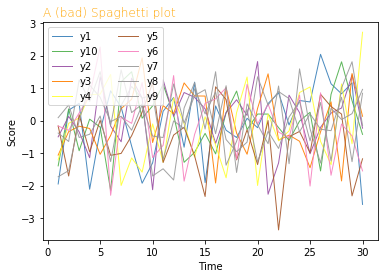

In [7]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
numberOfValues = 30

# Make a data frame
df=pd.DataFrame({'x': range(1,numberOfValues+1), 
                 'y1': np.random.randn(numberOfValues), 
                 'y2': np.random.randn(numberOfValues)
#                  +range(1,11)
                 , 
                 'y3': np.random.randn(numberOfValues)
#                  +range(11,21)
                 , 
                 'y4': np.random.randn(numberOfValues)
#                  +range(6,16)
                 , 
                 'y5': np.random.randn(numberOfValues)
#                  +range(4,14)+(0,0,0,0,0,0,0,-3,-8,-6)
                 , 
                 'y6': np.random.randn(numberOfValues)
#                  +range(2,12)
                 , 
                 'y7': np.random.randn(numberOfValues)
#                  +range(5,15)
                 , 
                 'y8': np.random.randn(numberOfValues)
#                  +range(4,14)
                 , 
                 'y9': np.random.randn(numberOfValues)
#                  +range(4,14)
                 , 
                 'y10': np.random.randn(numberOfValues)
#                  +range(2,12) 
                })

# style
# plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('Set1')

# multiple line plot
num=0
for column in df.drop('x', axis=1):
    num+=1
    plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2)

# Add titles
plt.title("A (bad) Spaghetti plot", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Score")



### Visualise accuracy history

In [1]:
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"

################################################################################################
det-4L-cuda-remove0-relativeToUpperMiddleBottomCentersOfVideo-norm-drop-0,2-reg-1e-05#


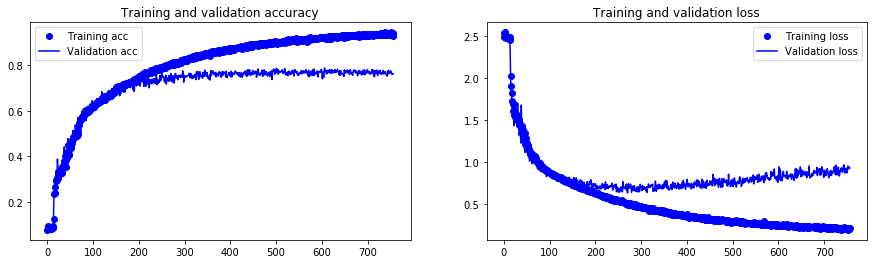

Test acc: 84.968 Val acc: 78.708 (At iteration 606) final training acc: 94.385
Test acc MIN LOSS model: 81.039 Val acc MIN LOSS model: 76.269 (At iteration 270) final training acc: 80.241
################################################################################################
det-5L-cuda-remove0-relativeToUpperMiddleBottomCentersOfVideo-norm-drop-0,2-reg-1e-05#


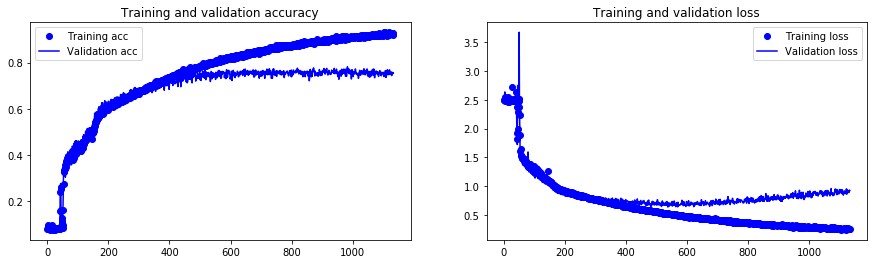

Test acc: 84.546 Val acc: 78.181 (At iteration 983) final training acc: 93.164
Test acc MIN LOSS model: 79.457 Val acc MIN LOSS model: 76.203 (At iteration 537) final training acc: 79.899
################################################################################################
det-5L-cuda-remove0-relativeToUpperMiddleBottomCentersOfVideo-norm-drop-0,15-reg-1e-05#


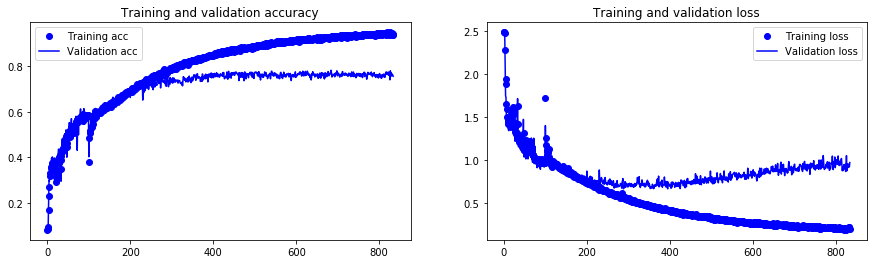

Test acc: 83.940 Val acc: 78.312 (At iteration 684) final training acc: 95.003
Test acc MIN LOSS model: 81.566 Val acc MIN LOSS model: 77.126 (At iteration 395) final training acc: 84.847
################################################################################################
det-4L-cuda-remove0-relativeToUpperMiddleBottomCentersOfVideo-norm-drop-0,1


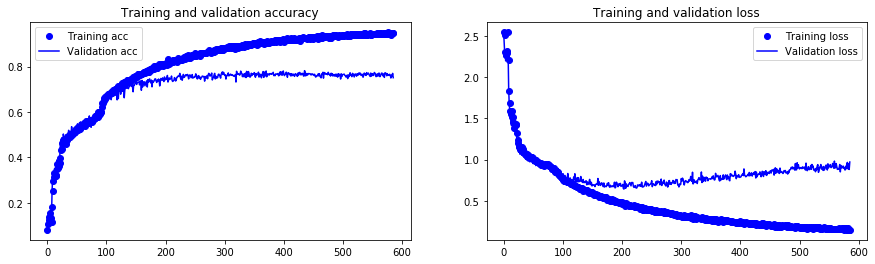

Test acc: 83.650 Val acc: 78.181 (At iteration 435) final training acc: 95.085
Test acc MIN LOSS model: 79.720 Val acc MIN LOSS model: 76.071 (At iteration 203) final training acc: 81.201
################################################################################################
det-5L-cuda-remove0-relativeToUpperMiddleBottomCentersOfVideo-norm-drop-0,1-reg-1e-05#


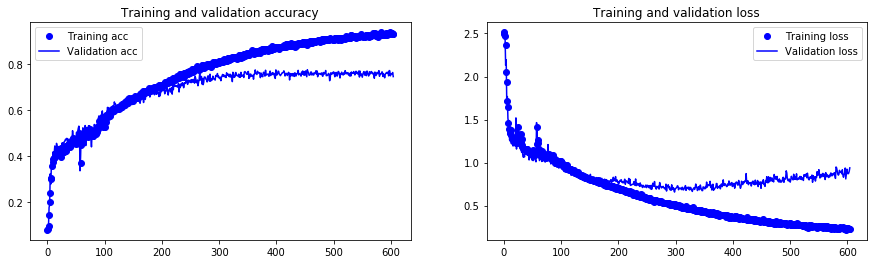

Test acc: 83.623 Val acc: 77.390 (At iteration 454) final training acc: 93.604
Test acc MIN LOSS model: 78.323 Val acc MIN LOSS model: 74.225 (At iteration 298) final training acc: 80.469


In [32]:
import matplotlib.pyplot as plt 
import pickle
from os import scandir
import numpy as np
from os.path import basename #, exists


SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Cross_subject/"
# SAVED_MODEL_FOLDER += "Cross_subject_tough/"
# SAVED_MODEL_FOLDER += "Cross_view/"
SAVED_MODEL_FOLDER += "Cross_view_tough/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)
        
loadedResults.sort(key=lambda x : x["test_acc"],reverse=True)

for result in loadedResults[:5]:
    historyPath = SAVED_MODEL_FOLDER+result["model_name"]+".pickle"
    with open(historyPath,"rb") as file_in:
        r = pickle.load(file_in)

    model_history = r["history"]
    print("################################################################################################")
    print(cleanForExcel(basename(historyPath)))
#     print(basename(historyPath))

    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize = (15,4))
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(epochs, acc, 'bo', label='Training acc')
    ax1.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    ax1.legend()

    #     plt.figure()
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(epochs, loss, 'bo', label='Training loss')
    ax2.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    ax2.legend()

    plt.show()
    print("Test acc: {:.3f} Val acc: {:.3f} (At iteration {}) final training acc: {:.3f}".format(result['test_acc']*100,max(val_acc)*100,np.argmax(val_acc),max(acc)*100))
    if "test_acc_minLoss" in result.keys():
        indexMinLoss = np.argmin(val_loss)
        print("Test acc MIN LOSS model: {:.3f} Val acc MIN LOSS model: {:.3f} (At iteration {}) final training acc: {:.3f}".format(result['test_acc_minLoss']*100,val_acc[indexMinLoss]*100,indexMinLoss,acc[indexMinLoss]*100))
    if "loaded_from" in r.keys():
        print("Loaded from:", cleanForExcel(r["loaded_from"]))

In [12]:
loadedResults[1]["model_name"]

'keypoint_rcnn_X_101_32x8d_FPN_3x-3L-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-rec_drop-0.1'

In [5]:
result.keys()

dict_keys(['val_acc', 'test_acc', 'model_name', 'y_val_true', 'y_val_pred', 'y_test_true', 'y_test_pred', 'val_acc_minLoss', 'test_acc_minLoss', 'y_val_pred_minLoss', 'y_test_pred_minLoss'])

### Visualize missclassified

In [52]:
import seaborn as sn
def plotConfusionMatrixes(conf_mat_val, conf_mat_test, labelString = None):
    plt.figure(figsize = (25,35))
    ax1 = plt.subplot(2, 1, 1)
    ax1 = sn.heatmap(conf_mat_val, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.title("VALIDATION SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15
    
    ax2 = plt.subplot(2, 1, 2)
    
    ax2 = sn.heatmap(conf_mat_test, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.title("TEST SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15

    plt.show()

Val acc: 0.863792194092827
Test acc: 0.9035864978902953


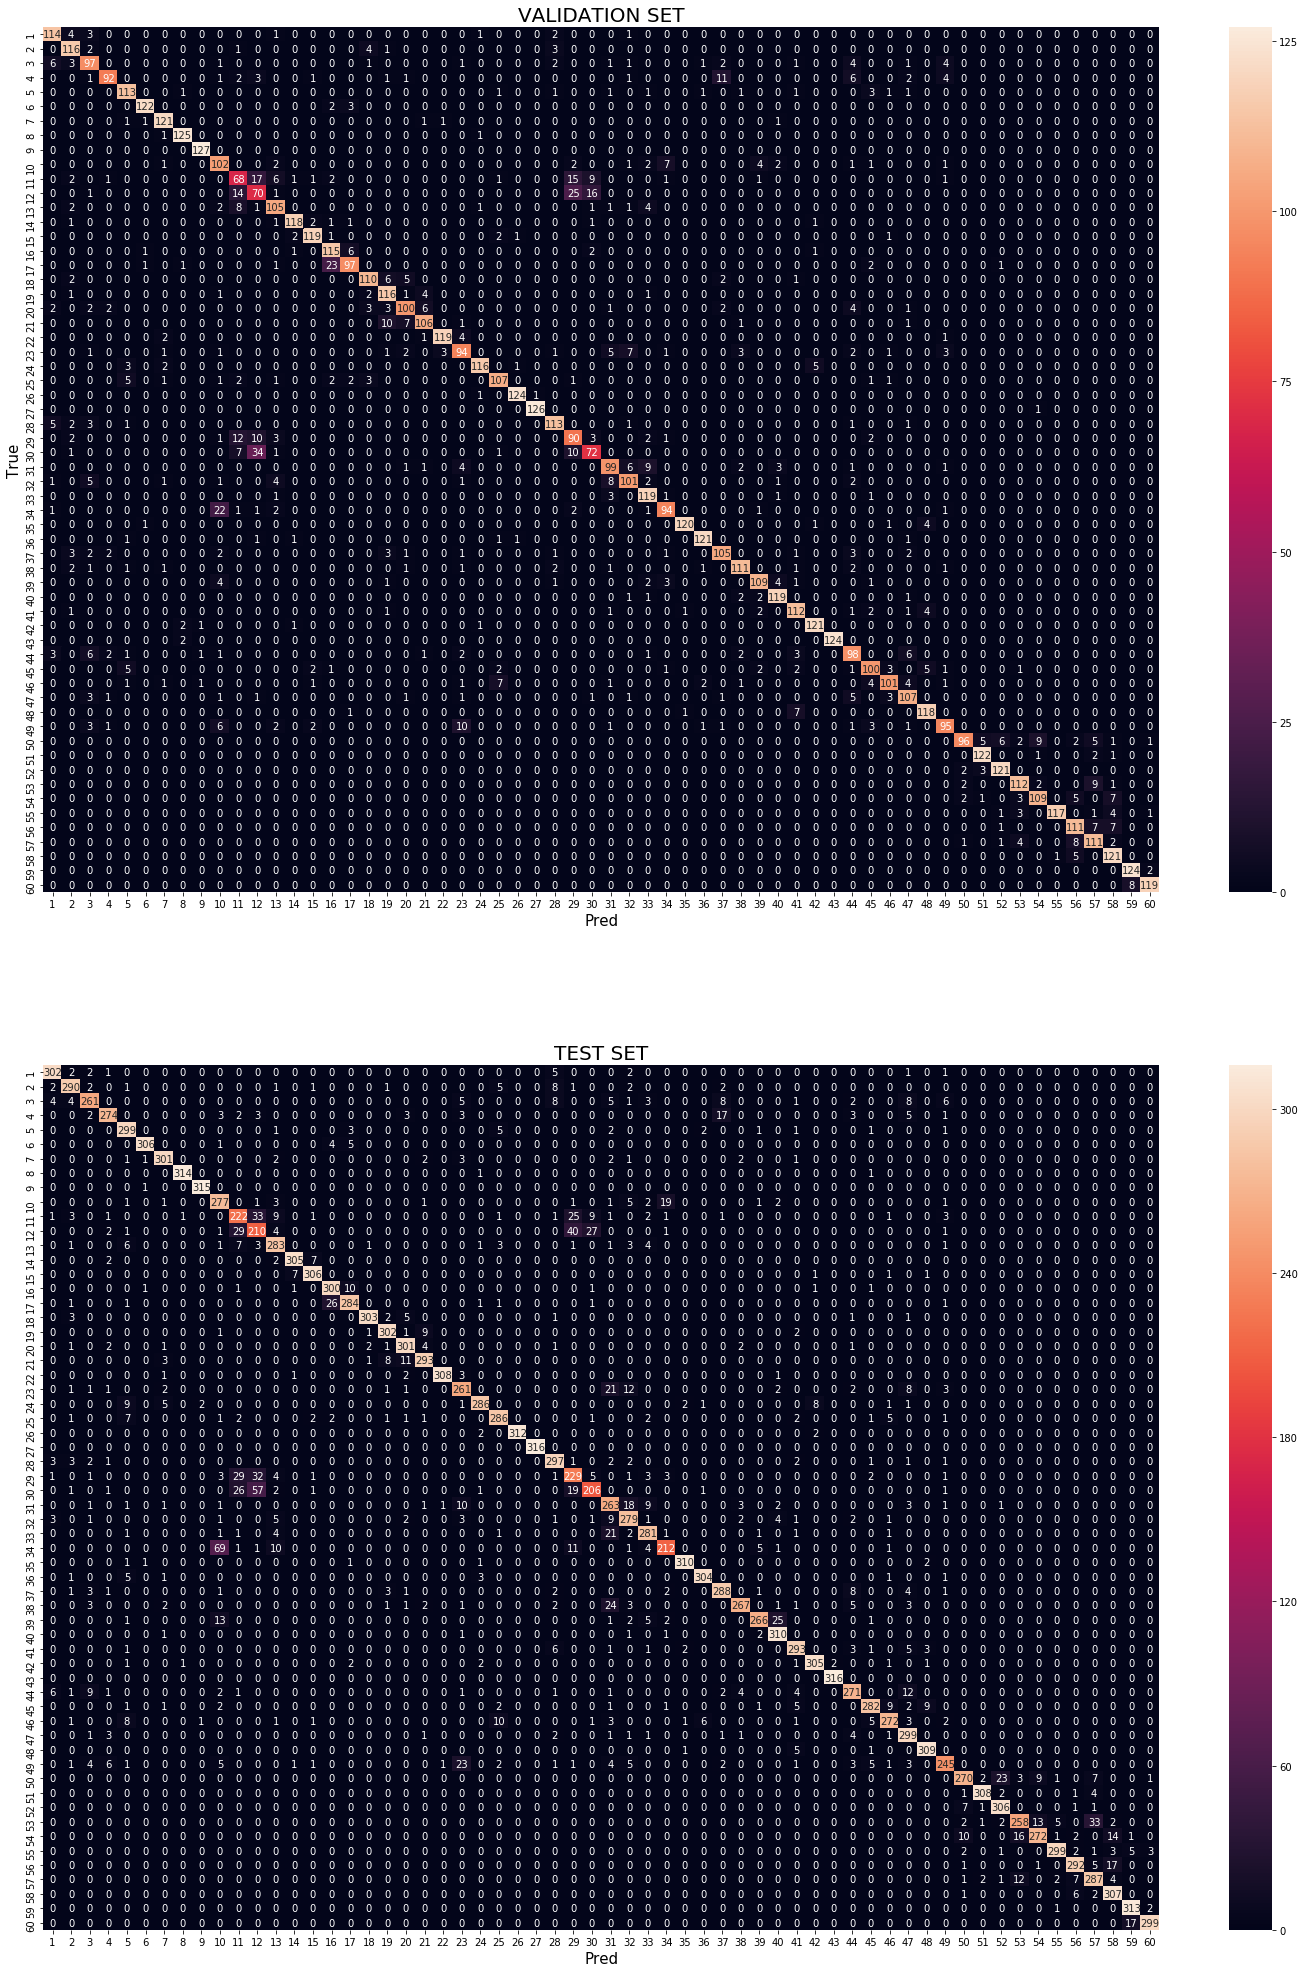

TEST PAIR CONFUSED:
 [[34, 10], [30, 12], [12, 29], [11, 12], [53, 57], [29, 12], [29, 11], [12, 11], [12, 30], [30, 11], [17, 16], [11, 29], [39, 40], [38, 31], [50, 52], [49, 23], [23, 31], [33, 31], [10, 34], [30, 29], [31, 32]]
TEST TOPIC CONFUSED:
 [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 39, 40, 38, 31, 50, 52, 49, 23, 33, 32]

VAL PAIR CONFUSED:
 [[30, 12], [12, 29], [17, 16], [34, 10], [11, 12], [12, 30], [11, 29], [12, 11], [29, 11], [4, 37], [29, 12], [21, 19], [49, 23], [30, 29], [11, 30], [50, 54], [53, 57], [31, 33], [13, 11], [60, 59], [57, 56]]
VAL TOPIC CONFUSED:
 [30, 12, 29, 17, 16, 34, 10, 11, 4, 37, 21, 19, 49, 23, 50, 54, 53, 57, 31, 33, 13, 60, 59, 56]

COMMON MOST CONFUSED:
 [[34, 10], [30, 12], [12, 29], [11, 12], [53, 57], [29, 12], [29, 11], [12, 11], [12, 30], [17, 16], [11, 29], [49, 23], [30, 29]]
COMMON TOPIC CONFUSED:
 [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 49, 23]
lenght: 12


In [54]:
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# label_order = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 
#                '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', 
#                '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 
#                '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 
#                '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', 
#                '6', '60', '7', '8', '9']


SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_view/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_subject/"
# SAVED_MODEL_FOLDER += "Cross_view_mini/"  
# SAVED_MODEL_FOLDER += "Cross_subject_mini/" 
SAVED_MODEL_FOLDER += "Cross_view/"  
# SAVED_MODEL_FOLDER += "Cross_subject/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)

loadedResults.sort(key=lambda x : x["test_acc"],reverse=True)
result = loadedResults[0]

y_val_pred = result["y_val_pred"]
y_val_true = result["y_val_true"]
y_test_pred = result["y_test_pred"]
y_test_true = result["y_test_true"]
val_acc = result["val_acc"]
test_acc = result["test_acc"]
print("Val acc:",val_acc)
print("Test acc:",test_acc)

# import pandas as pd
# y_actu_val = pd.Series(y_val_true, name='Actual')
# y_pred_val = pd.Series(y_val_pred, name='Predicted')
# conf_mat_val = pd.crosstab(y_actu_val, y_pred_val, rownames=['Actual'], colnames=['Predicted']
# #                            , margins=True
#                           )

# y_actu_test = pd.Series(y_test_true, name='Actual')
# y_pred_test = pd.Series(y_test_pred, name='Predicted')
# conf_mat_test = pd.crosstab(y_actu_test, y_pred_test, rownames=['Actual'], colnames=['Predicted']
# #                             , margins=True
#                            )

conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred)            
conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred)

# # normalize
# conf_mat_val = conf_mat_val / conf_mat_val.sum(axis=1)
# conf_mat_test = conf_mat_test / conf_mat_test.sum(axis=1)

labels = range(1,len(conf_mat_val[0])+1)
plotConfusionMatrixes(conf_mat_val,conf_mat_test,labelString=labels)

length = len(conf_mat_test)

till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


In [13]:
#CROSS_SUBJECT
till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


TEST PAIR CONFUSED:
 [[12, 30], [10, 34], [11, 12], [29, 12], [31, 32], [11, 29], [17, 16], [16, 17], [34, 10], [29, 30], [12, 29], [11, 30], [30, 12], [29, 11], [39, 10], [53, 57], [31, 23], [46, 45], [1, 3], [52, 50], [15, 14]]
TEST TOPIC CONFUSED:
 [12, 30, 10, 34, 11, 29, 31, 32, 17, 16, 39, 53, 57, 23, 46, 45, 1, 3, 52, 50, 15, 14]

VAL PAIR CONFUSED:
 [[12, 30], [11, 12], [34, 10], [32, 23], [29, 12], [30, 12], [12, 29], [11, 29], [58, 56], [21, 19], [12, 11], [31, 32], [10, 34], [53, 57], [31, 23], [50, 51], [32, 31], [13, 5], [54, 58], [4, 37], [17, 16]]
VAL TOPIC CONFUSED:
 [12, 30, 11, 34, 10, 32, 23, 29, 58, 56, 21, 19, 31, 53, 57, 50, 51, 13, 5, 54, 4, 37, 17, 16]

COMMON MOST CONFUSED:
 [[12, 30], [10, 34], [11, 12], [29, 12], [31, 32], [11, 29], [17, 16], [34, 10], [12, 29], [30, 12], [53, 57], [31, 23]]
COMMON TOPIC CONFUSED:
 [12, 30, 10, 34, 11, 29, 31, 32, 17, 16, 53, 57, 23]
lenght: 13


In [11]:
#CROSS_VIEW
till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


TEST PAIR CONFUSED:
 [[34, 10], [30, 12], [12, 29], [11, 12], [53, 57], [29, 12], [29, 11], [12, 11], [12, 30], [30, 11], [17, 16], [11, 29], [39, 40], [38, 31], [50, 52], [49, 23], [23, 31], [33, 31], [10, 34], [30, 29], [31, 32]]
TEST TOPIC CONFUSED:
 [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 39, 40, 38, 31, 50, 52, 49, 23, 33, 32]

VAL PAIR CONFUSED:
 [[30, 12], [12, 29], [17, 16], [34, 10], [11, 12], [12, 30], [11, 29], [12, 11], [29, 11], [4, 37], [29, 12], [21, 19], [49, 23], [30, 29], [11, 30], [50, 54], [53, 57], [31, 33], [13, 11], [60, 59], [57, 56]]
VAL TOPIC CONFUSED:
 [30, 12, 29, 17, 16, 34, 10, 11, 4, 37, 21, 19, 49, 23, 50, 54, 53, 57, 31, 33, 13, 60, 59, 56]

COMMON MOST CONFUSED:
 [[34, 10], [30, 12], [12, 29], [11, 12], [53, 57], [29, 12], [29, 11], [12, 11], [12, 30], [17, 16], [11, 29], [49, 23], [30, 29]]
COMMON TOPIC CONFUSED:
 [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 49, 23]
lenght: 12


In [14]:

view = [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 49, 23] # toughest cross_view
subj = [12, 30, 10, 34, 11, 29, 31, 32, 17, 16, 53, 57] # toughest cross_subject
subj.sort()
view.sort()
print("subj =", subj)
print("view =", view)

subj = [10, 11, 12, 16, 17, 29, 30, 31, 32, 34, 53, 57]
view = [10, 11, 12, 16, 17, 23, 29, 30, 34, 49, 53, 57]


## Re-evaluating first result

In [ ]:
import dill
from keras import models,layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Concatenate , Dense
from keras.models import Model,load_model
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint
import random
from os import scandir
from os.path import exists
import shutil 

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"

MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"

# folder_to_evaluate = "Cross_view/"  
folder_to_evaluate = "Cross_subject/"

completeFolderPath = SAVED_MODEL_FOLDER+folder_to_evaluate


assert exists(completeFolderPath+"summaryResults-Copy1.pickle")
print("Loading previous results...")
with open(completeFolderPath+"summaryResults-Copy1.pickle","rb") as handle:
    results = pickle.load(handle)

results.sort(key=lambda x : x["test_acc"],reverse=True)

modelNameToLoad = results[0]['model_name']

accessoriesPath = completeFolderPath+modelNameToLoad+".pickle"

print("Loading accessories:",accessoriesPath)
with open(accessoriesPath,"rb") as handle:
    accessories = pickle.load(handle)
            
print("Loading functions...")
loaded_specific_functions = [dill.loads(x) for x in accessories["spec_fun_DILL"]]

## SPECIFIC FUNCTIONS
specificFunctions = []
for elem in loaded_specific_functions:
    if callable(elem):
        specificFunctions.append(elem)
    elif not callable(elem):
        specificFunctions.append(elem[0])
                

if folder_to_evaluate.endswith("Cross_subject/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"           
elif folder_to_evaluate.endswith("Cross_view/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"
else:
    raise Exception("folder not recognised")
    
### LOADING DATASET ###
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
                                                                               val_set, 
                                                                               test_set,  
                                                                               specificFunctions)
encodingLabels = [int(i) for i in encodingLabels]

model = load_model(completeFolderPath+modelNameToLoad+".h5")
### EVALUATING MODEL ###      
val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))


minLossModelName = "{}-min_val_loss.hdf5".format(completeFolderPath+modelNameToLoad)
model_minLoss = load_model(minLossModelName)
val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))

### SAVING RESULTS ###
results[0]={"val_acc": val_acc, 
                "test_acc": test_acc, 
                "model_name": modelNameToLoad, 
                "y_val_true": y_val_true,
                "y_val_pred": y_val_pred,
                "y_test_true": y_test_true,
                "y_test_pred": y_test_pred,

                "val_acc_minLoss": val_acc_minLoss, 
                "test_acc_minLoss": test_acc_minLoss, 
                "y_val_pred_minLoss": y_val_pred_minLoss,
                "y_test_pred_minLoss": y_test_pred_minLoss
               }

print("Dumping results...")
with open(completeFolderPath+"summaryResults.pickle","wb") as handle:
    pickle.dump(results, handle)

print("DONE!")


### Visualize nextFrameResults

In [32]:
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

model_name = "keypoint_rcnn_X_101_32x8d_FPN_3x"
# model_name = "PoseNet-101"
datasetName = DATASET_FOLDER+model_name+"-CROSS_SUBJECT_MINI-dataset.pickle"

train_set, val_set, test_set = getData(datasetName)

train_set[0] = removeZerosFromDataset(train_set[0])
# train_set[0] = relativeToNextFrameBuilder(11)(train_set[0])
# train_set[0] = relativeToUpperMiddleBottomCentersOfVideo(train_set[0])
train_set[0] = cumulativeDifferences(train_set[0])
# train_set[0] = normalizeVideosXYInpid(train_set[0])
train_set[0] = normalizeVideos(train_set[0])

# val_set[0] = removeZerosFromDataset(val_set[0])
# test_set[0] = removeZerosFromDataset(test_set[0])

# labels = ["train_set", "val_set", "test_set"]
# for i,dataset in enumerate([train_set, val_set, test_set]):
#     totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
#     print("{} shape: {}".format(labels[i], dataset[0].shape))
#     print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))
        
print("DONE!")

train_set shape: (6451,)
train_set zero elements: 18496/19641018 (0.094%)
val_set shape: (1613,)
val_set zero elements: 6358/4906268 (0.13%)
test_set shape: (3312,)
test_set zero elements: 5032/10836820 (0.046%)
removing zeros from dataset
Adapting the data as the CUMULATIVE DIFFERENCES of consecutive frames
normalising EACH VIDEO, considering x and y TOGETHER
DONE!


In [34]:
from random import randint
video_ids = [randint(0,len(train_set[0])) for i in range(15)]

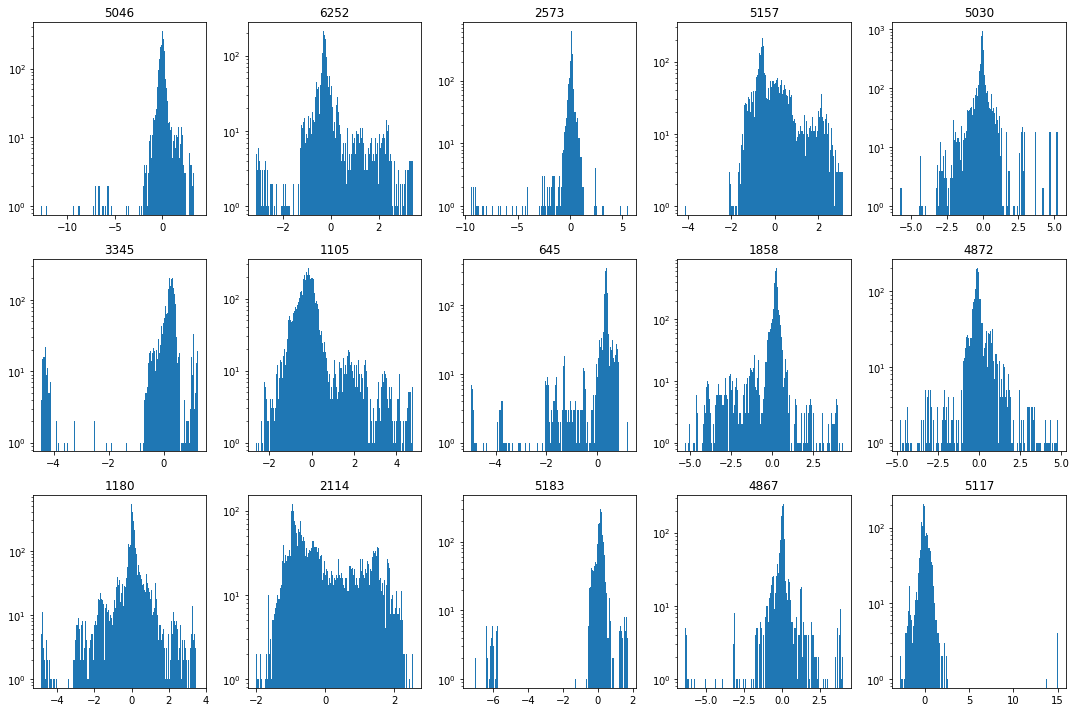

In [35]:
# CUMULATIVE DIFFERENCES
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

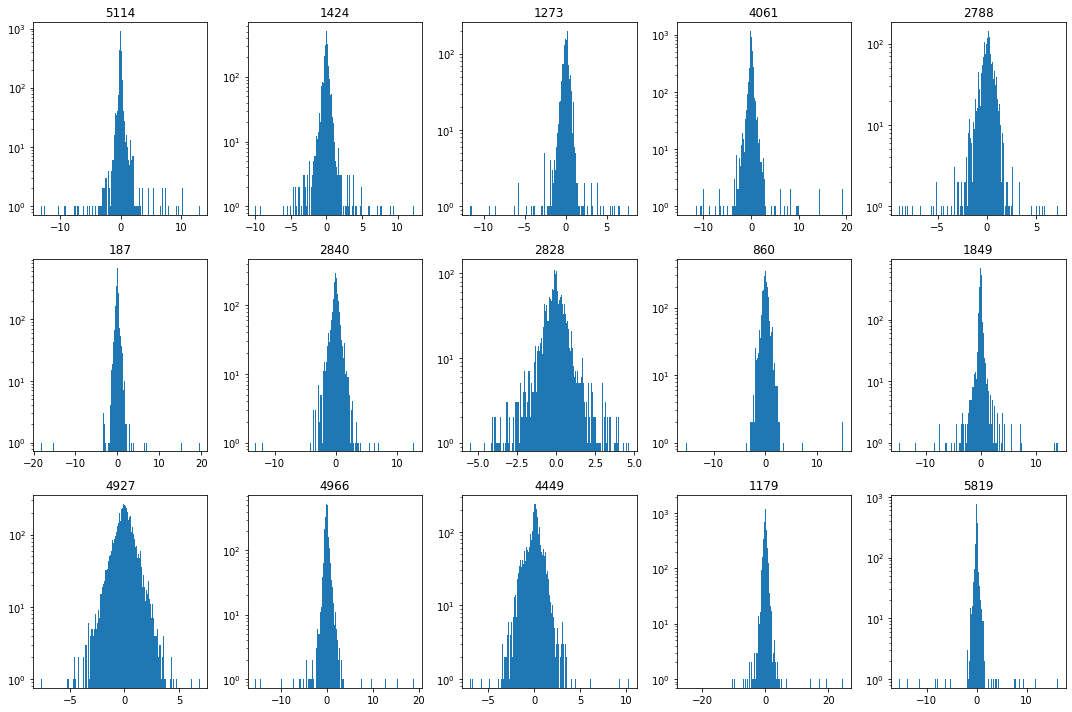

In [255]:
# NEXT FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

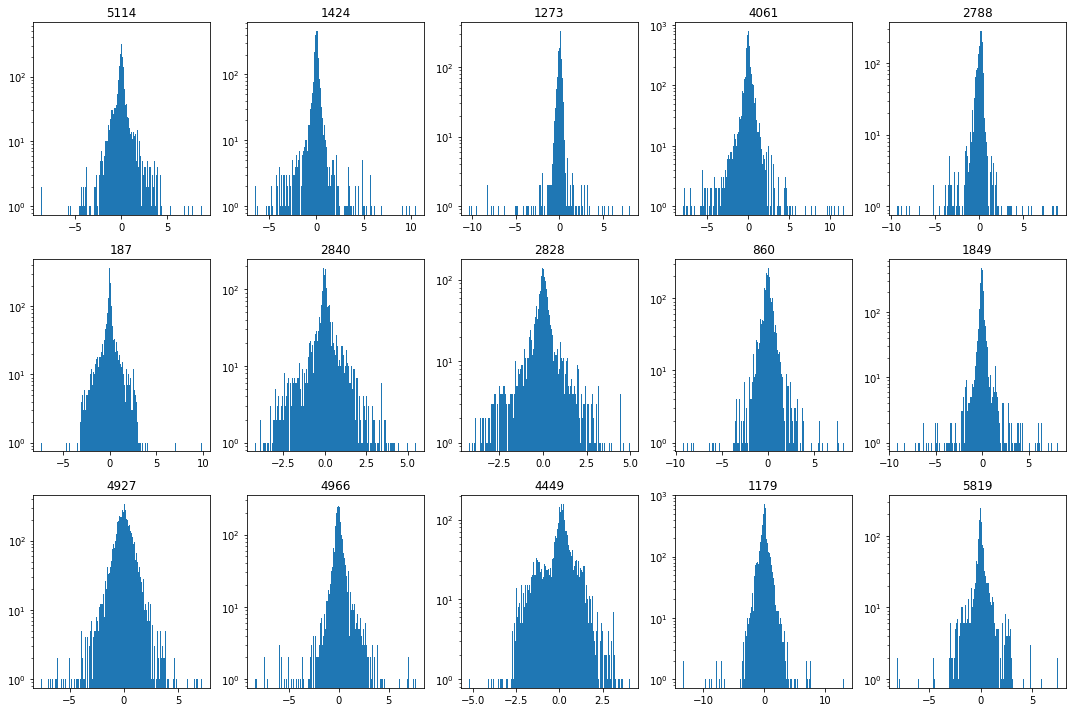

In [259]:
# NEXT 5 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

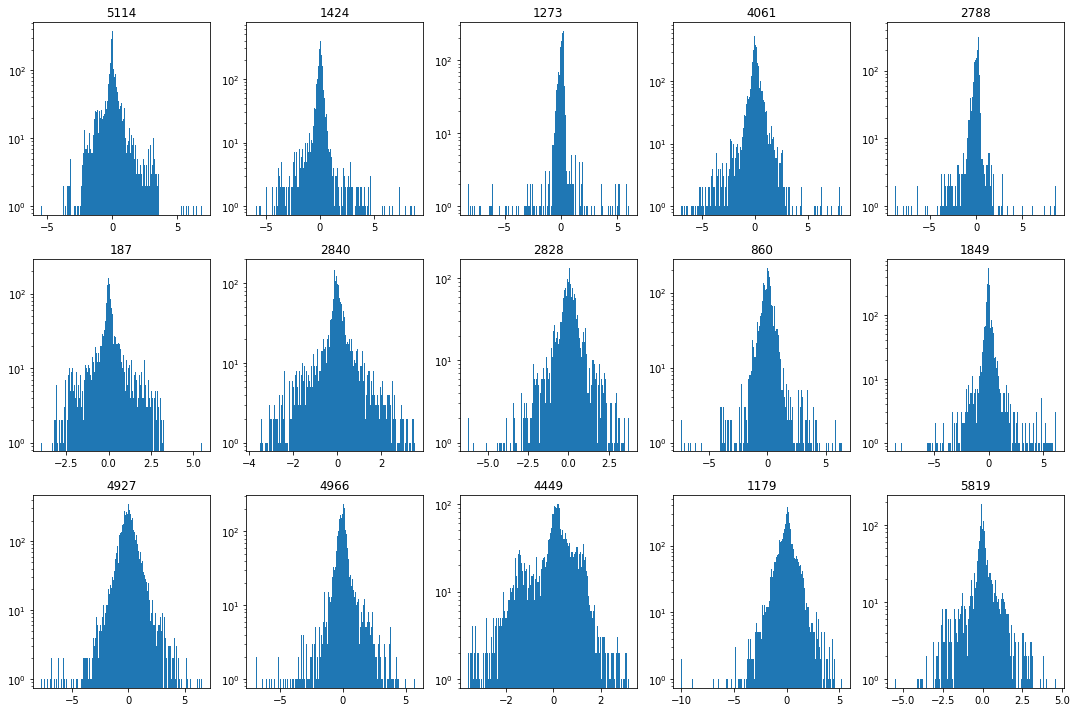

In [261]:
# NEXT 11 FRAME nomalizing INDIPENDENTLY
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

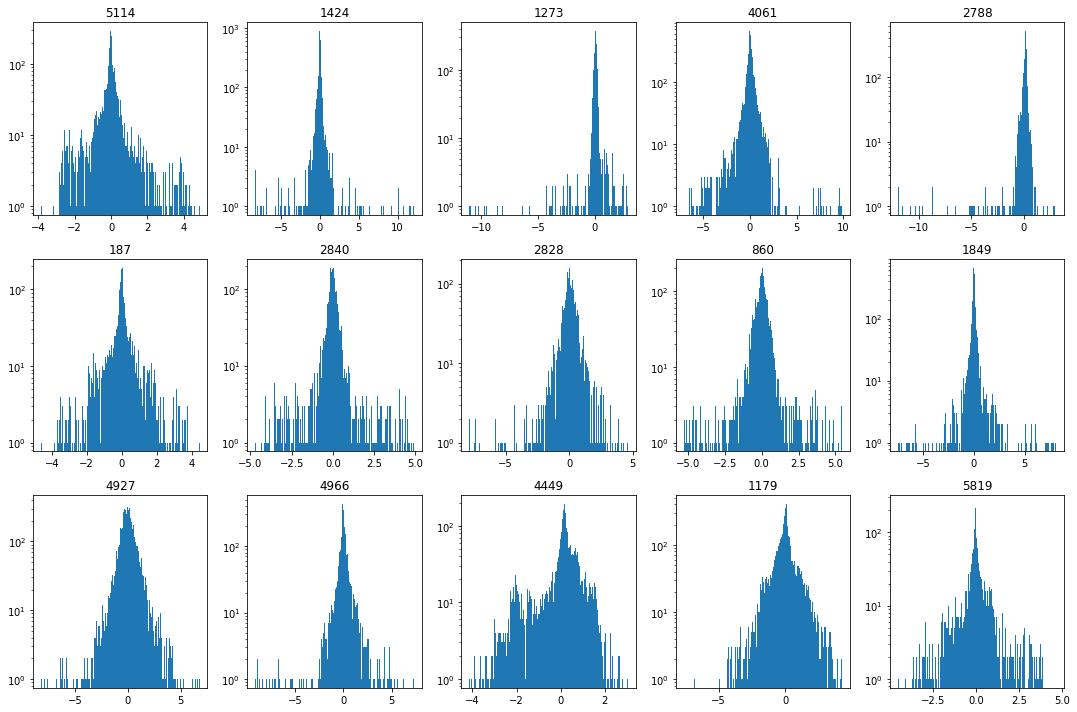

In [267]:
# NEXT 11 FRAME nomalizing TOGETHER
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

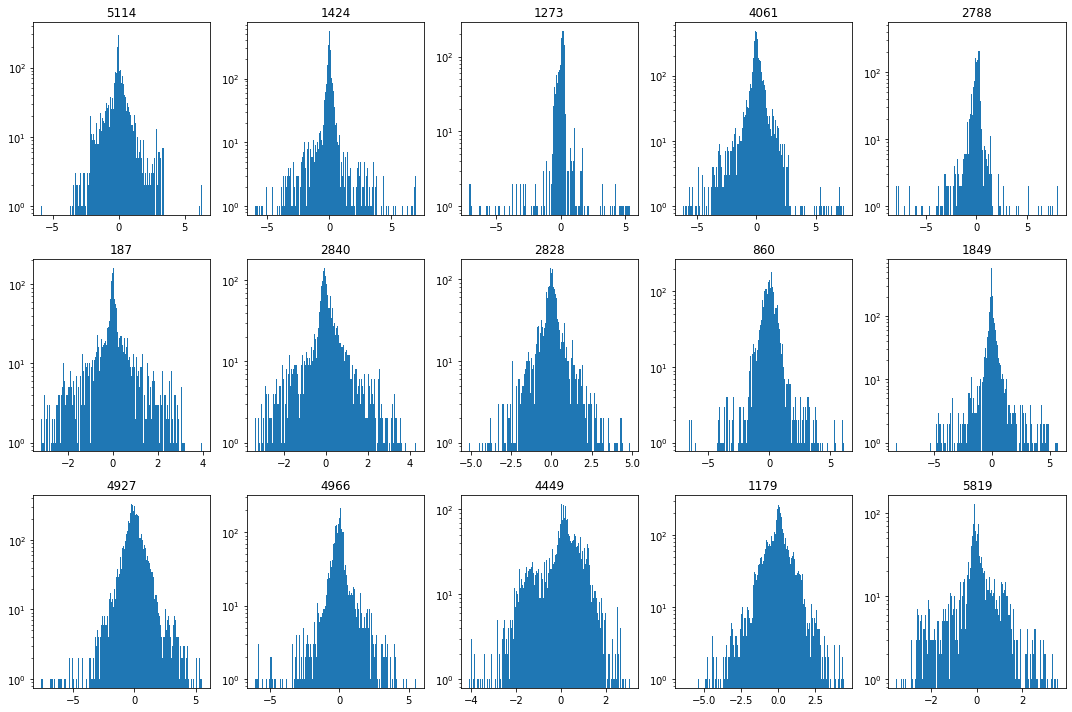

In [263]:
# NEXT 15 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

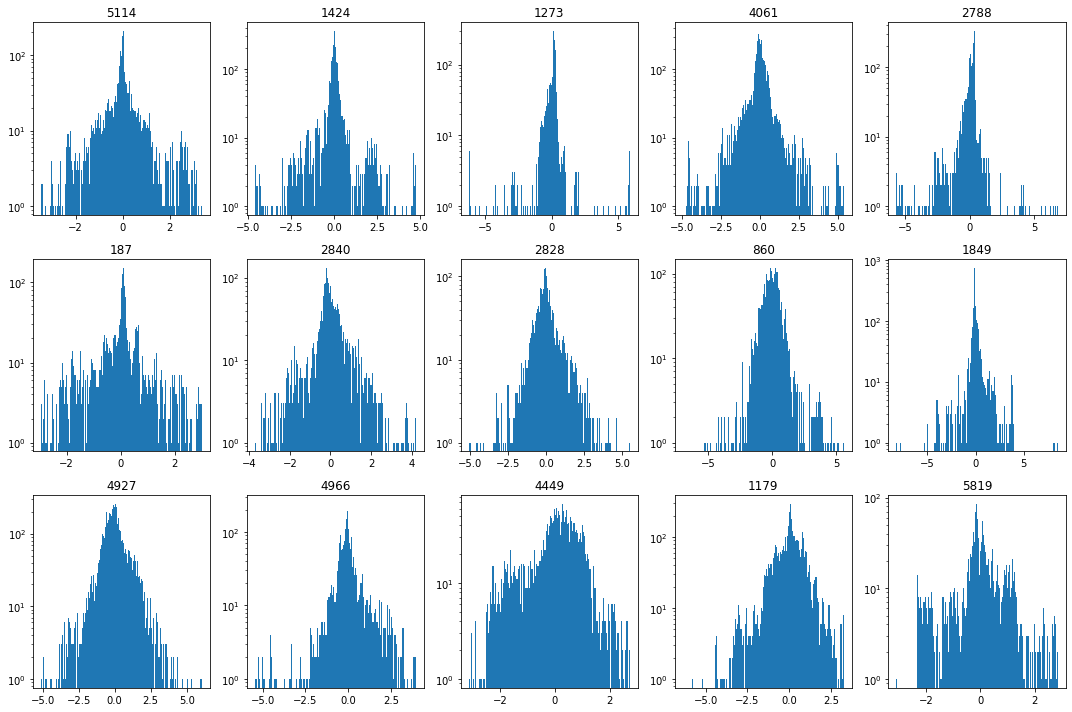

In [265]:
# NEXT 30 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

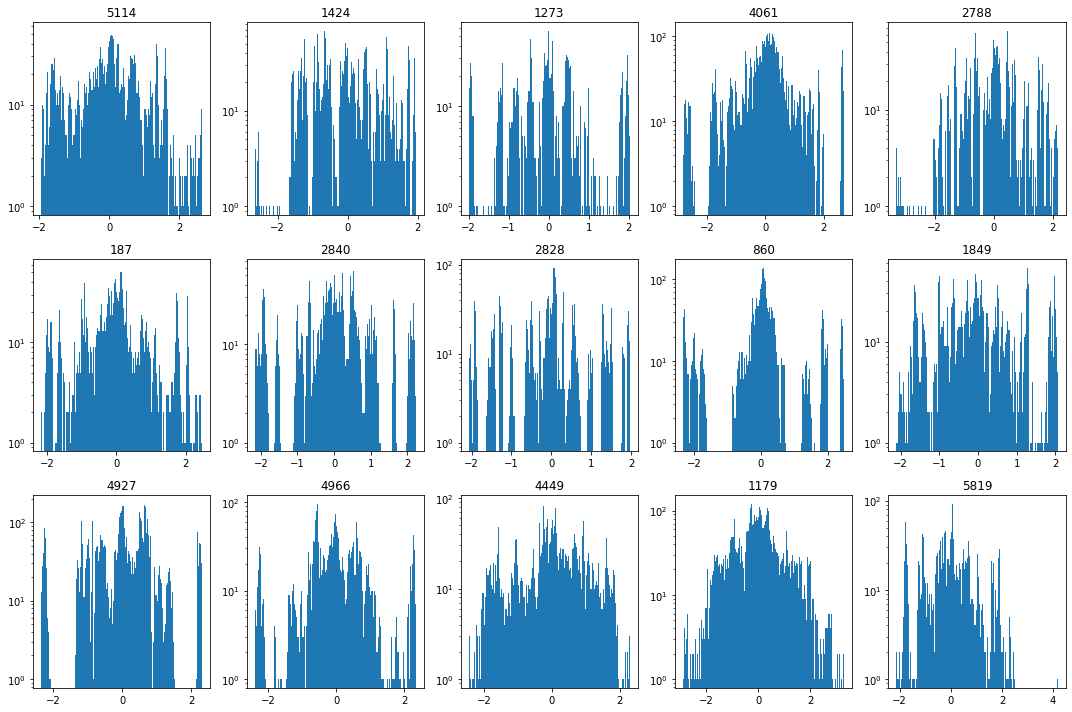

In [277]:
# 3BAR
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

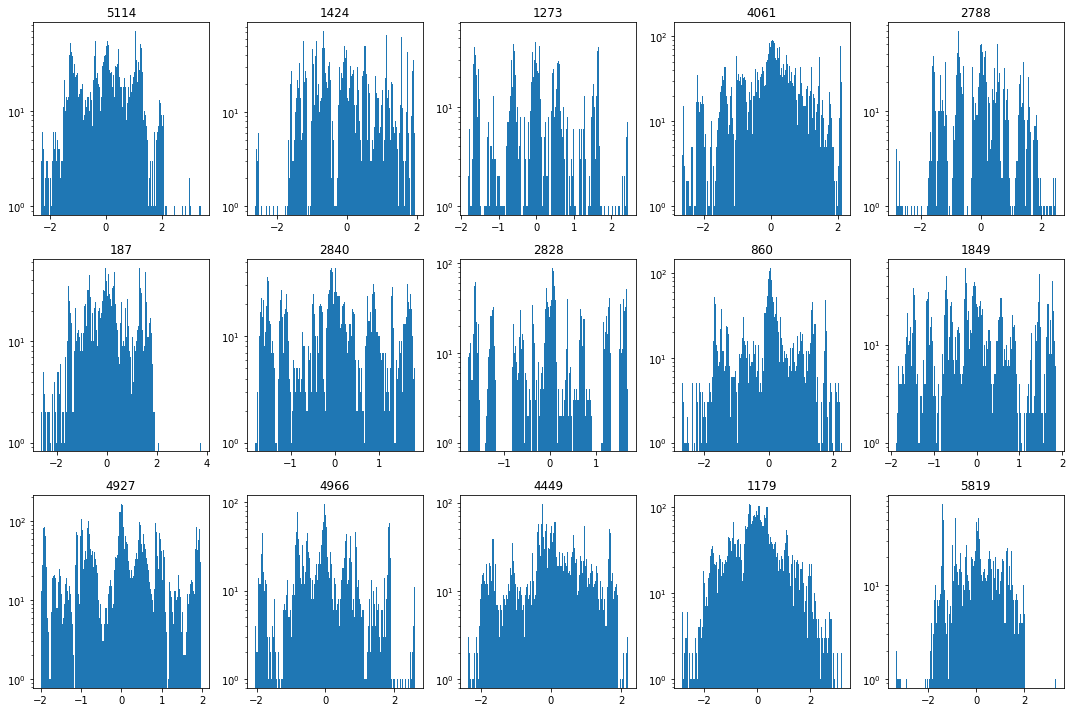

In [275]:
# 3BAR INDIP
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

## CLEAN Results

In [112]:
#remove last element of summary result

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "Cross_view/"
SAVED_MODEL_FOLDER += "Cross_subject/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)

print("Removing",loadedResults[-1]['model_name'])
print ("From",SAVED_MODEL_FOLDER+"summaryResults.pickle")

# loadedResults = loadedResults[:-1]
# with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","wb") as handle:
#             pickle.dump(loadedResults, handle)

Removing keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeTo5CentersNTURGBofVideo-drop-0.1-rec_drop-0.1-norm
From /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Senesi/summaryResults.pickle


## Removing accessories file for low results

In [5]:
from os.path import isfile, isdir, join, exists,getsize,basename
from os import scandir
import pickle

NUMBER_OF_BEST_MODEL_TO_SAVE = 20

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
SAVED_MODEL_FOLDER += "Cross_view_mini/"
# SAVED_MODEL_FOLDER += "Cross_subject_mini/"


accessoryFileList = [f.path for f in scandir(SAVED_MODEL_FOLDER) 
                       if f.path.endswith(".pickle") 
                       and "summaryResult" not in basename(f)]

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)
        
loadedResults.sort(key=lambda x : x["test_acc"], reverse=True)
assert NUMBER_OF_BEST_MODEL_TO_SAVE > 10
bestModels = [r['model_name'] for r in loadedResults[:NUMBER_OF_BEST_MODEL_TO_SAVE]]

for accessoryFile in accessoryFileList:
    modelNameToCheck = basename(accessoryFile).replace(".pickle","")
    if modelNameToCheck not in bestModels:
        print("Removing",accessoryFile)
        !rm $accessoryFile

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.1-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideosXYInpid-drop-0.5-reg-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.5-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.05-rec_drop-0.05.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideosXYInpid-drop-0-rec_drop-0.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideos-drop-0-rec_drop-0.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-normalizeVideos-drop-0.1-rec_drop-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.1-reg-0.pickle


# AREA TEST

## Testing relativeToNextFrameFunction

In [23]:
MODEL_NAME
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-SPLIT-dataset.pickle
train_set shape: (5460,)
train_set zero elements: 0/13984574 (0.0%)
val_set shape: (1365,)
val_set zero elements: 0/3509310 (0.0%)
test_set shape: (759,)
test_set zero elements: 0/1973564 (0.0%)


In [24]:
set_to_Test = train_set[0][:3]

In [26]:
len(set_to_Test)

3

In [32]:
differences = relativeToNextFrame(train_set[0])

Adapting the data to the next frame


In [36]:
train_set[0][0][:2]

[[[1007.7985, 325.73468],
  [1006.3635, 315.66202],
  [1002.0584, 315.66202],
  [961.87787, 322.85678],
  [979.09814, 318.53992],
  [956.1378, 376.0981],
  [969.053, 377.53705],
  [983.4032, 465.3133],
  [974.793, 460.99646],
  [1007.7985, 534.3832],
  [1006.3635, 532.9442],
  [961.87787, 528.6273],
  [964.74786, 528.6273],
  [957.5728, 646.62164],
  [961.87787, 648.0606],
  [954.7027, 747.3485],
  [959.0078, 755.9822]],
 [[1008.1875, 325.57687],
  [1006.7477, 315.524],
  [1002.42804, 315.524],
  [959.2314, 322.70465],
  [977.9499, 321.2685],
  [957.79144, 375.84143],
  [967.8706, 377.27756],
  [967.8706, 460.5731],
  [977.9499, 462.00922],
  [1016.82684, 533.8157],
  [1016.82684, 533.8157],
  [959.2314, 530.9434],
  [963.55096, 530.9434],
  [956.3515, 648.7061],
  [962.11115, 650.1422],
  [954.9117, 743.49066],
  [957.79144, 754.97974]]]

In [40]:
# trainAndVal = np.concatenate((X_train, X_val), axis=0)
print("normalising train, val and test values BEFORE padding")
trainMean = np.vstack(differences).mean() # the mean and std must be calculated only on the training data
trainStd = np.vstack(differences).std()
trainMean,trainStd

normalising train, val and test values BEFORE padding


(-0.056956816, 10.33186)

In [31]:
len(differences[0]),len(set_to_Test[0])

(52, 53)

## Smoothing test

In [35]:
MODEL_NAME = "PoseNet-101"
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/PoseNet-101-SPLIT-dataset.pickle
train_set shape: (5460,)
train_set zero elements: 58106/13984574 (0.42%)
val_set shape: (1365,)
val_set zero elements: 15980/3509310 (0.46%)
test_set shape: (759,)
test_set zero elements: 9588/1973564 (0.49%)


doing video 0
doing video 1


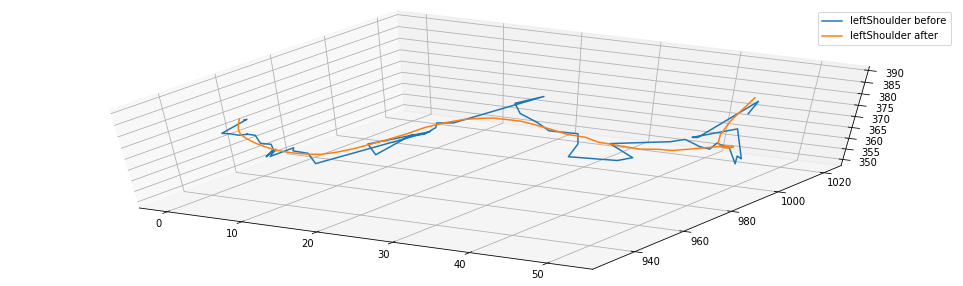

In [36]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
# listOfPoints = list(range(17))
listOfPoints = [5
#                 ,7,9
               ]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(50, -60)
    x, y = zip(*[(f[p][0], f[p][1]) for f in train_set[0][0]])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p]+" before")
    
    smoothingPoints(29,5)[0](train_set[0])
    
    x2, y2 = zip(*[(f[p][0], f[p][1]) for f in train_set[0][0]])
    z2 = np.arange(len(x))
    ax.plot(z2,y2,x2,label=legend[p]+" after")
    
    ax.legend()

plt.show()
  

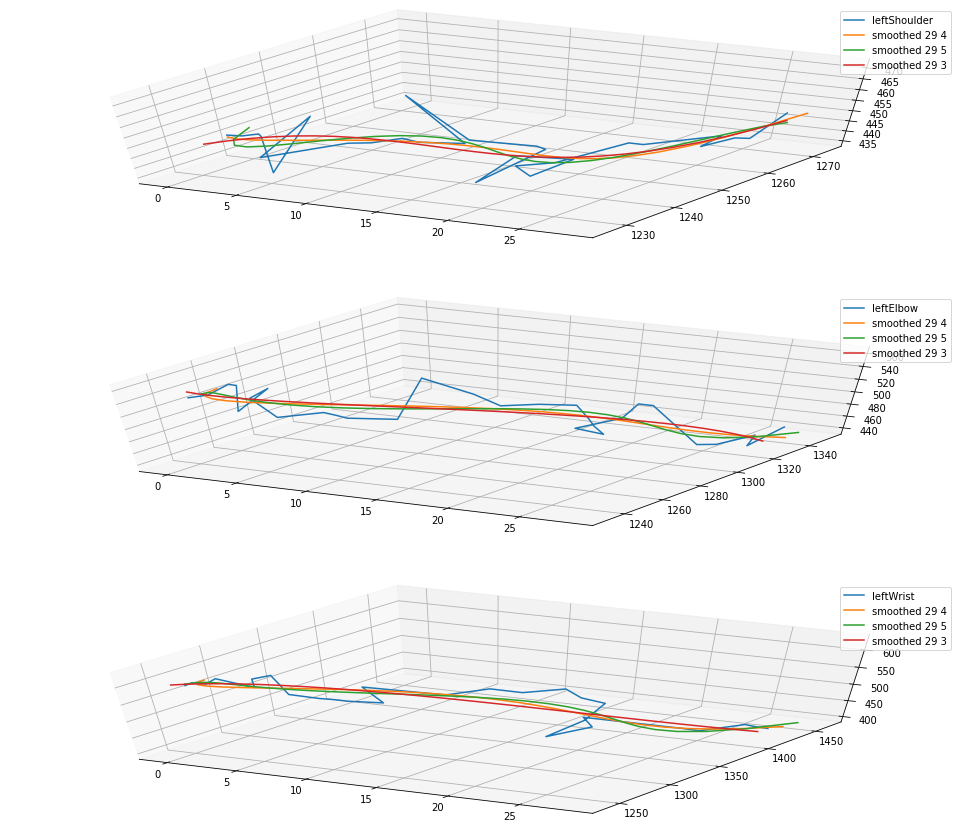

In [91]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
# listOfPoints = list(range(17))
listOfPoints = [5
#                 ,7,9
               ]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(50, -60)
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p])
    
    smooth_y=signal.savgol_filter(y, window, order) 
    smooth_x=signal.savgol_filter(x, window, order)
    ax.plot(z,smooth_y,smooth_x,label="smoothed {} {}".format(window,order))
    
    
    ax.legend()

plt.show()
  

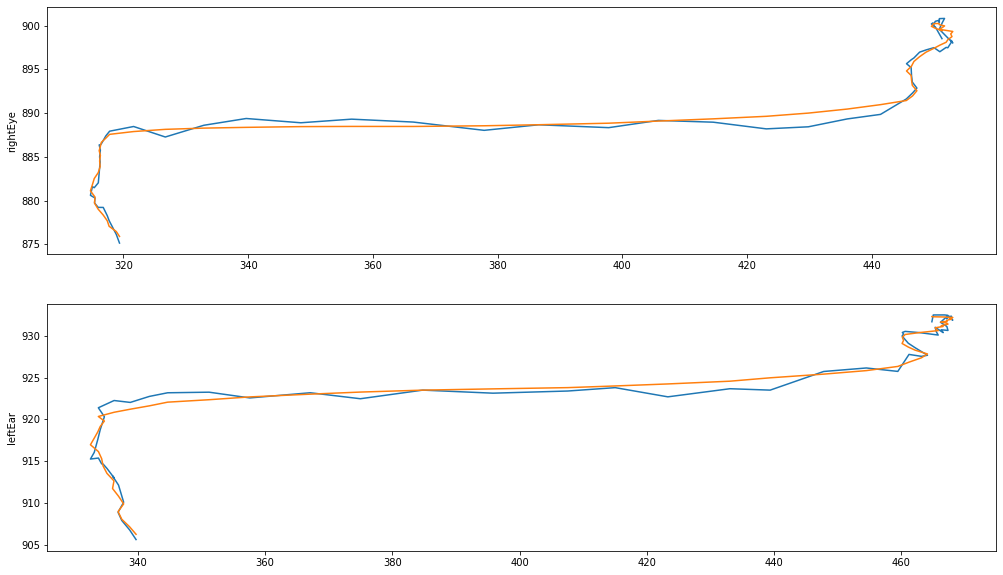

In [302]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
listOfPoints = [2,3]
fig, axes = plt.subplots(nrows=len(listOfPoints), ncols=1)
fig.set_size_inches((17,len(listOfPoints)*5))
for i, p in enumerate(listOfPoints):
    axes[i].set_ylabel(legend[p])
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    # series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    ts = Series(y, index=x)
    # ts = ts.cumsum()
    ts.plot(ax=axes[i])
    
    smooth_y=signal.savgol_filter(ts.get_values(),
                           29, # window size used for filtering
                           3), # order of fitted polynomial

    ts2 = Series(smooth_y[0], index=x)

    ts2.plot(ax=axes[i])

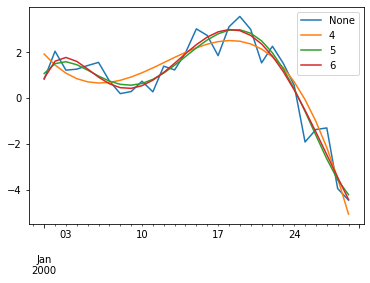

In [115]:
from pandas import read_csv, Series,date_range
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
from numpy import random
from numpy.random import randn
from scipy import signal


# series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
ts = Series(randn(29), index=date_range('1/1/2000', periods=29))
ts = ts.cumsum()
ts.plot()

y1=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       4) # order of fitted polynomial  
ts2 = Series(y1, index=date_range('1/1/2000', periods=29))
ts2.plot(label="4")


y2=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       5) # order of fitted polynomial
ts3 = Series(y2, index=date_range('1/1/2000', periods=29))
ts3.plot(label="5")


y3=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       6) # order of fitted polynomial
ts4 = Series(y3, index=date_range('1/1/2000', periods=29))

ts4.plot(label="6")
plt.legend()

In [150]:
getSaveFileName(MODEL_NAME,preprocess_functions,normalize)

PoseNet-101-smooth
PoseNet-101-smooth-53
PoseNet-101-smooth-53-3


In [14]:
for i, (specific_function, normalize) in enumerate(COMBINATIONS_TO_TEST):
    print(i,specific_function,normalize)

0 <function relativeToNextFrame at 0x7fab0effd7b8> True
1 <function relativeToUpperMiddleBottomCentersOfVideo at 0x7fab0effdea0> True
2 <function relativeToVideoCenter at 0x7fab0fd56e18> True


## load values

In [ ]:
import dill
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences

MODEL_NAME = "PoseNet-101"
MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
train_set, val_set, test_set = getData(datasetName)


with open('/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/PoseNet-101-relativeToNextFrame.pickle',"rb") as handle:
    res = pickle.load(handle)
    
loaded_functions = [dill.loads(x) for x in res["prep_fun_DILL"]]

one_hot_encoding = loaded_functions[0]
normaliseBeforePadding = loaded_functions[1]
paddingTrainValTest = loaded_functions[2]
preprocessData = loaded_functions[3]
relativeToNextFrame = loaded_functions[4]

## old method

In [ ]:
## Determining save file name
saveFileName = MODEL_NAME
for fun in PREPROCESS_FUNCTIONS:
    saveFileName += "-{}".format(fun.__name__)

if NORMALIZE:
    saveFileName += "-norm"

saveFileName +=".h5"
saveFileName

In [9]:
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
train_set, val_set, test_set = getData(datasetName)

number of zeros(before padding): 0
Train dataset shape:  (5460,)
Validation dataset shape:  (1365,)
Test dataset shape:  (759,)


## Preprocessing

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, NORMALIZE, PREPROCESS_FUNCTIONS)

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
number of zeros train (after padding):		27798672 - 66.55%
number of zeros validation (after padding):	6951708 - 66.57%
number of zeros test (after padding):		3883446 - 66.88%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)


In [ ]:
## reshaping ###
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)

# Defining model

In [13]:
from keras import models,layers
from keras.layers import LSTM
BATCH_SIZE = 32
length_in_frames = X_train.shape[1]
model = models.Sequential()
# model.add(layers.Dense(512, activation='relu', input_shape=(BATCH_SIZE, length_in_frames, 17 * 2)))
model.add(LSTM(64, input_shape=(length_in_frames, 17 * 2)))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                25344     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 25,864
Trainable params: 25,864
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='max', baseline=None, restore_best_weights=True)
callbacks_list = [earlyStop]

EPOCHS = 3000 #the earlystop will stop the training
model_history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
#                     validation_split=0.2
                    validation_data=(X_val, y_val)
                   )

model.save(SAVED_MODEL_FOLDER+saveFileName)


Train on 5460 samples, validate on 1365 samples
Epoch 1/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0805 - accuracy: 0.1183 - val_loss: 2.0788 - val_accuracy: 0.1275
Epoch 2/3000
5460/5460 [==============================] - 22s 4ms/step - loss: 2.0799 - accuracy: 0.1227 - val_loss: 2.0786 - val_accuracy: 0.1275
Epoch 3/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0799 - accuracy: 0.1238 - val_loss: 2.0769 - val_accuracy: 0.1289
Epoch 4/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.9958 - accuracy: 0.1764 - val_loss: 1.8582 - val_accuracy: 0.2198
Epoch 5/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.8107 - accuracy: 0.2269 - val_loss: 1.7355 - val_accuracy: 0.2454
Epoch 6/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 1.6389 - accuracy: 0.2936 - val_loss: 1.6151 - val_accuracy: 0.2828
Epoch 7/3000
5460/5460 [==============================] - 19s 4ms/ste

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
max(acc),max(val_acc),min(loss),min(val_loss)

In [ ]:
np.argmax(val_acc)

## Display results

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
# ACTION_LABEL_SET = 
    # A001  - A002 - A023          - A031               -  A049     - A007  - A008     - A009         
    # drink - eat -  hand waving   - point to something - use a fan - throw - sit down - standing up
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc
        
def plotValTestResult(model, x_val, y_val, x_test, y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    print("Val acc:",val_acc)
    print("Test acc:",test_acc)
    conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
    conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
    plotConfusionMatrixes(conf_mat_val,conf_mat_test)
    return val_acc, test_acc

import seaborn as sn
def plotConfusionMatrixes(conf_mat_val, conf_mat_test, labelString = ["drink", "eat", "hand wave", "point-to", "fan", "throw", "sit-down", "stand-up"]):
    plt.figure(figsize = (15,7))
    ax1 = plt.subplot(1, 2, 1)
    ax1 = sn.heatmap(conf_mat_val, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("VALIDATION SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15
    
    ax2 = plt.subplot(1, 2, 2)
    ax2 = sn.heatmap(conf_mat_test, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("TEST SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15

    plt.show()
    

## display model results

In [14]:
functionMap = {
    "relativeToFrameCenter": relativeToFrameCenter,
    "relativeToNextFrame": relativeToNextFrame,
    "relativeToVideoCenter": relativeToVideoCenter,
    "relativeToUpperMiddleBottomCentersOfFrame": relativeToUpperMiddleBottomCentersOfFrame,
    "relativeToUpperMiddleBottomCentersOfVideo": relativeToUpperMiddleBottomCentersOfVideo}
def fromFileNameToParameters(fileName):
    parsedName = fileName.name[:-3].split("-")
    
    normalise = False
    if parsedName[-1]=="norm":
        normalise = True
        parsedName = parsedName[:-1]
        
    modelName = parsedName[0]
    parsedName = parsedName[1:]
    if modelName == "PoseNet":
        modelName += "-"+parsedName[0]
        parsedName = parsedName[1:]
    
    preprocess_functions = [functionMap[i] for i in parsedName]
    return modelName, preprocess_functions, normalise

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)

PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo.h5
Val acc: 0.8864468864468864
Test acc: 0.8511198945981555


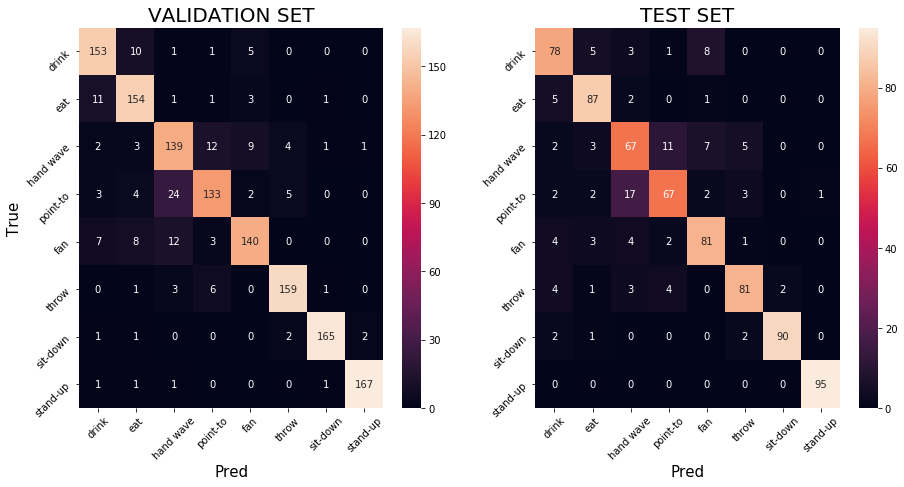

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Val acc: 0.27912087912087913
Test acc: 0.27140974967061926


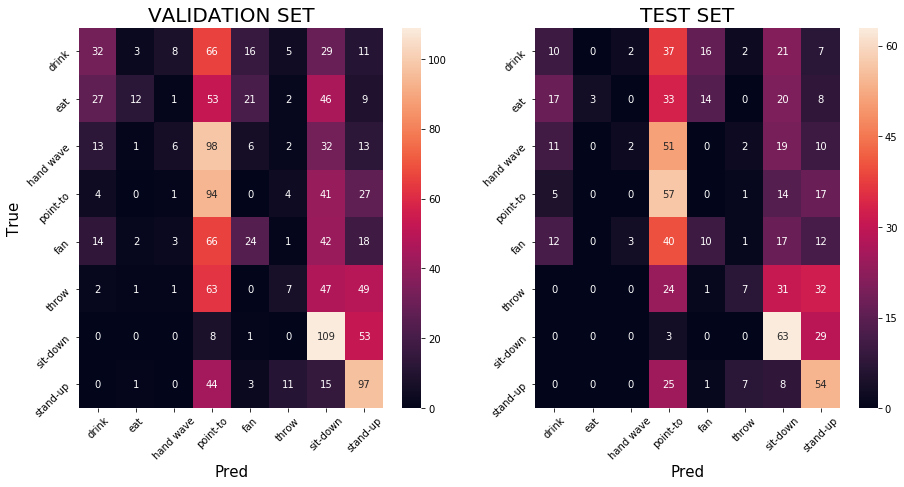

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame


KeyboardInterrupt: 

In [15]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        ## reshaping ###
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
        results.append((val_acc,test_acc,saved_model))

In [14]:
results

[(0.8864468864468864,
  0.8511198945981555,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo.h5'>),
 (0.27912087912087913,
  0.27140974967061926,
  <DirEntry 'PoseNet-101-relativeToVideoCenter.h5'>),
 (0.8827838827838828,
  0.8313570487483531,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame.h5'>),
 (0.2293040293040293,
  0.21080368906455862,
  <DirEntry 'PoseNet-101-relativeToFrameCenter.h5'>),
 (0.1326007326007326,
  0.13175230566534915,
  <DirEntry 'PoseNet-101-relativeToVideoCenter-norm.h5'>),
 (0.18315018315018314,
  0.18972332015810275,
  <DirEntry 'PoseNet-101-relativeToFrameCenter-norm.h5'>),
 (0.8842490842490842,
  0.8642951251646904,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame-norm.h5'>),
 (0.28644688644688643,
  0.29907773386034253,
  <DirEntry 'PoseNet-101-relativeToNextFrame.h5'>),
 (0.21465201465201464, 0.2134387351778656, <DirEntry 'PoseNet-101-norm.h5'>),
 (0.136996336996337,
  0.13175230566534915,
  <DirEntry '

Val acc: 0.8864468864468864
Test acc: 0.8511198945981555


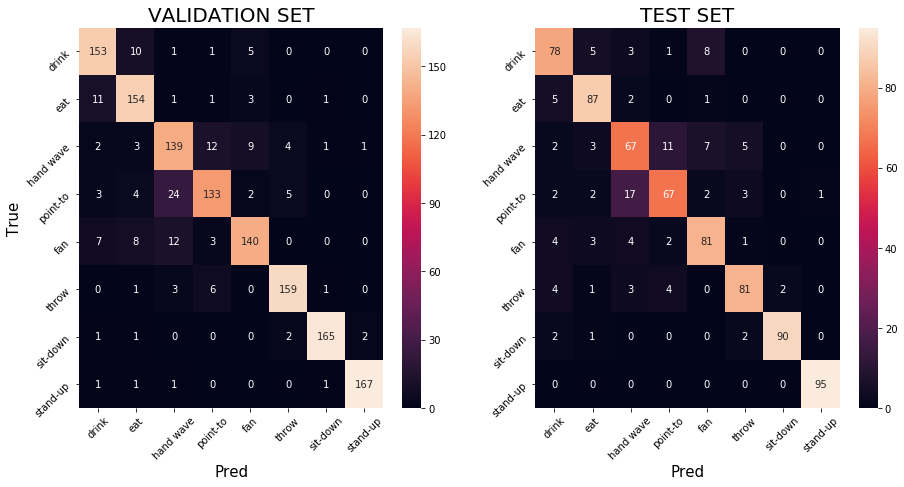

In [34]:
label_order = [1, 2, 31, 38, 49, 7, 8, 9]
model = loadedModel
y_val_pred = [label_order[i] for i in model.predict_classes(X_val)]
y_val_true = [label_order[np.argmax(i)] for i in y_val]
y_test_pred = [label_order[i] for i in model.predict_classes(X_test)]
y_test_true = [label_order[np.argmax(i)] for i in y_test]
val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
print("Val acc:",val_acc)
print("Test acc:",test_acc)
conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
plotConfusionMatrixes(conf_mat_val,conf_mat_test)

In [21]:
y_val_pred

[31,
 2,
 1,
 1,
 2,
 49,
 1,
 7,
 9,
 7,
 1,
 38,
 2,
 8,
 7,
 8,
 1,
 9,
 8,
 2,
 38,
 2,
 38,
 2,
 1,
 1,
 31,
 38,
 31,
 2,
 49,
 31,
 7,
 1,
 31,
 49,
 31,
 31,
 9,
 8,
 49,
 31,
 7,
 2,
 49,
 49,
 38,
 38,
 49,
 9,
 31,
 49,
 2,
 31,
 38,
 7,
 49,
 31,
 1,
 49,
 1,
 38,
 8,
 7,
 31,
 49,
 9,
 9,
 8,
 8,
 7,
 8,
 2,
 7,
 49,
 7,
 2,
 8,
 7,
 7,
 1,
 7,
 31,
 8,
 2,
 7,
 2,
 31,
 31,
 8,
 38,
 9,
 38,
 2,
 9,
 31,
 7,
 8,
 38,
 2,
 31,
 8,
 7,
 49,
 31,
 8,
 49,
 8,
 1,
 38,
 9,
 8,
 2,
 49,
 8,
 38,
 9,
 2,
 49,
 31,
 38,
 38,
 1,
 7,
 31,
 7,
 49,
 49,
 9,
 49,
 8,
 1,
 49,
 9,
 31,
 1,
 1,
 1,
 8,
 7,
 8,
 49,
 9,
 1,
 7,
 8,
 31,
 2,
 38,
 2,
 31,
 8,
 8,
 7,
 2,
 7,
 38,
 49,
 31,
 8,
 49,
 8,
 49,
 49,
 38,
 7,
 9,
 9,
 38,
 7,
 2,
 8,
 2,
 9,
 38,
 8,
 8,
 8,
 7,
 49,
 9,
 8,
 2,
 8,
 31,
 8,
 9,
 38,
 8,
 38,
 31,
 49,
 9,
 8,
 9,
 31,
 49,
 2,
 31,
 1,
 9,
 38,
 8,
 1,
 8,
 8,
 7,
 49,
 1,
 9,
 1,
 38,
 8,
 1,
 8,
 9,
 2,
 49,
 2,
 8,
 1,
 2,
 7,
 1,
 2,
 38,
 49,
 2,
 31,

In [128]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = getValTestAccuracy(loadedModel, X_val, y_val, X_test, y_test)
        print("Validation accuracy:",val_acc,"\nTest accuracy:",test_acc)
        results.append((basename(saved_model),val_acc, test_acc))
#         plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
print("DONE!")

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Validation accuracy: 0.8688644688644689 
Test accuracy: 0.8511198945981555
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each vid

In [114]:
loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)

## continue training

In [13]:
# modelName = 'simple-model.h5'

In [14]:
# from keras.models import load_model
# model = load_model(modelName)

#Continue training
# model.fit(second_training, second_classes, batch_size=32, nb_epoch=20)

# model_history = model.fit(X_train, y_train,
#                     epochs=EPOCHS,
#                     batch_size=BATCH_SIZE,
# #                     validation_split=0.2
#                     validation_data=(X_val, y_val)
#                    )

Train on 5460 samples, validate on 1365 samples
Epoch 1/10
5460/5460 [==============================] - 35s 6ms/step - loss: 1.2101 - accuracy: 0.4623 - val_loss: 1.2212 - val_accuracy: 0.4718
Epoch 2/10
 368/5460 [=>............................] - ETA: 29s - loss: 1.1121 - accuracy: 0.4810

KeyboardInterrupt: 

# Display classification

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score

label_order = [1, 2, 31, 38, 49, 7, 8, 9]
y_pred = loadedModel.predict_classes(X_val)
# label_order = ["1", "2", "31", "38", "49", "7", "8", "9"]
y_pred_labels = [label_order[i] for i in y_pred]
y_val_labels = [label_order[np.argmax(i)] for i in y_val]

In [45]:
accuracy_score(y_pred=y_pred_labels,y_true=y_val_labels)

0.8827838827838828

In [46]:
yTrue=y_pred_labels
yPred=y_test_labels
conf_mat = confusion_matrix(y_true=yTrue, y_pred=yPred, labels=label_order)
conf_mat

array([[133,  16,   4,   4,   8,   0,   0,   0],
       [ 10, 110,   4,   1,  12,   2,   0,   0],
       [  3,   5, 130,   8,   3,   4,   0,   0],
       [  6,   1,   2, 108,   6,   1,   1,   0],
       [  3,   4,   2,   1, 113,   1,   0,   0],
       [  0,   0,   3,   2,   0, 119,   0,   1],
       [  0,   0,   1,   0,   1,   2, 130,   0],
       [  0,   0,   1,   0,   0,   1,   4, 121]])

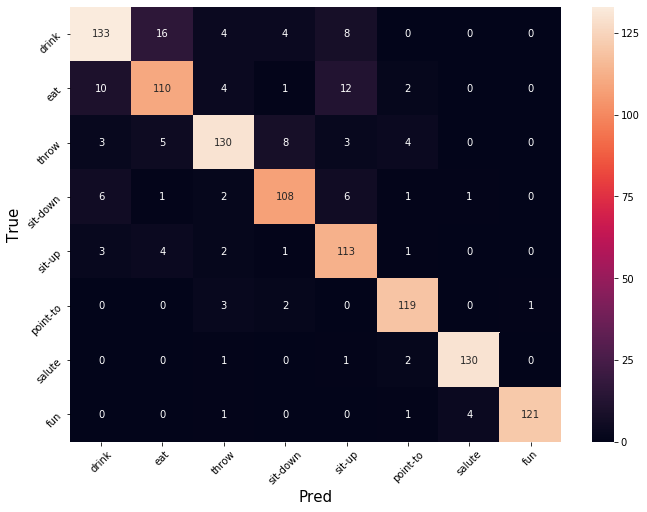

In [41]:
import seaborn as sn
plt.figure(figsize = (11,8))
ax = plt.axes()
labelString = ["drink", "eat", "throw", "sit-down", "sit-up", "point-to", "salute", "fun"]
ax = sn.heatmap(conf_mat, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# plt.title('', fontsize = 20) # title with fontsize 20
plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15

plt.show()

# ACTION_LABEL_SET = 
# A001  - A002 - A007 - A008     - A009   - A031               - A038   -  A049
# drink - eat - throw - sit down - sit up - point to something - salute - make a fun 


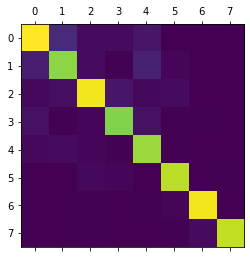

In [42]:
plt.matshow(conf_mat)